In [2]:
import pickle
import os
import re
import string
import nltk
import numpy as np
import pandas as pd
from textblob import TextBlob
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse
from scipy.spatial.distance import cdist
from gensim import corpora, models, similarities, matutils
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
with open('../podcasts/podcasts/jhs.pickle', 'rb') as read_jhs:
    jhs_df = pickle.load(read_jhs)

In [4]:
with open('../podcasts/podcasts/aoc.pickle', 'rb') as read_aoc:
    pdf_df = pickle.load(read_aoc)

In [5]:
df = pd.concat([jhs_df,pdf_df],ignore_index=True)

In [14]:
df[df['title'].isna()]

url title transcript source  \
469  NaN   NaN        NaN    NaN   
470  NaN   NaN        NaN    NaN   
471  NaN   NaN        NaN    NaN   
472  NaN   NaN        NaN    NaN   
473  NaN   NaN        NaN    NaN   

                                               cleaned  \
469    Welcome to Feedback Friday, I'm your host Jo...   
470   Welcome to Feedback Friday. I'm your host, Jo...   
471    Welcome to Feedback Friday. I'm your host Jo...   
472    Welcome to Feedback Friday. I'm your host Jo...   
473  Jordan Harbinger: Welcome to Feedback Friday. ...   

                                            lemmatized  
469  Welcome to the show . I 'm Jordan Harbinger . ...  
470  People are wiring million of dollar and vanish...  
471  Welcome to Feedback Friday , I 'm your host Jo...  
472  Welcome to Feedback Friday . I 'm your host Jo...  
473  Jordan Harbinger : Welcome to Feedback Friday ...

In [13]:
for i in df[df['title'].isna()]['cleaned']:
    print(i)

  Welcome to Feedback Friday, I'm your host Jordan harbinger and I'm here with producer Jason DeFillippo. Here on the Jordan Harbinger Show, we love having conversations with our fascinating guests and this week we had Shawn Achor, one of the world's foremost happiness researchers, which I thought was a bit silly until I started getting into his books. Him and I talk about how we achieve more with certain types of cooperation. We also discussed the actual science behind how we are better together and how by bringing others upward. We do the same for ourselves and we talked with Philip McKernan about finding alignment with the work that we do and why it's so important to know why we do what we do. Phil is an interesting guy who I've been friends with for a while and his message resonates really well with a ton of people, so I'm curious what you all think of it. Of course, our primary mission is to pass along our guests and our experiences and insights along to you. In other words, the r

In [17]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
df['transcript'] = df.transcript.map(alphanumeric).map(punc_lower)
df.head()

TypeError: expected string or bytes-like object

In [49]:
#(541, 44569) With only stop_words='english'
cv1 = CountVectorizer(stop_words='english',strip_accents='unicode',max_df=.40,min_df=15,max_features=1000)
countvect = cv1.fit_transform(df['lemmatized'].apply(lambda x: np.str_(x)))
new_df = pd.DataFrame(countvect.toarray(), columns=cv1.get_feature_names(),index=df['title'])

In [ ]:
with open('countvect.pickle', 'wb') as cv_pickle:
    pickle.dump(countvect, cv_pickle)

In [50]:
#no max/min dfs was 44569, .5/5 was 16640, .4/10=10568
new_df.shape

(541, 1000)

In [50]:
tfidf1 = TfidfVectorizer(stop_words='english',strip_accents='unicode',max_df=.40,min_df=15,max_features=1000)
_tfidf1 = tfidf1.fit_transform(df['lemmatized'].apply(lambda x: np.str_(x)))
new_df2 = pd.DataFrame(_tfidf1.toarray(), columns=tfidf1.get_feature_names(),index=df['title'])

In [13]:
with open('tfidf.pickle', 'wb') as tfidf_pickle:
    pickle.dump(_tfidf1, tfidf_pickle)

In [38]:
new_df2.shape

(541, 1000)

In [17]:
df[df['cleaned'].str.contains('zzjjhjz')]

url  \
266  https://www.jordanharbinger.com/nir-eyal-contr...   

                                                 title  \
266  250: Nir Eyal | Control Your Attention and Cho...   

                                            transcript source  \
266  [<p><b>Jordan Harbinger:</b><span style="font-...    JHS   

                                               cleaned  
266   Welcome to the show. I'm Jordan Harbinger. As...

In [18]:
print(df.loc[266,'cleaned'])

 Welcome to the show. I'm Jordan Harbinger. As always, I'm here with producer, Jason DeFillippo. On The Jordan Harbinger Show, we decode the stories, secrets, and skills of the world's most brilliant and interesting people and turn their wisdom into practical advice that you can use to impact your own life and those around you. Chase Jarvis, he's an award-winning artist, entrepreneur ,and one of the most influential photographers of the past decade and he's a friend of mine, which always works well here on the show. He's worked for huge brands like Apple and Red Bull. However, he's also been in some big slumps, lost his creativity, found it again, sacrificed it on the altar of Silicon Valley capitalism like many of us have, and then reclaimed it. Not a bad ride. Today, we'll discuss some of the most common barriers to creativity and our pursuit of a creative outlet or career, whether that's work or family obligations or just a lack of know-how. Of course, we'll also show you how to wor

In [108]:
lsa1 = TruncatedSVD(5)
cv_topic = lsa1.fit_transform(countvect)
lsa1.explained_variance_ratio_

array([0.19635276, 0.10732225, 0.07132552, 0.05106534, 0.04578245])

In [109]:
cv_topic_word = pd.DataFrame(lsa1.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv1.get_feature_names())
cv_topic_word

bottle  boyfriend   camp  cancer  crack  crisis  domain    fbi  \
component_1   0.022      0.013  0.025   0.050  0.015   0.023   0.010  0.049   
component_2   0.065      0.064  0.064   0.142  0.097   0.086   0.071  0.873   
component_3   0.065      0.086  0.078   0.824  0.046   0.238   0.060 -0.328   
component_4   0.056      0.117  0.245  -0.514  0.082   0.543   0.095 -0.221   
component_5  -0.077     -0.166 -0.292   0.086 -0.069   0.767  -0.155  0.132   

             friendship    gas  ...  population  professor   race  rights  \
component_1       0.010  0.030  ...       0.016      0.014  0.013   0.014   
component_2       0.046  0.060  ...       0.064      0.057  0.048   0.118   
component_3       0.048  0.064  ...       0.089      0.095  0.107   0.026   
component_4       0.079  0.092  ...       0.128      0.059  0.137   0.067   
component_5      -0.064 -0.038  ...      -0.013     -0.032 -0.135  -0.049   

             salary  suffering   tank  technique  threat  toxic  
component_1   0.015      0.994  0.012      0.022   0.015  0.016  
component_2   0.059     -0.087  0.065      0.111   0.108  0.056  
component_3   0.102     -0.061  0.064      0.033   0.067  0.123  
component_4   0.089     -0.022  0.084      0.055   0.219  0.067  
component_5  -0.136      0.014 -0.067     -0.055  -0.069 -0.129  

[5 rows x 30 columns]

In [110]:
lsa2 = TruncatedSVD(5)
tfidf_topic = lsa2.fit_transform(_tfidf1)
lsa2.explained_variance_ratio_

array([0.00828699, 0.05832786, 0.05350391, 0.04850087, 0.04559039])

In [111]:
tfidf_topic_word = pd.DataFrame(lsa2.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf1.get_feature_names())
tfidf_topic_word

bottle  boyfriend   camp  cancer  crack  crisis  domain    fbi  \
component_1   0.169      0.212  0.199   0.206  0.172   0.179   0.166  0.250   
component_2  -0.044     -0.352  0.004  -0.176  0.075   0.019   0.009  0.636   
component_3  -0.019      0.451 -0.024  -0.472 -0.191  -0.148   0.010  0.409   
component_4   0.069      0.067  0.210   0.121  0.000   0.140  -0.202  0.065   
component_5  -0.026      0.041  0.167  -0.275  0.139   0.016  -0.089 -0.183   

             friendship    gas  ...  population  professor   race  rights  \
component_1       0.213  0.170  ...       0.174      0.184  0.152   0.162   
component_2      -0.323  0.036  ...       0.066     -0.061 -0.006   0.065   
component_3       0.282 -0.046  ...      -0.180     -0.163 -0.202   0.035   
component_4       0.589  0.065  ...       0.069     -0.029 -0.014  -0.035   
component_5      -0.082  0.138  ...      -0.017     -0.098  0.040  -0.043   

             salary  suffering   tank  technique  threat  toxic  
component_1   0.209      0.162  0.208      0.187   0.159  0.195  
component_2  -0.248     -0.095 -0.091      0.055   0.145 -0.258  
component_3   0.152     -0.176  0.084      0.085  -0.008  0.080  
component_4  -0.519      0.101 -0.248     -0.186   0.113  0.029  
component_5  -0.448     -0.009  0.744      0.097  -0.039  0.042  

[5 rows x 30 columns]

In [3]:
google_vec_file = '/Users/chuckcao/Downloads/GoogleNews-vectors-negative300.bin'
w2v = models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

2021-02-21 15:45:42,447 : INFO : loading projection weights from /Users/chuckcao/Downloads/GoogleNews-vectors-negative300.bin
2021-02-21 15:47:06,766 : INFO : loaded (3000000, 300) matrix from /Users/chuckcao/Downloads/GoogleNews-vectors-negative300.bin


In [9]:
print(w2v)

In [54]:
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = sklearn_pca.fit_transform(_tfidf1.toarray())
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

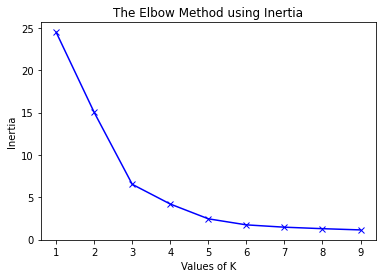

<Figure size 432x288 with 0 Axes>

In [68]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()
plt.savefig('elbow.svg')

In [52]:
from sklearn.decomposition import PCA

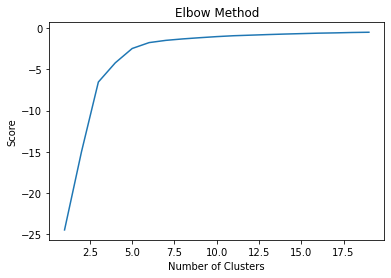

In [53]:
number_clusters = range(1, 20)
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(_tfidf1.toarray())
kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [56]:
kmeans = KMeans(n_clusters=5, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

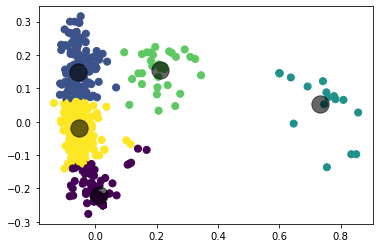

In [67]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6)
plt.savefig('fiveclusters.svg',transparent=True);

In [64]:
Y_sklearn

array([[ 0.80924496,  0.0654855 ],
       [ 0.06909628, -0.22051989],
       [-0.01517868, -0.13865252],
       ...,
       [ 0.02440435, -0.24979632],
       [ 0.02440435, -0.24979632],
       [ 0.02440435, -0.24979632]])

In [59]:
clustering_model = KMeans(
    n_clusters=5,
    max_iter=600,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(_tfidf1)
# print labels

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


In [60]:
X = _tfidf1.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=2).fit_transform(X)
# print reduced_data

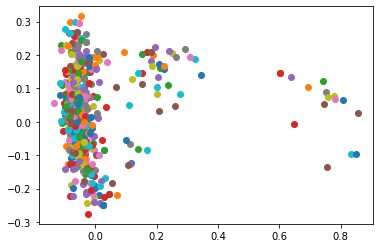

In [63]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    ax.scatter(pca_comp_1, pca_comp_2)
plt.show()

# MODELS

In [112]:
nmf1_model = NMF(5,max_iter=20000)
nmf1_topic = nmf1_model.fit_transform(countvect)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [113]:
nmf1_topic_word = pd.DataFrame(nmf1_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = cv1.get_feature_names())
nmf1_topic_word

bottle  boyfriend   camp  cancer  crack  crisis  domain    fbi  \
component_1   0.104      0.000  0.052   0.000  0.017   0.000   0.000  0.000   
component_2   0.243      0.000  0.000   0.000  0.521   0.000   0.130  9.374   
component_3   0.280      0.045  0.000   8.316  0.071   0.000   0.000  0.000   
component_4   1.008      1.791  2.547   0.000  1.187   0.000   1.605  0.000   
component_5   0.000      0.000  0.000   0.000  0.042   6.947   0.000  0.000   

             friendship    gas  ...  population  professor   race  rights  \
component_1       0.012  0.188  ...       0.029      0.020  0.000   0.012   
component_2       0.081  0.162  ...       0.092      0.113  0.000   0.826   
component_3       0.023  0.141  ...       0.186      0.475  0.182   0.055   
component_4       0.972  1.017  ...       1.155      0.885  1.712   0.980   
component_5       0.089  0.275  ...       0.559      0.259  0.000   0.084   

             salary  suffering   tank  technique  threat  toxic  
component_1   0.009     10.315  0.004      0.089   0.000  0.016  
component_2   0.000      0.000  0.186      0.759   0.276  0.000  
component_3   0.284      0.000  0.138      0.113   0.000  0.539  
component_4   1.564      0.000  1.119      0.975   1.994  1.428  
component_5   0.000      0.000  0.119      0.046   0.336  0.000  

[5 rows x 30 columns]

In [114]:
nmf2_model = NMF(5,max_iter=2000)
nmf2_topic = nmf2_model.fit_transform(_tfidf1)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


In [115]:
nmf2_topic_word = pd.DataFrame(nmf2_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf1.get_feature_names())
nmf2_topic_word

bottle  boyfriend   camp  cancer  crack  crisis  domain   fbi  \
component_1   0.251      0.099  0.000   0.000  0.000   0.000   0.690  0.00   
component_2   0.053      0.000  0.091   0.000  0.038   0.034   0.140  1.74   
component_3   0.301      0.000  0.437   0.808  0.571   0.552   0.150  0.00   
component_4   0.196      1.172  0.241   0.000  0.000   0.072   0.005  0.00   
component_5   0.000      0.064  0.064   0.000  0.018   0.008   0.034  0.00   

             friendship    gas  ...  population  professor   race  rights  \
component_1       0.000  0.000  ...       0.000      0.109  0.000   0.315   
component_2       0.000  0.086  ...       0.044      0.000  0.000   0.245   
component_3       0.000  0.388  ...       0.588      0.591  0.525   0.224   
component_4       1.333  0.092  ...       0.000      0.009  0.000   0.034   
component_5       0.000  0.176  ...       0.000      0.004  0.025   0.019   

             salary  suffering   tank  technique  threat  toxic  
component_1   2.211      0.126  0.000      0.369   0.000  0.017  
component_2   0.000      0.000  0.000      0.284   0.331  0.000  
component_3   0.000      0.487  0.000      0.068   0.308  0.155  
component_4   0.000      0.081  0.000      0.031   0.063  0.765  
component_5   0.000      0.000  1.919      0.444   0.000  0.022  

[5 rows x 30 columns]

In [51]:
corpus1 = matutils.Sparse2Corpus(countvect)

In [52]:
id2word1 = dict((v, k) for k, v in cv1.vocabulary_.items())

In [22]:
len(id2word1)

16640

In [53]:
lda1 = models.LdaModel(corpus=corpus1, num_topics=10, id2word=id2word1, passes=500,update_every=1)

2021-02-21 18:57:44,008 : INFO : using symmetric alpha at 0.1
2021-02-21 18:57:44,009 : INFO : using symmetric eta at 0.1
2021-02-21 18:57:44,013 : INFO : using serial LDA version on this node
2021-02-21 18:57:44,017 : INFO : running online (multi-pass) LDA training, 10 topics, 500 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-21 18:57:46,300 : INFO : -7.527 per-word bound, 184.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:57:46,301 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-02-21 18:57:47,285 : INFO : topic #5 (0.100): 0.007*"giant" + 0.006*"friendship" + 0.006*"english" + 0.005*"cross" + 0.005*"gold" + 0.004*"germany" + 0.004*"clothing" + 0.004*"ai" + 0.004*"executive" + 0.004*"floor"
2021-02-21 18:57:47,286 : INFO : topic #0 (0.100): 0.008*"held" + 0.008*"hide" + 0.00

2021-02-21 18:58:03,228 : INFO : topic #0 (0.100): 0.024*"held" + 0.024*"hide" + 0.019*"hair" + 0.015*"bias" + 0.013*"coffee" + 0.013*"behave" + 0.013*"frame" + 0.011*"function" + 0.010*"birthday" + 0.009*"fbi"
2021-02-21 18:58:03,228 : INFO : topic #7 (0.100): 0.034*"edited" + 0.032*"bother" + 0.028*"dinner" + 0.025*"accept" + 0.023*"double" + 0.023*"acting" + 0.022*"gang" + 0.020*"board" + 0.015*"cycle" + 0.014*"circle"
2021-02-21 18:58:03,230 : INFO : topic diff=0.050153, rho=0.377964
2021-02-21 18:58:05,642 : INFO : -6.024 per-word bound, 65.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:05,642 : INFO : PROGRESS: pass 6, at document #1000/1000
2021-02-21 18:58:06,670 : INFO : topic #7 (0.100): 0.037*"edited" + 0.035*"bother" + 0.030*"dinner" + 0.027*"accept" + 0.025*"acting" + 0.025*"double" + 0.024*"gang" + 0.022*"board" + 0.015*"cycle" + 0.015*"circle"
2021-02-21 18:58:06,671 : INFO : topic #3 (0.100): 0.016*"chapter" + 0.012

2021-02-21 18:58:21,123 : INFO : topic #5 (0.100): 0.009*"english" + 0.007*"clothing" + 0.007*"crew" + 0.006*"ice" + 0.006*"image" + 0.006*"hollywood" + 0.006*"dr" + 0.005*"desire" + 0.005*"cultural" + 0.005*"conscious"
2021-02-21 18:58:21,124 : INFO : topic #3 (0.100): 0.016*"chapter" + 0.012*"exists" + 0.012*"escape" + 0.011*"cognitive" + 0.011*"exciting" + 0.011*"equal" + 0.010*"file" + 0.010*"buddy" + 0.009*"apart" + 0.009*"frank"
2021-02-21 18:58:21,126 : INFO : topic diff=0.026129, rho=0.277350
2021-02-21 18:58:23,015 : INFO : -5.997 per-word bound, 63.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:23,016 : INFO : PROGRESS: pass 12, at document #1000/1000
2021-02-21 18:58:24,060 : INFO : topic #4 (0.100): 0.016*"dive" + 0.012*"anger" + 0.011*"concern" + 0.011*"asset" + 0.011*"eating" + 0.011*"develop" + 0.011*"active" + 0.009*"female" + 0.009*"accident" + 0.009*"chain"
2021-02-21 18:58:24,061 : INFO : topic #5 (0.100): 0.009*

2021-02-21 18:58:38,043 : INFO : topic #2 (0.100): 0.025*"forgot" + 0.021*"germany" + 0.019*"hack" + 0.018*"apparently" + 0.016*"claim" + 0.016*"executive" + 0.015*"cross" + 0.015*"gold" + 0.015*"gun" + 0.014*"friendship"
2021-02-21 18:58:38,044 : INFO : topic #9 (0.100): 0.036*"encourage" + 0.017*"drinking" + 0.015*"crisis" + 0.015*"couch" + 0.010*"drunk" + 0.009*"damage" + 0.009*"achieve" + 0.009*"broken" + 0.009*"cousin" + 0.008*"david"
2021-02-21 18:58:38,046 : INFO : topic diff=0.020381, rho=0.229416
2021-02-21 18:58:39,887 : INFO : -5.987 per-word bound, 63.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:39,888 : INFO : PROGRESS: pass 18, at document #1000/1000
2021-02-21 18:58:40,711 : INFO : topic #7 (0.100): 0.047*"edited" + 0.046*"bother" + 0.038*"accept" + 0.035*"acting" + 0.035*"dinner" + 0.032*"double" + 0.032*"gang" + 0.028*"board" + 0.017*"circle" + 0.017*"cycle"
2021-02-21 18:58:40,712 : INFO : topic #8 (0.100): 0.03

2021-02-21 18:58:55,792 : INFO : topic #9 (0.100): 0.035*"encourage" + 0.017*"drinking" + 0.016*"crisis" + 0.015*"couch" + 0.010*"drunk" + 0.010*"damage" + 0.010*"broken" + 0.009*"achieve" + 0.009*"david" + 0.009*"cousin"
2021-02-21 18:58:55,794 : INFO : topic #7 (0.100): 0.048*"edited" + 0.046*"bother" + 0.039*"accept" + 0.036*"acting" + 0.035*"dinner" + 0.033*"double" + 0.033*"gang" + 0.029*"board" + 0.017*"circle" + 0.017*"function"
2021-02-21 18:58:55,796 : INFO : topic diff=0.019849, rho=0.200000
2021-02-21 18:58:57,667 : INFO : -5.981 per-word bound, 63.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:58:57,668 : INFO : PROGRESS: pass 24, at document #1000/1000
2021-02-21 18:58:58,496 : INFO : topic #5 (0.100): 0.010*"english" + 0.007*"ice" + 0.007*"crew" + 0.007*"image" + 0.006*"dr" + 0.006*"hollywood" + 0.006*"clothing" + 0.006*"cultural" + 0.006*"desire" + 0.006*"gene"
2021-02-21 18:58:58,497 : INFO : topic #7 (0.100): 0.048*"e

2021-02-21 18:59:12,324 : INFO : topic #9 (0.100): 0.035*"encourage" + 0.017*"drinking" + 0.016*"crisis" + 0.015*"couch" + 0.011*"broken" + 0.011*"drunk" + 0.010*"damage" + 0.010*"david" + 0.009*"achieve" + 0.009*"fbi"
2021-02-21 18:59:12,325 : INFO : topic #4 (0.100): 0.018*"dive" + 0.014*"anger" + 0.014*"eating" + 0.014*"asset" + 0.013*"concern" + 0.012*"develop" + 0.011*"active" + 0.011*"chinese" + 0.011*"female" + 0.011*"carry"
2021-02-21 18:59:12,326 : INFO : topic diff=0.020817, rho=0.179605
2021-02-21 18:59:14,174 : INFO : -5.977 per-word bound, 63.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:59:14,175 : INFO : PROGRESS: pass 30, at document #1000/1000
2021-02-21 18:59:14,988 : INFO : topic #2 (0.100): 0.028*"forgot" + 0.022*"germany" + 0.020*"hack" + 0.019*"apparently" + 0.017*"executive" + 0.017*"gold" + 0.017*"claim" + 0.016*"gun" + 0.016*"cross" + 0.015*"friendship"
2021-02-21 18:59:14,988 : INFO : topic #1 (0.100): 0.011

2021-02-21 18:59:28,346 : INFO : topic #6 (0.100): 0.089*"document" + 0.065*"acting" + 0.063*"adam" + 0.046*"ad" + 0.040*"friendship" + 0.032*"advanced" + 0.028*"heavy" + 0.026*"gut" + 0.025*"actor" + 0.022*"documentary"
2021-02-21 18:59:28,347 : INFO : topic #0 (0.100): 0.050*"hide" + 0.050*"held" + 0.034*"hair" + 0.031*"bias" + 0.026*"behave" + 0.025*"coffee" + 0.022*"frame" + 0.020*"birthday" + 0.014*"coaching" + 0.013*"gun"
2021-02-21 18:59:28,348 : INFO : topic diff=0.021075, rho=0.164399
2021-02-21 18:59:30,171 : INFO : -5.974 per-word bound, 62.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:59:30,171 : INFO : PROGRESS: pass 36, at document #1000/1000
2021-02-21 18:59:31,003 : INFO : topic #8 (0.100): 0.035*"guide" + 0.034*"exchange" + 0.034*"embarrassing" + 0.033*"faster" + 0.031*"factor" + 0.030*"blame" + 0.029*"bringing" + 0.028*"hello" + 0.028*"highlight" + 0.028*"experienced"
2021-02-21 18:59:31,005 : INFO : topic #5 (0.100

2021-02-21 18:59:44,370 : INFO : topic #0 (0.100): 0.053*"hide" + 0.053*"held" + 0.035*"hair" + 0.033*"bias" + 0.027*"behave" + 0.026*"coffee" + 0.022*"frame" + 0.021*"birthday" + 0.014*"coaching" + 0.014*"gun"
2021-02-21 18:59:44,371 : INFO : topic #2 (0.100): 0.029*"forgot" + 0.021*"germany" + 0.021*"hack" + 0.019*"apparently" + 0.018*"executive" + 0.018*"gold" + 0.017*"gun" + 0.017*"claim" + 0.016*"cross" + 0.016*"friendship"
2021-02-21 18:59:44,372 : INFO : topic diff=0.020187, rho=0.152499
2021-02-21 18:59:46,190 : INFO : -5.972 per-word bound, 62.8 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 18:59:46,191 : INFO : PROGRESS: pass 42, at document #1000/1000
2021-02-21 18:59:47,012 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"blind" + 0.010*"creative" + 0.009*"comfort" + 0.008*"bus" + 0.008*"affect" + 0.008*"awful" + 0.008*"clean" + 0.008*"award"
2021-02-21 18:59:47,013 : INFO : topic #9 (0.100): 0.034*"encourage"

2021-02-21 19:00:00,324 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"blind" + 0.010*"creative" + 0.009*"comfort" + 0.008*"bus" + 0.008*"affect" + 0.008*"awful" + 0.008*"domain" + 0.008*"award"
2021-02-21 19:00:00,326 : INFO : topic #4 (0.100): 0.019*"dive" + 0.016*"anger" + 0.016*"eating" + 0.015*"asset" + 0.014*"concern" + 0.013*"develop" + 0.012*"chinese" + 0.012*"carry" + 0.011*"female" + 0.011*"balance"
2021-02-21 19:00:00,327 : INFO : topic diff=0.018594, rho=0.142857
2021-02-21 19:00:02,207 : INFO : -5.970 per-word bound, 62.7 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:02,208 : INFO : PROGRESS: pass 48, at document #1000/1000
2021-02-21 19:00:03,011 : INFO : topic #8 (0.100): 0.036*"guide" + 0.035*"exchange" + 0.035*"embarrassing" + 0.033*"faster" + 0.033*"blame" + 0.032*"factor" + 0.030*"bringing" + 0.029*"experienced" + 0.029*"hello" + 0.029*"highlight"
2021-02-21 19:00:03,012 : INFO : topic #1 (0.100

2021-02-21 19:00:16,894 : INFO : topic #9 (0.100): 0.033*"encourage" + 0.017*"drinking" + 0.015*"crisis" + 0.014*"couch" + 0.013*"broken" + 0.011*"fbi" + 0.011*"clothing" + 0.010*"drunk" + 0.010*"david" + 0.010*"achieve"
2021-02-21 19:00:16,895 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"blind" + 0.010*"creative" + 0.009*"comfort" + 0.009*"bus" + 0.008*"domain" + 0.008*"affect" + 0.008*"awful" + 0.008*"inbox"
2021-02-21 19:00:16,897 : INFO : topic diff=0.016783, rho=0.134840
2021-02-21 19:00:18,759 : INFO : -5.969 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:18,760 : INFO : PROGRESS: pass 54, at document #1000/1000
2021-02-21 19:00:19,571 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"ice" + 0.008*"image" + 0.008*"confidence" + 0.007*"crew" + 0.007*"bag" + 0.007*"dr" + 0.007*"cultural" + 0.006*"gene" + 0.006*"desire"
2021-02-21 19:00:19,572 : INFO : topic #7 (0.100): 0.048*"edited" + 

2021-02-21 19:00:34,668 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"ice" + 0.008*"image" + 0.008*"confidence" + 0.007*"crew" + 0.007*"bag" + 0.007*"dr" + 0.007*"cultural" + 0.006*"gene" + 0.006*"desire"
2021-02-21 19:00:34,669 : INFO : topic #2 (0.100): 0.032*"forgot" + 0.020*"hack" + 0.020*"apparently" + 0.019*"executive" + 0.019*"gold" + 0.018*"gun" + 0.017*"claim" + 0.017*"germany" + 0.017*"friendship" + 0.017*"cross"
2021-02-21 19:00:34,671 : INFO : topic diff=0.015125, rho=0.128037
2021-02-21 19:00:36,785 : INFO : -5.967 per-word bound, 62.6 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:36,785 : INFO : PROGRESS: pass 60, at document #1000/1000
2021-02-21 19:00:37,688 : INFO : topic #9 (0.100): 0.033*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"couch" + 0.013*"broken" + 0.012*"clothing" + 0.012*"fbi" + 0.010*"david" + 0.010*"drunk" + 0.010*"achieve"
2021-02-21 19:00:37,689 : INFO : topic #2 (0.100): 0.032*"fo

2021-02-21 19:00:51,665 : INFO : topic #8 (0.100): 0.036*"guide" + 0.036*"exchange" + 0.036*"embarrassing" + 0.035*"blame" + 0.034*"faster" + 0.033*"factor" + 0.030*"bringing" + 0.030*"experienced" + 0.029*"hello" + 0.029*"highlight"
2021-02-21 19:00:51,665 : INFO : topic #4 (0.100): 0.020*"dive" + 0.016*"anger" + 0.016*"eating" + 0.016*"asset" + 0.015*"concern" + 0.013*"develop" + 0.012*"chinese" + 0.012*"carry" + 0.012*"female" + 0.012*"balance"
2021-02-21 19:00:51,667 : INFO : topic diff=0.013617, rho=0.122169
2021-02-21 19:00:53,467 : INFO : -5.966 per-word bound, 62.5 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:00:53,468 : INFO : PROGRESS: pass 66, at document #1000/1000
2021-02-21 19:00:54,269 : INFO : topic #0 (0.100): 0.061*"hide" + 0.061*"held" + 0.040*"hair" + 0.039*"bias" + 0.031*"behave" + 0.030*"coffee" + 0.024*"frame" + 0.023*"birthday" + 0.015*"gun" + 0.015*"coaching"
2021-02-21 19:00:54,269 : INFO : topic #1 (0.100): 

2021-02-21 19:01:08,274 : INFO : topic #9 (0.100): 0.033*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"couch" + 0.013*"broken" + 0.013*"clothing" + 0.012*"fbi" + 0.011*"david" + 0.010*"achieve" + 0.010*"drunk"
2021-02-21 19:01:08,275 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"confidence" + 0.008*"ice" + 0.008*"image" + 0.007*"crew" + 0.007*"bag" + 0.007*"dr" + 0.007*"cultural" + 0.007*"gene" + 0.006*"conscious"
2021-02-21 19:01:08,277 : INFO : topic diff=0.012305, rho=0.117041
2021-02-21 19:01:10,104 : INFO : -5.965 per-word bound, 62.5 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:10,105 : INFO : PROGRESS: pass 72, at document #1000/1000
2021-02-21 19:01:10,906 : INFO : topic #4 (0.100): 0.020*"dive" + 0.017*"anger" + 0.017*"eating" + 0.016*"asset" + 0.015*"concern" + 0.013*"develop" + 0.012*"chinese" + 0.012*"carry" + 0.012*"female" + 0.012*"balance"
2021-02-21 19:01:10,907 : INFO : topic #9 (0.100): 0.033*"enc

2021-02-21 19:01:24,057 : INFO : topic #6 (0.100): 0.084*"document" + 0.064*"acting" + 0.060*"adam" + 0.044*"ad" + 0.035*"friendship" + 0.033*"advanced" + 0.031*"heavy" + 0.029*"gut" + 0.029*"impression" + 0.029*"idiot"
2021-02-21 19:01:24,058 : INFO : topic #1 (0.100): 0.012*"doubt" + 0.011*"broke" + 0.010*"creative" + 0.010*"blind" + 0.009*"comfort" + 0.009*"bus" + 0.009*"domain" + 0.008*"inbox" + 0.008*"award" + 0.008*"affect"
2021-02-21 19:01:24,059 : INFO : topic diff=0.011229, rho=0.112509
2021-02-21 19:01:25,890 : INFO : -5.964 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:25,891 : INFO : PROGRESS: pass 78, at document #1000/1000
2021-02-21 19:01:26,700 : INFO : topic #6 (0.100): 0.084*"document" + 0.064*"acting" + 0.060*"adam" + 0.044*"ad" + 0.035*"friendship" + 0.033*"advanced" + 0.031*"heavy" + 0.029*"gut" + 0.029*"impression" + 0.029*"idiot"
2021-02-21 19:01:26,701 : INFO : topic #3 (0.100): 0.014*"ch

2021-02-21 19:01:39,858 : INFO : topic #9 (0.100): 0.032*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"broken" + 0.014*"couch" + 0.013*"fbi" + 0.011*"david" + 0.010*"achieve" + 0.010*"drunk"
2021-02-21 19:01:39,859 : INFO : topic #4 (0.100): 0.021*"dive" + 0.017*"anger" + 0.017*"eating" + 0.017*"asset" + 0.015*"concern" + 0.013*"develop" + 0.013*"chinese" + 0.013*"carry" + 0.012*"female" + 0.012*"balance"
2021-02-21 19:01:39,861 : INFO : topic diff=0.010342, rho=0.108465
2021-02-21 19:01:41,670 : INFO : -5.963 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:41,671 : INFO : PROGRESS: pass 84, at document #1000/1000
2021-02-21 19:01:42,469 : INFO : topic #0 (0.100): 0.065*"hide" + 0.065*"held" + 0.042*"hair" + 0.041*"bias" + 0.033*"behave" + 0.032*"coffee" + 0.025*"birthday" + 0.025*"frame" + 0.016*"gun" + 0.016*"convenient"
2021-02-21 19:01:42,470 : INFO : topic #2 (0.100): 0.034*"forg

2021-02-21 19:01:55,592 : INFO : topic #5 (0.100): 0.011*"english" + 0.008*"confidence" + 0.008*"ice" + 0.008*"image" + 0.007*"bag" + 0.007*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"gene" + 0.007*"conscious"
2021-02-21 19:01:55,593 : INFO : topic #0 (0.100): 0.065*"hide" + 0.065*"held" + 0.042*"hair" + 0.042*"bias" + 0.033*"behave" + 0.032*"coffee" + 0.025*"frame" + 0.025*"birthday" + 0.016*"debt" + 0.016*"gun"
2021-02-21 19:01:55,595 : INFO : topic diff=0.009604, rho=0.104828
2021-02-21 19:01:57,424 : INFO : -5.963 per-word bound, 62.4 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:01:57,424 : INFO : PROGRESS: pass 90, at document #1000/1000
2021-02-21 19:01:58,220 : INFO : topic #8 (0.100): 0.037*"blame" + 0.037*"exchange" + 0.037*"guide" + 0.036*"embarrassing" + 0.034*"factor" + 0.034*"faster" + 0.031*"bringing" + 0.030*"experienced" + 0.029*"highlight" + 0.029*"hello"
2021-02-21 19:01:58,221 : INFO : topic #5 (0.100): 0.011*"e

2021-02-21 19:02:13,402 : INFO : topic #0 (0.100): 0.066*"hide" + 0.066*"held" + 0.043*"hair" + 0.042*"bias" + 0.033*"behave" + 0.033*"coffee" + 0.025*"frame" + 0.025*"birthday" + 0.018*"debt" + 0.016*"convenient"
2021-02-21 19:02:13,402 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.013*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.010*"cognitive" + 0.010*"boat" + 0.010*"button" + 0.010*"genius" + 0.010*"escape"
2021-02-21 19:02:13,404 : INFO : topic diff=0.008969, rho=0.101535
2021-02-21 19:02:15,294 : INFO : -5.962 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:02:15,295 : INFO : PROGRESS: pass 96, at document #1000/1000
2021-02-21 19:02:16,115 : INFO : topic #6 (0.100): 0.082*"document" + 0.064*"acting" + 0.059*"adam" + 0.043*"ad" + 0.034*"advanced" + 0.033*"friendship" + 0.032*"heavy" + 0.031*"impression" + 0.031*"idiot" + 0.031*"individual"
2021-02-21 19:02:16,116 : INFO : topic #3 (0.100): 

2021-02-21 19:02:29,306 : INFO : topic #9 (0.100): 0.032*"encourage" + 0.016*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.013*"fbi" + 0.011*"david" + 0.011*"achieve" + 0.010*"drunk"
2021-02-21 19:02:29,307 : INFO : topic #0 (0.100): 0.067*"hide" + 0.067*"held" + 0.043*"hair" + 0.043*"bias" + 0.034*"behave" + 0.033*"coffee" + 0.026*"frame" + 0.025*"birthday" + 0.019*"debt" + 0.018*"defense"
2021-02-21 19:02:29,308 : INFO : topic diff=0.008383, rho=0.098533
2021-02-21 19:02:31,130 : INFO : -5.961 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:02:31,131 : INFO : PROGRESS: pass 102, at document #1000/1000
2021-02-21 19:02:31,922 : INFO : topic #7 (0.100): 0.044*"edited" + 0.039*"bother" + 0.037*"germany" + 0.037*"accept" + 0.036*"gang" + 0.033*"acting" + 0.030*"dinner" + 0.030*"canada" + 0.029*"double" + 0.028*"giant"
2021-02-21 19:02:31,924 : INFO : topic #8 (0.100): 0.038*"blame"

2021-02-21 19:02:45,079 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:02:45,080 : INFO : topic #7 (0.100): 0.044*"edited" + 0.038*"bother" + 0.038*"germany" + 0.037*"accept" + 0.035*"gang" + 0.033*"acting" + 0.030*"dinner" + 0.030*"canada" + 0.029*"double" + 0.028*"giant"
2021-02-21 19:02:45,082 : INFO : topic diff=0.007906, rho=0.095783
2021-02-21 19:02:46,898 : INFO : -5.961 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:02:46,898 : INFO : PROGRESS: pass 108, at document #1000/1000
2021-02-21 19:02:47,688 : INFO : topic #2 (0.100): 0.036*"forgot" + 0.021*"gold" + 0.020*"friendship" + 0.020*"gun" + 0.020*"executive" + 0.019*"claim" + 0.019*"dah" + 0.018*"cross" + 0.018*"apparently" + 0.018*"hack"
2021-02-21 19:02:47,689 : INFO : topic #1 (0.100): 0.013

2021-02-21 19:03:00,806 : INFO : topic #7 (0.100): 0.044*"edited" + 0.038*"germany" + 0.038*"bother" + 0.036*"accept" + 0.035*"gang" + 0.032*"acting" + 0.030*"canada" + 0.030*"dinner" + 0.029*"giant" + 0.029*"double"
2021-02-21 19:03:00,807 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:03:00,808 : INFO : topic diff=0.007551, rho=0.093250
2021-02-21 19:03:02,618 : INFO : -5.960 per-word bound, 62.3 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:02,619 : INFO : PROGRESS: pass 114, at document #1000/1000
2021-02-21 19:03:03,417 : INFO : topic #2 (0.100): 0.036*"forgot" + 0.021*"gold" + 0.021*"friendship" + 0.020*"gun" + 0.019*"claim" + 0.019*"executive" + 0.019*"dah" + 0.019*"cross" + 0.018*"apparently" + 0.017*"hack"
2021-02-21 19:03:03,417 : INFO : topic #8 (0.100): 0.039

2021-02-21 19:03:17,115 : INFO : topic #8 (0.100): 0.039*"blame" + 0.037*"guide" + 0.037*"exchange" + 0.037*"embarrassing" + 0.035*"factor" + 0.035*"faster" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"highlight" + 0.030*"hello"
2021-02-21 19:03:17,118 : INFO : topic #9 (0.100): 0.031*"encourage" + 0.015*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"broken" + 0.014*"fbi" + 0.013*"couch" + 0.011*"achieve" + 0.011*"david" + 0.010*"cousin"
2021-02-21 19:03:17,120 : INFO : topic diff=0.007293, rho=0.090909
2021-02-21 19:03:18,927 : INFO : -5.960 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:18,927 : INFO : PROGRESS: pass 120, at document #1000/1000
2021-02-21 19:03:19,730 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:03:19,731 : INFO : to

2021-02-21 19:03:32,917 : INFO : topic #5 (0.100): 0.009*"english" + 0.008*"confidence" + 0.008*"ice" + 0.008*"image" + 0.008*"bag" + 0.007*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently"
2021-02-21 19:03:32,917 : INFO : topic #2 (0.100): 0.036*"forgot" + 0.021*"friendship" + 0.021*"gold" + 0.020*"gun" + 0.020*"claim" + 0.020*"dah" + 0.019*"executive" + 0.019*"cross" + 0.017*"apparently" + 0.016*"hack"
2021-02-21 19:03:32,919 : INFO : topic diff=0.007071, rho=0.088736
2021-02-21 19:03:34,728 : INFO : -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:34,728 : INFO : PROGRESS: pass 126, at document #1000/1000
2021-02-21 19:03:35,528 : INFO : topic #0 (0.100): 0.071*"hide" + 0.071*"held" + 0.046*"bias" + 0.045*"hair" + 0.036*"behave" + 0.035*"coffee" + 0.027*"frame" + 0.026*"birthday" + 0.023*"debt" + 0.022*"defense"
2021-02-21 19:03:35,529 : INFO : topic #7 (0.100): 0.044*"edite

2021-02-21 19:03:49,593 : INFO : topic #3 (0.100): 0.014*"chapter" + 0.014*"exciting" + 0.013*"exists" + 0.012*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:03:49,596 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.013*"carry" + 0.013*"chinese" + 0.013*"female" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:03:49,597 : INFO : topic diff=0.006833, rho=0.086711
2021-02-21 19:03:51,763 : INFO : -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:03:51,764 : INFO : PROGRESS: pass 132, at document #1000/1000
2021-02-21 19:03:52,551 : INFO : topic #0 (0.100): 0.071*"hide" + 0.071*"held" + 0.046*"bias" + 0.046*"hair" + 0.036*"behave" + 0.035*"coffee" + 0.028*"frame" + 0.027*"birthday" + 0.024*"debt" + 0.022*"defense"
2021-02-21 19:03:52,552 : INFO : topic #8 (0.100): 0.040*"blam

2021-02-21 19:04:05,645 : INFO : topic #6 (0.100): 0.079*"document" + 0.064*"acting" + 0.058*"adam" + 0.042*"ad" + 0.034*"advanced" + 0.033*"impression" + 0.033*"individual" + 0.033*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:04:05,646 : INFO : topic #0 (0.100): 0.072*"hide" + 0.072*"held" + 0.047*"bias" + 0.046*"hair" + 0.037*"behave" + 0.036*"coffee" + 0.028*"frame" + 0.027*"birthday" + 0.024*"debt" + 0.023*"defense"
2021-02-21 19:04:05,647 : INFO : topic diff=0.006538, rho=0.084819
2021-02-21 19:04:07,487 : INFO : -5.959 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:07,487 : INFO : PROGRESS: pass 138, at document #1000/1000
2021-02-21 19:04:08,422 : INFO : topic #9 (0.100): 0.031*"encourage" + 0.015*"drinking" + 0.015*"crisis" + 0.014*"clothing" + 0.014*"fbi" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.011*"david" + 0.010*"cousin"
2021-02-21 19:04:08,423 : INFO : topic #4 (0.100): 0.022*"di

2021-02-21 19:04:21,953 : INFO : topic #0 (0.100): 0.073*"hide" + 0.073*"held" + 0.047*"bias" + 0.047*"hair" + 0.037*"behave" + 0.036*"coffee" + 0.028*"frame" + 0.027*"birthday" + 0.025*"debt" + 0.023*"defense"
2021-02-21 19:04:21,953 : INFO : topic #2 (0.100): 0.037*"forgot" + 0.022*"friendship" + 0.022*"gold" + 0.020*"claim" + 0.020*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.016*"feature" + 0.016*"apparently"
2021-02-21 19:04:21,954 : INFO : topic diff=0.006196, rho=0.083045
2021-02-21 19:04:23,773 : INFO : -5.958 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:23,774 : INFO : PROGRESS: pass 144, at document #1000/1000
2021-02-21 19:04:24,562 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.014*"carry" + 0.013*"female" + 0.013*"chinese" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:04:24,563 : INFO : topic #9 (0.100): 0.031*"encou

2021-02-21 19:04:37,783 : INFO : topic #7 (0.100): 0.043*"edited" + 0.040*"germany" + 0.037*"bother" + 0.036*"accept" + 0.035*"gang" + 0.031*"acting" + 0.031*"canada" + 0.030*"giant" + 0.029*"dinner" + 0.028*"double"
2021-02-21 19:04:37,785 : INFO : topic #6 (0.100): 0.078*"document" + 0.064*"acting" + 0.057*"adam" + 0.042*"ad" + 0.034*"advanced" + 0.033*"impression" + 0.033*"individual" + 0.033*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:04:37,786 : INFO : topic diff=0.005846, rho=0.081379
2021-02-21 19:04:39,584 : INFO : -5.958 per-word bound, 62.2 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:39,584 : INFO : PROGRESS: pass 150, at document #1000/1000
2021-02-21 19:04:40,374 : INFO : topic #8 (0.100): 0.040*"blame" + 0.037*"guide" + 0.037*"exchange" + 0.037*"embarrassing" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"highlight" + 0.030*"hello"
2021-02-21 19:04:40,375 : INFO : topic #0 

2021-02-21 19:04:53,485 : INFO : topic #5 (0.100): 0.008*"image" + 0.008*"ice" + 0.008*"confidence" + 0.008*"english" + 0.008*"bag" + 0.007*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently"
2021-02-21 19:04:53,486 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.014*"carry" + 0.014*"female" + 0.013*"chinese" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:04:53,487 : INFO : topic diff=0.005476, rho=0.079809
2021-02-21 19:04:55,285 : INFO : -5.958 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:04:55,286 : INFO : PROGRESS: pass 156, at document #1000/1000
2021-02-21 19:04:56,071 : INFO : topic #6 (0.100): 0.078*"document" + 0.064*"acting" + 0.057*"adam" + 0.041*"ad" + 0.034*"advanced" + 0.034*"impression" + 0.034*"individual" + 0.034*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:04:56,072 : INFO : topic #5 (0.100): 0.0

2021-02-21 19:05:09,267 : INFO : topic #4 (0.100): 0.022*"dive" + 0.018*"anger" + 0.018*"eating" + 0.018*"asset" + 0.015*"concern" + 0.014*"carry" + 0.014*"female" + 0.014*"chinese" + 0.013*"develop" + 0.013*"balance"
2021-02-21 19:05:09,268 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.015*"crisis" + 0.015*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:05:09,269 : INFO : topic diff=0.005146, rho=0.078326
2021-02-21 19:05:11,716 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:11,717 : INFO : PROGRESS: pass 162, at document #1000/1000
2021-02-21 19:05:12,616 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.015*"crisis" + 0.015*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:05:12,618 : INFO : topic #0 (0.100): 

2021-02-21 19:05:25,767 : INFO : topic #6 (0.100): 0.077*"document" + 0.064*"acting" + 0.057*"adam" + 0.041*"ad" + 0.035*"advanced" + 0.034*"impression" + 0.034*"individual" + 0.034*"idiot" + 0.032*"heavy" + 0.031*"gut"
2021-02-21 19:05:25,768 : INFO : topic #0 (0.100): 0.075*"hide" + 0.075*"held" + 0.049*"bias" + 0.048*"hair" + 0.038*"behave" + 0.037*"coffee" + 0.029*"frame" + 0.028*"birthday" + 0.026*"debt" + 0.024*"defense"
2021-02-21 19:05:25,769 : INFO : topic diff=0.004847, rho=0.076923
2021-02-21 19:05:27,610 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:27,611 : INFO : PROGRESS: pass 168, at document #1000/1000
2021-02-21 19:05:28,406 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"exists" + 0.013*"hoping" + 0.012*"buddy" + 0.011*"boat" + 0.010*"genius" + 0.010*"button" + 0.010*"cognitive" + 0.010*"escape"
2021-02-21 19:05:28,407 : INFO : topic #2 (0.100): 0.038*"fo

2021-02-21 19:05:41,511 : INFO : topic #0 (0.100): 0.076*"hide" + 0.076*"held" + 0.050*"bias" + 0.049*"hair" + 0.039*"behave" + 0.037*"coffee" + 0.029*"frame" + 0.028*"birthday" + 0.026*"debt" + 0.025*"defense"
2021-02-21 19:05:41,512 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.023*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.020*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.017*"feature" + 0.016*"government"
2021-02-21 19:05:41,513 : INFO : topic diff=0.004596, rho=0.075593
2021-02-21 19:05:43,304 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:43,305 : INFO : PROGRESS: pass 174, at document #1000/1000
2021-02-21 19:05:44,116 : INFO : topic #8 (0.100): 0.041*"blame" + 0.037*"guide" + 0.037*"exchange" + 0.037*"embarrassing" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"highlight" + 0.030*"hello"
2021-02-21 19:05:44,117 : INFO : topic #7 (0.10

2021-02-21 19:05:57,248 : INFO : topic #1 (0.100): 0.013*"doubt" + 0.012*"broke" + 0.011*"creative" + 0.011*"cycle" + 0.010*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.009*"core" + 0.009*"documentary" + 0.009*"award"
2021-02-21 19:05:57,248 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.024*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.021*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.017*"feature" + 0.017*"english"
2021-02-21 19:05:57,249 : INFO : topic diff=0.004390, rho=0.074329
2021-02-21 19:05:59,061 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:05:59,062 : INFO : PROGRESS: pass 180, at document #1000/1000
2021-02-21 19:05:59,876 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.015*"crisis" + 0.014*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:05:59,877 : INFO : topic #7 (0.100): 0.043

2021-02-21 19:06:14,035 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.024*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.021*"dah" + 0.020*"gun" + 0.019*"cross" + 0.018*"executive" + 0.017*"english" + 0.017*"feature"
2021-02-21 19:06:14,035 : INFO : topic #8 (0.100): 0.042*"blame" + 0.037*"guide" + 0.037*"embarrassing" + 0.037*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:06:14,037 : INFO : topic diff=0.004193, rho=0.073127
2021-02-21 19:06:15,917 : INFO : -5.957 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:06:15,918 : INFO : PROGRESS: pass 186, at document #1000/1000
2021-02-21 19:06:16,719 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.014*"crisis" + 0.014*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:06:16,720 : INFO : topic 

2021-02-21 19:06:29,887 : INFO : topic #0 (0.100): 0.077*"hide" + 0.077*"held" + 0.051*"bias" + 0.050*"hair" + 0.040*"behave" + 0.038*"coffee" + 0.030*"frame" + 0.029*"birthday" + 0.027*"debt" + 0.025*"defense"
2021-02-21 19:06:29,888 : INFO : topic #9 (0.100): 0.030*"encourage" + 0.014*"crisis" + 0.014*"drinking" + 0.014*"fbi" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:06:29,889 : INFO : topic diff=0.004003, rho=0.071982
2021-02-21 19:06:31,726 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:06:31,727 : INFO : PROGRESS: pass 192, at document #1000/1000
2021-02-21 19:06:32,518 : INFO : topic #2 (0.100): 0.038*"forgot" + 0.024*"friendship" + 0.022*"gold" + 0.021*"claim" + 0.021*"dah" + 0.020*"gun" + 0.019*"cross" + 0.017*"executive" + 0.017*"english" + 0.017*"feature"
2021-02-21 19:06:32,519 : INFO : topic #5 (0.100): 0.009*"imag

2021-02-21 19:06:45,604 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.018*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.013*"balance" + 0.013*"develop"
2021-02-21 19:06:45,605 : INFO : topic #0 (0.100): 0.078*"hide" + 0.078*"held" + 0.052*"bias" + 0.050*"hair" + 0.040*"behave" + 0.039*"coffee" + 0.030*"frame" + 0.029*"birthday" + 0.027*"debt" + 0.025*"defense"
2021-02-21 19:06:45,606 : INFO : topic diff=0.003823, rho=0.070888
2021-02-21 19:06:47,421 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:06:47,422 : INFO : PROGRESS: pass 198, at document #1000/1000
2021-02-21 19:06:48,215 : INFO : topic #8 (0.100): 0.042*"blame" + 0.037*"guide" + 0.037*"embarrassing" + 0.037*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:06:48,216 : INFO : topic #1 (0.100):

2021-02-21 19:07:01,264 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.018*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:07:01,265 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:01,266 : INFO : topic diff=0.003651, rho=0.069843
2021-02-21 19:07:03,072 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:03,072 : INFO : PROGRESS: pass 204, at document #1000/1000
2021-02-21 19:07:03,845 : INFO : topic #5 (0.100): 0.009*"image" + 0.009*"ice" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"english" + 0.007*"conscious" + 0.007*"differently"
2021-02-21 19:07:03,846 : INFO : topic #8 (0.100): 0

2021-02-21 19:07:16,926 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:16,927 : INFO : topic #1 (0.100): 0.013*"doubt" + 0.012*"broke" + 0.011*"cycle" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.009*"documentary" + 0.009*"award"
2021-02-21 19:07:16,928 : INFO : topic diff=0.003477, rho=0.068843
2021-02-21 19:07:18,745 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:18,746 : INFO : PROGRESS: pass 210, at document #1000/1000
2021-02-21 19:07:19,539 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:19,540 : INFO : topic #2 (0.100): 0

2021-02-21 19:07:33,250 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"clothing" + 0.014*"broken" + 0.013*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:33,251 : INFO : topic #1 (0.100): 0.013*"doubt" + 0.012*"broke" + 0.011*"cycle" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.009*"documentary" + 0.009*"award"
2021-02-21 19:07:33,251 : INFO : topic diff=0.003305, rho=0.067884
2021-02-21 19:07:35,284 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:35,285 : INFO : PROGRESS: pass 216, at document #1000/1000
2021-02-21 19:07:36,187 : INFO : topic #8 (0.100): 0.042*"blame" + 0.037*"guide" + 0.037*"embarrassing" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:07:36,188 : INFO : topic #

2021-02-21 19:07:50,560 : INFO : topic #8 (0.100): 0.043*"blame" + 0.037*"embarrassing" + 0.037*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello" + 0.030*"highlight"
2021-02-21 19:07:50,561 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"broken" + 0.014*"clothing" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:07:50,563 : INFO : topic diff=0.003139, rho=0.066965
2021-02-21 19:07:52,364 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:07:52,364 : INFO : PROGRESS: pass 222, at document #1000/1000
2021-02-21 19:07:53,151 : INFO : topic #6 (0.100): 0.073*"document" + 0.062*"acting" + 0.056*"adam" + 0.040*"ad" + 0.036*"impression" + 0.036*"individual" + 0.036*"idiot" + 0.035*"advanced" + 0.032*"heavy" + 0.032*"gut"
2021-02-21 19:07:53,152 : INFO : topi

2021-02-21 19:08:06,293 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.018*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:08:06,294 : INFO : topic #0 (0.100): 0.080*"held" + 0.080*"hide" + 0.053*"bias" + 0.051*"hair" + 0.041*"behave" + 0.040*"coffee" + 0.031*"frame" + 0.030*"birthday" + 0.028*"debt" + 0.026*"defense"
2021-02-21 19:08:06,295 : INFO : topic diff=0.002986, rho=0.066082
2021-02-21 19:08:08,417 : INFO : -5.956 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:08,418 : INFO : PROGRESS: pass 228, at document #1000/1000
2021-02-21 19:08:09,194 : INFO : topic #0 (0.100): 0.080*"held" + 0.080*"hide" + 0.053*"bias" + 0.052*"hair" + 0.041*"behave" + 0.040*"coffee" + 0.031*"frame" + 0.030*"birthday" + 0.028*"debt" + 0.026*"defense"
2021-02-21 19:08:09,195 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"i

2021-02-21 19:08:22,835 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"drinking" + 0.014*"broken" + 0.014*"clothing" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.010*"cousin"
2021-02-21 19:08:22,836 : INFO : topic #8 (0.100): 0.043*"blame" + 0.037*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"active" + 0.030*"hello"
2021-02-21 19:08:22,838 : INFO : topic diff=0.002868, rho=0.065233
2021-02-21 19:08:24,668 : INFO : -5.955 per-word bound, 62.1 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:24,669 : INFO : PROGRESS: pass 234, at document #1000/1000
2021-02-21 19:08:25,473 : INFO : topic #0 (0.100): 0.080*"held" + 0.080*"hide" + 0.054*"bias" + 0.052*"hair" + 0.041*"behave" + 0.040*"coffee" + 0.031*"frame" + 0.030*"birthday" + 0.028*"debt" + 0.027*"defense"
2021-02-21 19:08:25,474 : INFO : topic #1 (0.100)

2021-02-21 19:08:38,527 : INFO : topic #9 (0.100): 0.029*"encourage" + 0.014*"crisis" + 0.014*"fbi" + 0.014*"broken" + 0.014*"drinking" + 0.014*"clothing" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.009*"cousin"
2021-02-21 19:08:38,529 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.018*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:08:38,530 : INFO : topic diff=0.002759, rho=0.064416
2021-02-21 19:08:40,333 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:40,340 : INFO : PROGRESS: pass 240, at document #1000/1000
2021-02-21 19:08:41,509 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"gene"
2021-02-21 19:08:41,509 : INFO : topic #6 (0.100): 0.07

2021-02-21 19:08:54,837 : INFO : topic #8 (0.100): 0.043*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"active" + 0.030*"hello"
2021-02-21 19:08:54,837 : INFO : topic #2 (0.100): 0.039*"forgot" + 0.026*"friendship" + 0.023*"gold" + 0.022*"claim" + 0.021*"dah" + 0.019*"gun" + 0.019*"english" + 0.018*"cross" + 0.017*"government" + 0.017*"feature"
2021-02-21 19:08:54,839 : INFO : topic diff=0.002685, rho=0.063628
2021-02-21 19:08:56,639 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:08:56,639 : INFO : PROGRESS: pass 246, at document #1000/1000
2021-02-21 19:08:57,429 : INFO : topic #2 (0.100): 0.039*"forgot" + 0.026*"friendship" + 0.023*"gold" + 0.022*"claim" + 0.021*"dah" + 0.019*"gun" + 0.019*"english" + 0.018*"cross" + 0.017*"government" + 0.017*"feature"
2021-02-21 19:08:57,430 : INFO : topic #3 (0

2021-02-21 19:09:10,582 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"desire"
2021-02-21 19:09:10,583 : INFO : topic #7 (0.100): 0.042*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.031*"canada" + 0.030*"acting" + 0.028*"dinner" + 0.027*"double"
2021-02-21 19:09:10,585 : INFO : topic diff=0.002612, rho=0.062869
2021-02-21 19:09:12,395 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:09:12,396 : INFO : PROGRESS: pass 252, at document #1000/1000
2021-02-21 19:09:13,190 : INFO : topic #2 (0.100): 0.039*"forgot" + 0.026*"friendship" + 0.023*"gold" + 0.022*"claim" + 0.021*"dah" + 0.019*"gun" + 0.019*"english" + 0.018*"cross" + 0.017*"government" + 0.017*"feature"
2021-02-21 19:09:13,191 : INFO : topic #3 (0.100): 0.014*

2021-02-21 19:09:28,422 : INFO : topic #7 (0.100): 0.042*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.031*"canada" + 0.030*"acting" + 0.028*"dinner" + 0.027*"hack"
2021-02-21 19:09:28,423 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.014*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:09:28,424 : INFO : topic diff=0.002556, rho=0.062137
2021-02-21 19:09:31,085 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:09:31,086 : INFO : PROGRESS: pass 258, at document #1000/1000
2021-02-21 19:09:32,224 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"confidence" + 0.008*"bag" + 0.008*"crew" + 0.007*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"desire"
2021-02-21 19:09:32,226 : INFO : topic #0 (0.100): 0.082*"he

2021-02-21 19:09:47,778 : INFO : topic #6 (0.100): 0.071*"document" + 0.061*"acting" + 0.055*"adam" + 0.039*"ad" + 0.038*"impression" + 0.038*"individual" + 0.038*"idiot" + 0.035*"advanced" + 0.033*"gut" + 0.032*"heavy"
2021-02-21 19:09:47,778 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.011*"boat" + 0.011*"genius" + 0.011*"button" + 0.010*"hotel" + 0.010*"escape"
2021-02-21 19:09:47,780 : INFO : topic diff=0.002500, rho=0.061430
2021-02-21 19:09:49,580 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:09:49,581 : INFO : PROGRESS: pass 264, at document #1000/1000
2021-02-21 19:09:50,374 : INFO : topic #7 (0.100): 0.042*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.031*"canada" + 0.030*"acting" + 0.028*"dinner" + 0.027*"hack"
2021-02-21 19:09:50,375 : INFO : topic #3 (0.100): 0.014*"ex

2021-02-21 19:10:08,985 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.015*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:10:08,987 : INFO : topic #8 (0.100): 0.044*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"bringing" + 0.031*"active" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:10:08,989 : INFO : topic diff=0.002446, rho=0.060746
2021-02-21 19:10:12,328 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:10:12,329 : INFO : PROGRESS: pass 270, at document #1000/1000
2021-02-21 19:10:13,224 : INFO : topic #6 (0.100): 0.071*"document" + 0.061*"acting" + 0.055*"adam" + 0.039*"ad" + 0.038*"impression" + 0.038*"individual" + 0.038*"idiot" + 0.035*"advanced" + 0.033*"gut" + 0.032*"heavy"
2021-02-21 19:10:13,225 : INFO : topic #1 (0

2021-02-21 19:10:32,180 : INFO : topic #8 (0.100): 0.044*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:10:32,182 : INFO : topic #6 (0.100): 0.070*"document" + 0.061*"acting" + 0.055*"adam" + 0.039*"ad" + 0.038*"impression" + 0.038*"individual" + 0.038*"idiot" + 0.035*"advanced" + 0.033*"gut" + 0.032*"heavy"
2021-02-21 19:10:32,183 : INFO : topic diff=0.002390, rho=0.060084
2021-02-21 19:10:34,012 : INFO : -5.955 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:10:34,013 : INFO : PROGRESS: pass 276, at document #1000/1000
2021-02-21 19:10:34,791 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:10:34,792 : INFO : topic #7 (0.

2021-02-21 19:10:47,832 : INFO : topic #0 (0.100): 0.083*"held" + 0.083*"hide" + 0.056*"bias" + 0.053*"hair" + 0.043*"behave" + 0.042*"coffee" + 0.032*"frame" + 0.031*"birthday" + 0.030*"debt" + 0.028*"defense"
2021-02-21 19:10:47,833 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.015*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:10:47,833 : INFO : topic diff=0.002324, rho=0.059444
2021-02-21 19:10:49,628 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:10:49,629 : INFO : PROGRESS: pass 282, at document #1000/1000
2021-02-21 19:10:50,397 : INFO : topic #7 (0.100): 0.041*"edited" + 0.040*"germany" + 0.035*"bother" + 0.035*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.028*"hack" + 0.027*"dinner"
2021-02-21 19:10:50,398 : INFO : topic #6 (0.100): 0.070*"document" +

2021-02-21 19:11:03,418 : INFO : topic #0 (0.100): 0.083*"held" + 0.083*"hide" + 0.056*"bias" + 0.053*"hair" + 0.043*"behave" + 0.042*"coffee" + 0.032*"frame" + 0.031*"birthday" + 0.030*"debt" + 0.028*"defense"
2021-02-21 19:11:03,419 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:03,420 : INFO : topic diff=0.002257, rho=0.058824
2021-02-21 19:11:05,293 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:05,294 : INFO : PROGRESS: pass 288, at document #1000/1000
2021-02-21 19:11:06,100 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"concern" + 0.015*"female" + 0.014*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:11:06,100 : INFO : topic #8 (0.100): 0.045*"blame" + 

2021-02-21 19:11:19,995 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:19,996 : INFO : topic #8 (0.100): 0.045*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:11:19,997 : INFO : topic diff=0.002190, rho=0.058222
2021-02-21 19:11:21,799 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:21,799 : INFO : PROGRESS: pass 294, at document #1000/1000
2021-02-21 19:11:22,574 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:22,575 : INFO : topic #9 (0.100

2021-02-21 19:11:35,642 : INFO : topic #6 (0.100): 0.069*"document" + 0.060*"acting" + 0.054*"adam" + 0.039*"impression" + 0.039*"individual" + 0.039*"idiot" + 0.039*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:11:35,643 : INFO : topic #7 (0.100): 0.041*"edited" + 0.040*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.028*"hack" + 0.027*"dinner"
2021-02-21 19:11:35,644 : INFO : topic diff=0.002121, rho=0.057639
2021-02-21 19:11:37,464 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:37,465 : INFO : PROGRESS: pass 300, at document #1000/1000
2021-02-21 19:11:38,244 : INFO : topic #0 (0.100): 0.083*"hide" + 0.083*"held" + 0.056*"bias" + 0.054*"hair" + 0.043*"behave" + 0.042*"coffee" + 0.033*"frame" + 0.031*"birthday" + 0.030*"debt" + 0.028*"defense"
2021-02-21 19:11:38,245 : INFO : topic #5 (0.100): 0.009*"ice" + 0.

2021-02-21 19:11:51,792 : INFO : topic #8 (0.100): 0.045*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.031*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:11:51,793 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.014*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.009*"cousin"
2021-02-21 19:11:51,794 : INFO : topic diff=0.002059, rho=0.057073
2021-02-21 19:11:53,586 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:11:53,587 : INFO : PROGRESS: pass 306, at document #1000/1000
2021-02-21 19:11:54,361 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:11:54,361 : INFO : topic #2 (

2021-02-21 19:12:07,736 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.029*"hack" + 0.027*"dinner"
2021-02-21 19:12:07,736 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"blind" + 0.010*"comfort" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:12:07,738 : INFO : topic diff=0.002005, rho=0.056523
2021-02-21 19:12:09,710 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:09,711 : INFO : PROGRESS: pass 312, at document #1000/1000
2021-02-21 19:12:10,510 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.029*"hack" + 0.027*"dinner"
2021-02-21 19:12:10,511 : INFO : topic #5 (0.100): 0.009*"ice" + 0

2021-02-21 19:12:24,260 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"acting" + 0.029*"hack" + 0.027*"dinner"
2021-02-21 19:12:24,261 : INFO : topic #6 (0.100): 0.068*"document" + 0.060*"acting" + 0.054*"adam" + 0.039*"impression" + 0.039*"individual" + 0.039*"idiot" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:12:24,262 : INFO : topic diff=0.001952, rho=0.055989
2021-02-21 19:12:26,064 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:26,065 : INFO : PROGRESS: pass 318, at document #1000/1000
2021-02-21 19:12:26,847 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.010*"david" + 0.009*"cousin"
2021-02-21 19:12:26,848 : INFO : topic #1 (0.100): 0.014

2021-02-21 19:12:39,988 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:12:39,988 : INFO : topic #8 (0.100): 0.046*"blame" + 0.036*"embarrassing" + 0.036*"guide" + 0.036*"exchange" + 0.035*"faster" + 0.035*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:12:39,990 : INFO : topic diff=0.001899, rho=0.055470
2021-02-21 19:12:41,793 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:41,795 : INFO : PROGRESS: pass 324, at document #1000/1000
2021-02-21 19:12:42,563 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:12:42,564 : INFO : topic #0 (

2021-02-21 19:12:56,763 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:12:56,764 : INFO : topic #6 (0.100): 0.067*"document" + 0.060*"acting" + 0.054*"adam" + 0.040*"idiot" + 0.040*"individual" + 0.040*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:12:56,765 : INFO : topic diff=0.001842, rho=0.054965
2021-02-21 19:12:58,554 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:12:58,555 : INFO : PROGRESS: pass 330, at document #1000/1000
2021-02-21 19:12:59,325 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.009*"award"
2021-02-21 19:12:59,326 : INFO : topic #0 (0.100): 0.084*"h

2021-02-21 19:13:12,298 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:13:12,299 : INFO : topic #0 (0.100): 0.084*"hide" + 0.084*"held" + 0.057*"bias" + 0.054*"hair" + 0.043*"behave" + 0.043*"coffee" + 0.033*"frame" + 0.031*"birthday" + 0.031*"debt" + 0.028*"defense"
2021-02-21 19:13:12,300 : INFO : topic diff=0.001775, rho=0.054473
2021-02-21 19:13:14,085 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:13:14,086 : INFO : PROGRESS: pass 336, at document #1000/1000
2021-02-21 19:13:15,114 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:13:15,115 : INFO : topic #8 (0.100): 0.046*"blame" + 0.

2021-02-21 19:13:28,783 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:13:28,784 : INFO : topic #6 (0.100): 0.066*"document" + 0.059*"acting" + 0.053*"adam" + 0.040*"idiot" + 0.040*"individual" + 0.040*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:13:28,785 : INFO : topic diff=0.001702, rho=0.053995
2021-02-21 19:13:30,579 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:13:30,580 : INFO : PROGRESS: pass 342, at document #1000/1000
2021-02-21 19:13:31,347 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.033*"gang" + 0.031*"giant" + 0.030*"canada" + 0.029*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:13:31,348 : INFO : topic #4 (0.100): 0.023*

2021-02-21 19:13:44,894 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:13:44,895 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.013*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.012*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:13:44,896 : INFO : topic diff=0.001625, rho=0.053529
2021-02-21 19:13:46,694 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:13:46,695 : INFO : PROGRESS: pass 348, at document #1000/1000
2021-02-21 19:13:47,525 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"confidence" + 0.008*"crew" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:13:47,526 : INFO : topic #2 (0.100): 0.040

2021-02-21 19:14:00,610 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"concern" + 0.015*"carry" + 0.014*"chinese" + 0.014*"balance" + 0.013*"develop"
2021-02-21 19:14:00,611 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.030*"canada" + 0.030*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:14:00,612 : INFO : topic diff=0.001554, rho=0.053074
2021-02-21 19:14:02,415 : INFO : -5.954 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:02,416 : INFO : PROGRESS: pass 354, at document #1000/1000
2021-02-21 19:14:03,190 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:14:03,191 : INFO : topic #5 (0.100): 0.009*"ice" 

2021-02-21 19:14:16,564 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"concern" + 0.015*"carry" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:14:16,564 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.029*"friendship" + 0.024*"gold" + 0.023*"claim" + 0.022*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"government" + 0.018*"forth" + 0.017*"feature"
2021-02-21 19:14:16,566 : INFO : topic diff=0.001482, rho=0.052632
2021-02-21 19:14:18,445 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:18,446 : INFO : PROGRESS: pass 360, at document #1000/1000
2021-02-21 19:14:19,221 : INFO : topic #0 (0.100): 0.085*"hide" + 0.085*"held" + 0.058*"bias" + 0.055*"hair" + 0.044*"behave" + 0.043*"coffee" + 0.033*"frame" + 0.032*"birthday" + 0.031*"debt" + 0.029*"defense"
2021-02-21 19:14:19,222 : INFO : topic #9 (0.100): 0.028*"encoura

2021-02-21 19:14:32,093 : INFO : topic #8 (0.100): 0.047*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:14:32,094 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:14:32,096 : INFO : topic diff=0.001418, rho=0.052200
2021-02-21 19:14:33,880 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:33,880 : INFO : PROGRESS: pass 366, at document #1000/1000
2021-02-21 19:14:34,650 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.035*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.030*"canada" + 0.030*"hack" + 0.029*"acting" + 0.027*"dinner"
2021-02-21 19:14:34,650 : INFO : topic #1 (0.100):

2021-02-21 19:14:47,682 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.029*"friendship" + 0.024*"gold" + 0.023*"claim" + 0.022*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"government" + 0.018*"forth" + 0.017*"causing"
2021-02-21 19:14:47,682 : INFO : topic #8 (0.100): 0.047*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:14:47,684 : INFO : topic diff=0.001361, rho=0.051778
2021-02-21 19:14:49,472 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:14:49,473 : INFO : PROGRESS: pass 372, at document #1000/1000
2021-02-21 19:14:50,246 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"hotel" + 0.010*"breakfast"
2021-02-21 19:14:50,247 : INFO : topic #9 

2021-02-21 19:15:03,065 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.011*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:15:03,066 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:15:03,067 : INFO : topic diff=0.001316, rho=0.051367
2021-02-21 19:15:04,906 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:04,907 : INFO : PROGRESS: pass 378, at document #1000/1000
2021-02-21 19:15:05,677 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:15:05,678 : INFO : topic #6 (0.100): 0.0

2021-02-21 19:15:18,695 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.009*"contract" + 0.009*"convenient"
2021-02-21 19:15:18,696 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"crew" + 0.008*"confidence" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:15:18,697 : INFO : topic diff=0.001273, rho=0.050965
2021-02-21 19:15:20,496 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:20,497 : INFO : PROGRESS: pass 384, at document #1000/1000
2021-02-21 19:15:21,266 : INFO : topic #8 (0.100): 0.047*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.031*"experienced" + 0.030*"hello"
2021-02-21 19:15:21,267 : INFO : to

2021-02-21 19:15:34,105 : INFO : topic #6 (0.100): 0.064*"document" + 0.058*"acting" + 0.053*"adam" + 0.041*"idiot" + 0.041*"individual" + 0.041*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:15:34,105 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"crew" + 0.008*"confidence" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:15:34,107 : INFO : topic diff=0.001237, rho=0.050572
2021-02-21 19:15:36,036 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:36,037 : INFO : PROGRESS: pass 390, at document #1000/1000
2021-02-21 19:15:36,987 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.030*"hack" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:15:36,988 : INFO : topic #4 (0.100): 0.023*"di

2021-02-21 19:15:50,148 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:15:50,148 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.009*"contract" + 0.009*"convenient"
2021-02-21 19:15:50,149 : INFO : topic diff=0.001207, rho=0.050189
2021-02-21 19:15:51,934 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:15:51,934 : INFO : PROGRESS: pass 396, at document #1000/1000
2021-02-21 19:15:52,704 : INFO : topic #0 (0.100): 0.085*"held" + 0.085*"hide" + 0.058*"bias" + 0.055*"hair" + 0.044*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.031*"debt" + 0.029*"defense"
2021-02-21 19:15:52,705 : INFO : topic #4 (0.100): 0.02

2021-02-21 19:16:05,794 : INFO : topic #0 (0.100): 0.085*"held" + 0.085*"hide" + 0.058*"bias" + 0.055*"hair" + 0.044*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.031*"debt" + 0.029*"defense"
2021-02-21 19:16:05,795 : INFO : topic #6 (0.100): 0.063*"document" + 0.058*"acting" + 0.052*"adam" + 0.041*"idiot" + 0.041*"individual" + 0.041*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:16:05,796 : INFO : topic diff=0.001178, rho=0.049814
2021-02-21 19:16:07,631 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:07,631 : INFO : PROGRESS: pass 402, at document #1000/1000
2021-02-21 19:16:08,405 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:16:08,406 : INFO : topic #8 (0.100): 0.047*"blame" 

2021-02-21 19:16:21,597 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:16:21,598 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"bag" + 0.008*"crew" + 0.008*"confidence" + 0.008*"dr" + 0.007*"cultural" + 0.007*"conscious" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:16:21,599 : INFO : topic diff=0.001147, rho=0.049447
2021-02-21 19:16:23,386 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:23,387 : INFO : PROGRESS: pass 408, at document #1000/1000
2021-02-21 19:16:24,148 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.013*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.009*"contract" + 0.009*"convenient"
2021-02-21 19:16:24,149 : INFO : topic #5 (0.100

2021-02-21 19:16:37,029 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"exists" + 0.013*"buddy" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:16:37,030 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:16:37,032 : INFO : topic diff=0.001120, rho=0.049088
2021-02-21 19:16:38,871 : INFO : -5.953 per-word bound, 62.0 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:38,872 : INFO : PROGRESS: pass 414, at document #1000/1000
2021-02-21 19:16:39,665 : INFO : topic #8 (0.100): 0.048*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.030*"experienced" + 0.030*"hello"
2021-02-21 19:16:39,666 : INFO : topic #0 (0

2021-02-21 19:16:52,378 : INFO : topic #6 (0.100): 0.063*"document" + 0.058*"acting" + 0.052*"adam" + 0.041*"idiot" + 0.041*"individual" + 0.041*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:16:52,379 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.029*"friendship" + 0.024*"gold" + 0.023*"claim" + 0.023*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.017*"causing"
2021-02-21 19:16:52,380 : INFO : topic diff=0.001090, rho=0.048737
2021-02-21 19:16:54,165 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:16:54,165 : INFO : PROGRESS: pass 420, at document #1000/1000
2021-02-21 19:16:54,922 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:16:54,923 : INFO : topic #9 (0.100): 0.028

2021-02-21 19:17:07,952 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:07,952 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:17:07,953 : INFO : topic diff=0.001062, rho=0.048393
2021-02-21 19:17:09,833 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:09,834 : INFO : PROGRESS: pass 426, at document #1000/1000
2021-02-21 19:17:10,621 : INFO : topic #7 (0.100): 0.041*"edited" + 0.039*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.031*"hack" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:17:10,623 : INFO : topic #8 (0.100): 0.048*"bla

2021-02-21 19:17:23,397 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:23,398 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.015*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:17:23,399 : INFO : topic diff=0.001036, rho=0.048057
2021-02-21 19:17:25,186 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:25,187 : INFO : PROGRESS: pass 432, at document #1000/1000
2021-02-21 19:17:25,952 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:25,954 : INFO : topic #7 (0.100): 0.04

2021-02-21 19:17:38,905 : INFO : topic #6 (0.100): 0.062*"document" + 0.058*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.038*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:17:38,906 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:17:38,907 : INFO : topic diff=0.001010, rho=0.047727
2021-02-21 19:17:40,690 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:40,691 : INFO : PROGRESS: pass 438, at document #1000/1000
2021-02-21 19:17:41,459 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:17:41,460 : INFO : topic #2 (0.100): 0.041*"

2021-02-21 19:17:54,198 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:17:54,199 : INFO : topic #7 (0.100): 0.040*"edited" + 0.039*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"giant" + 0.031*"hack" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:17:54,200 : INFO : topic diff=0.000988, rho=0.047405
2021-02-21 19:17:55,967 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:17:55,968 : INFO : PROGRESS: pass 444, at document #1000/1000
2021-02-21 19:17:56,732 : INFO : topic #0 (0.100): 0.086*"held" + 0.086*"hide" + 0.058*"bias" + 0.056*"hair" + 0.044*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.032*"debt" + 0.029*"defense"
2021-02-21 19:17:56,733 : INFO : topic #5 (0.100): 0.009*"ice" + 0

2021-02-21 19:18:09,660 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:18:09,661 : INFO : topic #8 (0.100): 0.048*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.030*"experienced" + 0.030*"hello"
2021-02-21 19:18:09,662 : INFO : topic diff=0.000967, rho=0.047088
2021-02-21 19:18:11,453 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:11,454 : INFO : PROGRESS: pass 450, at document #1000/1000
2021-02-21 19:18:12,212 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:18:12,213 : INFO : topic #2 (

2021-02-21 19:18:24,988 : INFO : topic #0 (0.100): 0.086*"held" + 0.086*"hide" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"birthday" + 0.032*"debt" + 0.029*"defense"
2021-02-21 19:18:24,989 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:18:24,990 : INFO : topic diff=0.000949, rho=0.046778
2021-02-21 19:18:26,771 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:26,772 : INFO : PROGRESS: pass 456, at document #1000/1000
2021-02-21 19:18:27,541 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:18:27,542 : INFO : topic #7 (0.100): 0.040*"edited

2021-02-21 19:18:40,473 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:18:40,475 : INFO : topic #7 (0.100): 0.040*"edited" + 0.038*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"hack" + 0.031*"giant" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:18:40,476 : INFO : topic diff=0.000934, rho=0.046474
2021-02-21 19:18:42,249 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:42,249 : INFO : PROGRESS: pass 462, at document #1000/1000
2021-02-21 19:18:43,016 : INFO : topic #2 (0.100): 0.041*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.021*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:18:43,017 : INFO : topic #8 (0.100): 0.048*"bl

2021-02-21 19:18:56,342 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:18:56,343 : INFO : topic #8 (0.100): 0.048*"blame" + 0.036*"embarrassing" + 0.036*"exchange" + 0.036*"guide" + 0.035*"faster" + 0.034*"factor" + 0.032*"active" + 0.031*"bringing" + 0.030*"experienced" + 0.030*"hello"
2021-02-21 19:18:56,344 : INFO : topic diff=0.000923, rho=0.046176
2021-02-21 19:18:58,126 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:18:58,127 : INFO : PROGRESS: pass 468, at document #1000/1000
2021-02-21 19:18:58,884 : INFO : topic #4 (0.100): 0.023*"dive" + 0.019*"anger" + 0.019*"asset" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"concern" + 0.014*"balance" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:18:58,885 : INFO : topic #8 (0.10

2021-02-21 19:19:12,012 : INFO : topic #6 (0.100): 0.060*"document" + 0.057*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.037*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:19:12,013 : INFO : topic #9 (0.100): 0.028*"encourage" + 0.014*"fbi" + 0.014*"crisis" + 0.013*"broken" + 0.013*"clothing" + 0.012*"drinking" + 0.012*"couch" + 0.011*"achieve" + 0.010*"contract" + 0.009*"convenient"
2021-02-21 19:19:12,013 : INFO : topic diff=0.000914, rho=0.045883
2021-02-21 19:19:13,778 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:19:13,778 : INFO : PROGRESS: pass 474, at document #1000/1000
2021-02-21 19:19:14,540 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:19:14,541 : INFO : topic #5 (0.

2021-02-21 19:19:27,548 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:19:27,550 : INFO : topic #6 (0.100): 0.060*"document" + 0.057*"acting" + 0.052*"adam" + 0.042*"idiot" + 0.042*"individual" + 0.042*"impression" + 0.037*"ad" + 0.035*"advanced" + 0.033*"gut" + 0.033*"heavy"
2021-02-21 19:19:27,551 : INFO : topic diff=0.000910, rho=0.045596
2021-02-21 19:19:29,334 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:19:29,335 : INFO : PROGRESS: pass 480, at document #1000/1000
2021-02-21 19:19:30,115 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:19:30,116 : INFO : topic #2 (0.100): 0.

2021-02-21 19:19:42,870 : INFO : topic #5 (0.100): 0.009*"ice" + 0.009*"image" + 0.008*"crew" + 0.008*"bag" + 0.008*"confidence" + 0.008*"dr" + 0.007*"conscious" + 0.007*"cultural" + 0.007*"differently" + 0.007*"dark"
2021-02-21 19:19:42,871 : INFO : topic #4 (0.100): 0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"balance" + 0.015*"concern" + 0.014*"chinese" + 0.013*"develop"
2021-02-21 19:19:42,872 : INFO : topic diff=0.000910, rho=0.045314
2021-02-21 19:19:45,315 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:19:45,316 : INFO : PROGRESS: pass 486, at document #1000/1000
2021-02-21 19:19:46,177 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:19:46,177 : INFO : topic #5 (0.100): 0.009

2021-02-21 19:20:05,804 : INFO : topic #7 (0.100): 0.040*"edited" + 0.038*"germany" + 0.034*"bother" + 0.034*"accept" + 0.032*"gang" + 0.031*"hack" + 0.031*"giant" + 0.030*"canada" + 0.028*"acting" + 0.026*"dinner"
2021-02-21 19:20:05,805 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:20:05,806 : INFO : topic diff=0.000912, rho=0.045038
2021-02-21 19:20:07,819 : INFO : -5.953 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:20:07,820 : INFO : PROGRESS: pass 492, at document #1000/1000
2021-02-21 19:20:08,660 : INFO : topic #4 (0.100): 0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"balance" + 0.014*"concern" + 0.014*"chinese" + 0.012*"develop"
2021-02-21 19:20:08,661 : INFO : topic #0 (0.100): 0.086*"held"

2021-02-21 19:20:22,985 : INFO : topic #0 (0.100): 0.086*"held" + 0.086*"hide" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"debt" + 0.032*"birthday" + 0.029*"defense"
2021-02-21 19:20:22,986 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:20:22,988 : INFO : topic diff=0.000917, rho=0.044766
2021-02-21 19:20:24,776 : INFO : -5.952 per-word bound, 61.9 perplexity estimate based on a held-out corpus of 1000 documents with 300894 words
2021-02-21 19:20:24,777 : INFO : PROGRESS: pass 498, at document #1000/1000
2021-02-21 19:20:25,564 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:20:25,565 : INFO : topic #8 (0.100): 0.048*"blame" +

In [54]:
lda1.print_topics()

2021-02-21 19:20:28,225 : INFO : topic #0 (0.100): 0.086*"hide" + 0.086*"held" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"debt" + 0.032*"birthday" + 0.029*"defense"
2021-02-21 19:20:28,228 : INFO : topic #1 (0.100): 0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"
2021-02-21 19:20:28,230 : INFO : topic #2 (0.100): 0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"
2021-02-21 19:20:28,231 : INFO : topic #3 (0.100): 0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"
2021-02-21 19:20:28,233 : INFO : topic #4 (0.100): 0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 

[(0,
  '0.086*"hide" + 0.086*"held" + 0.059*"bias" + 0.056*"hair" + 0.045*"coffee" + 0.044*"behave" + 0.034*"frame" + 0.032*"debt" + 0.032*"birthday" + 0.029*"defense"'),
 (1,
  '0.014*"doubt" + 0.012*"cycle" + 0.012*"broke" + 0.012*"creative" + 0.011*"bus" + 0.010*"comfort" + 0.010*"blind" + 0.010*"core" + 0.010*"documentary" + 0.010*"award"'),
 (2,
  '0.042*"forgot" + 0.030*"friendship" + 0.025*"gold" + 0.023*"claim" + 0.023*"dah" + 0.022*"english" + 0.019*"gun" + 0.018*"forth" + 0.018*"government" + 0.018*"causing"'),
 (3,
  '0.014*"exciting" + 0.014*"chapter" + 0.013*"hoping" + 0.013*"buddy" + 0.013*"exists" + 0.012*"boat" + 0.011*"button" + 0.011*"genius" + 0.010*"breakfast" + 0.010*"hotel"'),
 (4,
  '0.023*"dive" + 0.020*"asset" + 0.020*"anger" + 0.019*"eating" + 0.016*"female" + 0.015*"carry" + 0.015*"balance" + 0.015*"chinese" + 0.014*"concern" + 0.012*"develop"'),
 (5,
  '0.009*"ice" + 0.009*"image" + 0.008*"crew" + 0.008*"bag" + 0.008*"confidence" + 0.008*"dr" + 0.007*"consci

In [ ]:
#topic space

In [39]:
corpus2 = matutils.Sparse2Corpus(_tfidf1)

In [40]:
id2word2 = dict((v, k) for k, v in tfidf1.vocabulary_.items())

In [41]:
lda2 = models.LdaModel(corpus=corpus2, num_topics=10, id2word=id2word2, passes=100,update_every=1)

2021-02-21 18:24:08,584 : INFO : using symmetric alpha at 0.1
2021-02-21 18:24:08,586 : INFO : using symmetric eta at 0.1
2021-02-21 18:24:08,588 : INFO : using serial LDA version on this node
2021-02-21 18:24:08,592 : INFO : running online (multi-pass) LDA training, 10 topics, 100 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 1000 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-21 18:24:10,878 : INFO : -9.903 per-word bound, 957.7 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:24:10,879 : INFO : PROGRESS: pass 0, at document #1000/1000
2021-02-21 18:24:11,666 : INFO : topic #2 (0.100): 0.003*"join" + 0.003*"fact" + 0.003*"eventually" + 0.003*"figure" + 0.003*"job" + 0.003*"just" + 0.003*"huge" + 0.003*"giving" + 0.003*"drive" + 0.003*"easy"
2021-02-21 18:24:11,667 : INFO : topic #7 (0.100): 0.003*"feedback" + 0.003*"free" + 0.003*"counsel

2021-02-21 18:24:23,176 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"easy" + 0.003*"direction" + 0.003*"close" + 0.003*"fall" + 0.003*"judge" + 0.003*"fbi" + 0.003*"job" + 0.003*"eventually"
2021-02-21 18:24:23,177 : INFO : topic diff=0.498241, rho=0.377964
2021-02-21 18:24:24,820 : INFO : -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:24:24,821 : INFO : PROGRESS: pass 6, at document #1000/1000
2021-02-21 18:24:25,137 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"insurance"
2021-02-21 18:24:25,139 : INFO : topic #8 (0.100): 0.002*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:24:25,139 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"j

2021-02-21 18:24:35,285 : INFO : topic diff=0.090113, rho=0.277350
2021-02-21 18:24:36,942 : INFO : -6.999 per-word bound, 127.9 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:24:36,942 : INFO : PROGRESS: pass 12, at document #1000/1000
2021-02-21 18:24:37,245 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:24:37,245 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"advantage" + 0.001*"guy"
2021-02-21 18:24:37,246 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"free" + 0.001*"counselor" + 0.001*"easier" + 0.001*"glass" + 0.001*"card" + 0.001*"gabriel"
2021-02-21 18:24:37,247 : INFO : topic #2 (0.100): 0.001*"join" 

2021-02-21 18:24:48,540 : INFO : PROGRESS: pass 18, at document #1000/1000
2021-02-21 18:24:48,820 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:24:48,821 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"insurance"
2021-02-21 18:24:48,822 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:24:48,822 : INFO : topic #4 (0.100): 0.001*"extremely" + 0.001*"especially" + 0.001*"feel" + 0.001*"identity" + 0.001*"completely" + 0.001*"father" + 0.001*"kid" + 0.001*"fear" + 0.001*"joke" + 0.001*"keeping"
2021-02-21 18:24:48,823 : INFO : topic #6 (0.100): 0.003

2021-02-21 18:25:00,290 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:25:00,291 : INFO : topic #2 (0.100): 0.001*"join" + 0.001*"fact" + 0.001*"just" + 0.001*"eventually" + 0.001*"drive" + 0.001*"giving" + 0.001*"job" + 0.001*"easy" + 0.001*"china" + 0.001*"dream"
2021-02-21 18:25:00,291 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:25:00,294 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"business" + 0.001*"happy" + 0.001*"exact" + 0.001*"earlier" + 0.001*"girl" + 0.001*"dream" + 0.001*"dead" + 0.001*"fbi"
2021-02-21 18:25:00,297 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"g

2021-02-21 18:25:12,455 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:25:12,456 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"insurance"
2021-02-21 18:25:12,456 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"advantage" + 0.001*"guy"
2021-02-21 18:25:12,457 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:25:12,460 : INFO : topic diff=0.000616, rho=0.176777
2021-02-21 18:25:14,057 : INFO : -6.998 per-word bound, 127.8 perplexity esti

2021-02-21 18:25:23,977 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"free" + 0.001*"counselor" + 0.001*"easier" + 0.001*"glass" + 0.001*"card" + 0.001*"gabriel"
2021-02-21 18:25:23,978 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"date" + 0.001*"issue" + 0.001*"audience" + 0.001*"current" + 0.001*"billion" + 0.001*"feedback"
2021-02-21 18:25:23,978 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"business" + 0.001*"happy" + 0.001*"exact" + 0.001*"earlier" + 0.001*"girl" + 0.001*"dream" + 0.001*"dead" + 0.001*"fbi"
2021-02-21 18:25:23,980 : INFO : topic diff=0.000184, rho=0.162221
2021-02-21 18:25:25,601 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:25:25,602 : INFO : PROGRESS: pass 37, at document #1000/1000
2021-02-21 18:25:25,893 : INFO : topic #3 (0.100): 0.001*"industry" + 0.

2021-02-21 18:25:35,425 : INFO : topic #0 (0.100): 0.001*"just" + 0.001*"coming" + 0.001*"clear" + 0.001*"agree" + 0.001*"direction" + 0.001*"effort" + 0.001*"close" + 0.001*"extra" + 0.001*"com" + 0.001*"join"
2021-02-21 18:25:35,426 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:25:35,427 : INFO : topic diff=0.000062, rho=0.150756
2021-02-21 18:25:37,065 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:25:37,066 : INFO : PROGRESS: pass 43, at document #1000/1000
2021-02-21 18:25:37,357 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"action" + 0.001*"absolutely" + 0.001*"game" + 0.001*"audience" + 0.001*"forward" + 0.001*"called" + 0.001*"just" + 0.001*"finding"
2021-02-21 18:25:37,357 : INFO : topic #5 (0.100): 0.001*"dog" + 0

2021-02-21 18:25:47,003 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"early" + 0.001*"drink" + 0.001*"interesting"
2021-02-21 18:25:47,004 : INFO : topic diff=0.000022, rho=0.141421
2021-02-21 18:25:48,614 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:25:48,615 : INFO : PROGRESS: pass 49, at document #1000/1000
2021-02-21 18:25:48,897 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"head" + 0.001*"giving" + 0.001*"drink" + 0.001*"early" + 0.001*"interesting"
2021-02-21 18:25:48,897 : INFO : topic #4 (0.100): 0.001*"extremely" + 0.001*"especially" + 0.001*"feel" + 0.001*"identity" + 0.001*"completely" + 0.001*"father" + 0.001*"kid" + 0.001*"fear" + 0.001*"joke" + 0.001*"keeping"
2021-02-21 18:25:48,898 : INFO : topic #0 (0.100): 0.001*

2021-02-21 18:25:58,798 : INFO : topic diff=0.000009, rho=0.133631
2021-02-21 18:26:00,435 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:26:00,436 : INFO : PROGRESS: pass 55, at document #1000/1000
2021-02-21 18:26:00,720 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"advantage" + 0.001*"guy"
2021-02-21 18:26:00,720 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:00,721 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"business" + 0.001*"happy" + 0.001*"earlier" + 0.001*"exact" + 0.001*"girl" + 0.001*"dream" + 0.001*"easy" + 0.001*"dead"
2021-02-21 18:26:00,722 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.0

2021-02-21 18:26:12,794 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:26:12,795 : INFO : PROGRESS: pass 61, at document #1000/1000
2021-02-21 18:26:13,085 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"free" + 0.001*"counselor" + 0.001*"card" + 0.001*"gabriel" + 0.001*"glass" + 0.001*"easier"
2021-02-21 18:26:13,086 : INFO : topic #1 (0.100): 0.001*"come" + 0.001*"away" + 0.001*"game" + 0.001*"absolutely" + 0.001*"action" + 0.001*"audience" + 0.001*"called" + 0.001*"forward" + 0.001*"finding" + 0.001*"built"
2021-02-21 18:26:13,087 : INFO : topic #9 (0.100): 0.001*"easy" + 0.001*"fogarty" + 0.001*"fight" + 0.001*"join" + 0.001*"biggest" + 0.001*"early" + 0.001*"giving" + 0.001*"head" + 0.001*"drink" + 0.001*"interesting"
2021-02-21 18:26:13,087 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"ad

2021-02-21 18:26:24,423 : INFO : PROGRESS: pass 67, at document #1000/1000
2021-02-21 18:26:24,712 : INFO : topic #2 (0.100): 0.001*"join" + 0.001*"fact" + 0.001*"eventually" + 0.001*"just" + 0.001*"drive" + 0.001*"giving" + 0.001*"completely" + 0.001*"easy" + 0.001*"dream" + 0.001*"china"
2021-02-21 18:26:24,713 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"feedback" + 0.001*"close" + 0.001*"glass" + 0.001*"easier" + 0.001*"free" + 0.001*"card" + 0.001*"counselor" + 0.001*"gabriel"
2021-02-21 18:26:24,714 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:24,715 : INFO : topic #3 (0.100): 0.001*"increase" + 0.001*"industry" + 0.001*"ask" + 0.001*"act" + 0.001*"address" + 0.001*"add" + 0.001*"affect" + 0.001*"goal" + 0.001*"guy" + 0.001*"advantage"
2021-02-21 18:26:24,716 : INFO : topic #0 (0.100): 0.001*"agree" + 

2021-02-21 18:26:36,192 : INFO : topic #5 (0.100): 0.001*"earlier" + 0.001*"exact" + 0.001*"dog" + 0.001*"dream" + 0.001*"dead" + 0.001*"happy" + 0.001*"felt" + 0.001*"girl" + 0.001*"game" + 0.001*"business"
2021-02-21 18:26:36,193 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:36,194 : INFO : topic #9 (0.100): 0.001*"fogarty" + 0.001*"easy" + 0.001*"fight" + 0.001*"environment" + 0.001*"changed" + 0.001*"influence" + 0.001*"build" + 0.001*"incredible" + 0.001*"giving" + 0.001*"friday"
2021-02-21 18:26:36,194 : INFO : topic #7 (0.100): 0.001*"history" + 0.001*"agent" + 0.001*"close" + 0.001*"feedback" + 0.001*"counselor" + 0.001*"gabriel" + 0.001*"free" + 0.001*"glass" + 0.001*"easier" + 0.001*"card"
2021-02-21 18:26:36,196 : INFO : topic #8 (0.100): 0.001*"cool" + 0.001*"impact" + 0.001*"close" + 0.001*"idea" + 0.001*"feedback" + 0

2021-02-21 18:26:47,959 : INFO : topic #4 (0.100): 0.001*"extremely" + 0.001*"especially" + 0.001*"identity" + 0.001*"completely" + 0.001*"feel" + 0.001*"father" + 0.001*"kid" + 0.001*"fear" + 0.001*"fall" + 0.001*"felt"
2021-02-21 18:26:47,959 : INFO : topic #1 (0.100): 0.001*"game" + 0.001*"away" + 0.001*"audience" + 0.001*"called" + 0.001*"come" + 0.001*"just" + 0.001*"forward" + 0.001*"action" + 0.001*"absolutely" + 0.001*"effect"
2021-02-21 18:26:47,960 : INFO : topic #6 (0.100): 0.003*"just" + 0.003*"join" + 0.003*"direction" + 0.003*"easy" + 0.003*"close" + 0.003*"fbi" + 0.003*"fall" + 0.003*"job" + 0.003*"judge" + 0.003*"eventually"
2021-02-21 18:26:47,964 : INFO : topic #7 (0.100): 0.001*"agent" + 0.001*"history" + 0.001*"counselor" + 0.001*"close" + 0.001*"dangerous" + 0.001*"eating" + 0.001*"com" + 0.001*"check" + 0.001*"clear" + 0.001*"game"
2021-02-21 18:26:47,965 : INFO : topic diff=0.000000, rho=0.111111
2021-02-21 18:26:49,552 : INFO : -6.998 per-word bound, 127.8 perpl

2021-02-21 18:26:59,371 : INFO : topic #5 (0.100): 0.001*"dog" + 0.001*"game" + 0.001*"financial" + 0.001*"field" + 0.001*"fight" + 0.001*"figure" + 0.001*"finally" + 0.001*"felt" + 0.001*"fit" + 0.001*"fix"
2021-02-21 18:26:59,372 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"act" + 0.001*"affect" + 0.001*"add" + 0.001*"address" + 0.001*"goal" + 0.001*"human" + 0.001*"ability"
2021-02-21 18:26:59,372 : INFO : topic #0 (0.100): 0.001*"direction" + 0.001*"eventually" + 0.001*"friendly" + 0.001*"fbi" + 0.001*"america" + 0.001*"close" + 0.001*"future" + 0.001*"environment" + 0.001*"audience" + 0.001*"agree"
2021-02-21 18:26:59,373 : INFO : topic diff=0.000000, rho=0.107211
2021-02-21 18:27:01,027 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:27:01,028 : INFO : PROGRESS: pass 86, at document #1000/1000
2021-02-21 18:27:01,329 : INFO : topic #8 (0.100): 0.001*"cool"

2021-02-21 18:27:10,984 : INFO : topic #8 (0.100): 0.001*"dead" + 0.001*"hostgator" + 0.001*"hire" + 0.001*"challenge" + 0.001*"data" + 0.001*"date" + 0.001*"home" + 0.001*"fair" + 0.001*"higher" + 0.001*"away"
2021-02-21 18:27:10,984 : INFO : topic #0 (0.100): 0.001*"fight" + 0.001*"figure" + 0.001*"feel" + 0.001*"feeling" + 0.001*"felt" + 0.001*"field" + 0.001*"fee" + 0.001*"fine" + 0.001*"financial" + 0.001*"fear"
2021-02-21 18:27:10,986 : INFO : topic diff=0.000000, rho=0.103695
2021-02-21 18:27:12,622 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:27:12,622 : INFO : PROGRESS: pass 92, at document #1000/1000
2021-02-21 18:27:12,909 : INFO : topic #9 (0.100): 0.001*"exact" + 0.001*"essentially" + 0.001*"fair" + 0.001*"fact" + 0.001*"extremely" + 0.001*"extra" + 0.001*"explain" + 0.001*"excuse" + 0.001*"fan" + 0.001*"eventually"
2021-02-21 18:27:12,911 : INFO : topic #4 (0.100): 0.001*"grew" + 0.001

2021-02-21 18:27:22,453 : INFO : topic #1 (0.100): 0.001*"fast" + 0.001*"enjoyed" + 0.001*"exercise" + 0.001*"excited" + 0.001*"exact" + 0.001*"everybody" + 0.001*"eventually" + 0.001*"et" + 0.001*"essentially" + 0.001*"especially"
2021-02-21 18:27:22,457 : INFO : topic diff=0.000000, rho=0.100504
2021-02-21 18:27:24,060 : INFO : -6.998 per-word bound, 127.8 perplexity estimate based on a held-out corpus of 1000 documents with 6048 words
2021-02-21 18:27:24,061 : INFO : PROGRESS: pass 98, at document #1000/1000
2021-02-21 18:27:24,346 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"add" + 0.001*"affect" + 0.001*"advantage" + 0.001*"address" + 0.001*"human" + 0.001*"act" + 0.001*"goal"
2021-02-21 18:27:24,347 : INFO : topic #0 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"
2021-02-21 18:27:24,348 : INFO : topic #4 (0.100):

In [42]:
lda2.print_topics()

2021-02-21 18:27:26,345 : INFO : topic #0 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"
2021-02-21 18:27:26,347 : INFO : topic #1 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"
2021-02-21 18:27:26,349 : INFO : topic #2 (0.100): 0.001*"father" + 0.001*"fear" + 0.001*"fan" + 0.001*"fascinating" + 0.001*"grew" + 0.001*"family" + 0.001*"fbi" + 0.001*"feel" + 0.001*"feedback" + 0.001*"fall"
2021-02-21 18:27:26,352 : INFO : topic #3 (0.100): 0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"add" + 0.001*"act" + 0.001*"affect" + 0.001*"address" + 0.001*"financial" + 0.001*"fit" + 0.001*"finding"
2021-02-21 18:27:26,354 : INFO : topic #4 (0.100): 0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 

[(0,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"'),
 (1,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"'),
 (2,
  '0.001*"father" + 0.001*"fear" + 0.001*"fan" + 0.001*"fascinating" + 0.001*"grew" + 0.001*"family" + 0.001*"fbi" + 0.001*"feel" + 0.001*"feedback" + 0.001*"fall"'),
 (3,
  '0.001*"industry" + 0.001*"increase" + 0.001*"ask" + 0.001*"add" + 0.001*"act" + 0.001*"affect" + 0.001*"address" + 0.001*"financial" + 0.001*"fit" + 0.001*"finding"'),
 (4,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"field" + 0.001*"fogarty" + 0.001*"fix" + 0.001*"feeling"'),
 (5,
  '0.001*"fine" + 0.001*"firm" + 0.001*"figure" + 0.001*"finally" + 0.001*"financial" + 0.001*"finding" + 0.001*"

In [ ]:
#topic space

In [6]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    text = str(text)
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [7]:
def _adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_adj = lambda pos: pos[:2] == 'JJ'
    text = str(text)
    tokenized = word_tokenize(text)
    adj = [word for (word, pos) in pos_tag(tokenized) if is_adj(pos)] 
    return ' '.join(adj)

In [85]:
data_nouns_adj = pd.DataFrame(df['cleaned'].apply(nouns_adj))
data_nouns_adj

cleaned
0    Jordan Harbinger Welcome Feedback Friday host ...
1    show Jordan Harbinger Jordan Harbinger Show st...
2    podcast Microsoft Teams more ways more ways te...
3    Jordan Harbinger Show whole approach things he...
4    Jordan Harbinger Welcome Feedback Friday host ...
..                                                 ...
536  Full show notes https //theartofcharm.com/podc...
537  Full show notes https //theartofcharm.com// WI...
538  Full show notes https //theartofcharm.com/podc...
539  Full show notes https //theartofcharm.com/podc...
540  Full show notes https //theartofcharm.com// DA...

[541 rows x 1 columns]

In [87]:
data_nouns_adj_lem = pd.DataFrame(df['lemmatized'].apply(nouns_adj))
data_nouns_adj_lem

lemmatized
0    Jordan Harbinger Welcome Feedback Friday host ...
1    show Jordan Harbinger Jordan Harbinger Show st...
2    podcast Microsoft Teams more way more way team...
3    Jordan Harbinger Show whole approach thing hel...
4    Jordan Harbinger Welcome Feedback Friday host ...
..                                                 ...
536                                                nan
537                                                nan
538                                                nan
539                                                nan
540                                                nan

[541 rows x 1 columns]

In [115]:
data_adj = pd.DataFrame(df['cleaned'].apply(_adj))
data_adj

cleaned
0    Welcome advisory fascinating practical own ama...
1    Jordan fascinating new in-depth occasional Nor...
2    more more top medical guilty few terrible wron...
3    whole helpful open huge more more Jordan fasci...
4    Welcome — fascinating practical own amazing be...
..                                                 ...
536  //theartofcharm.com/podcast-episodes/graeme-wo...
537  //theartofcharm.com// young same same ethic mu...
538  //theartofcharm.com/podcast-episodes/neal-bren...
539  //theartofcharm.com/podcast-episodes/vanessa-v...
540  super tiny little useful Welcome neuro best im...

[541 rows x 1 columns]

In [68]:
from sklearn.feature_extraction import text 
my_additional_stop_words = ['jordan','harbinger','jen','gabriel','mizrahi','youve','ive','ve','thats','theyre','im',\
'youre','hes','aoc','artofcharm','blah','gabe','theartofcharm','brian','dont','doesnt','don','isn','ll','erik',\
'kevin','steve','ziprecruiter','mortgage','hostgator','rob','vanessa','jack','neal','neil','shaquille','jay','tom','david','dean',\
'alex','justin','mike','scott','jim','theres','netsuite','adam','russell','daniel','ill','shes','mark','chris','id','whats',\
'johnny','matthew','hmm','mm','al','desk','rocket','larry','dah','skillshare','progressive','shoes','insurance','charm','whos','thomas']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'aoc',
           'are',
           'around',
           'artofcharm',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below'

In [154]:
cvna = CountVectorizer(stop_words=stop_words, strip_accents='unicode',max_df=.40,min_df=5)
data_cvna = cvna.fit_transform(data_adj.cleaned)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_adj.index
data_dtmna

abandonment  abbreviated  abiding  abnormal  abrupt  absent  absolute  \
0              0            0        0         0       0       0         0   
1              0            0        0         0       0       0         0   
2              0            0        0         0       0       0         1   
3              0            0        0         0       0       0         0   
4              0            0        0         0       0       0         0   
..           ...          ...      ...       ...     ...     ...       ...   
536            0            0        0         0       0       0         0   
537            0            0        0         0       0       0         0   
538            0            0        0         0       0       0         0   
539            0            0        0         0       0       0         0   
540            0            0        0         0       0       0         0   

     absolutely  absorbed  abstract  ...  youd  youll  youngest  youth  \
0             0         0         0  ...     0      0         0      0   
1             0         0         0  ...     0      0         0      0   
2             0         0         0  ...     0      0         0      0   
3             0         0         2  ...     0      0         0      0   
4             0         0         0  ...     0      0         0      0   
..          ...       ...       ...  ...   ...    ...       ...    ...   
536           1         0         0  ...     1      0         0      0   
537           0         0         0  ...     0      0         1      0   
538           0         0         0  ...     1      0         1      0   
539           0         0         0  ...     3      0         0      0   
540           0         0         0  ...     0      1         0      0   

     youthful  youtube  yucky  zealous  zero  ziprecruiter  
0           0        0      0        0     0             0  
1           0        0      0        0     0             0  
2           0        0      0        0     0             0  
3           0        0      0        0     0             0  
4           0        0      0        0     0             0  
..        ...      ...    ...      ...   ...           ...  
536         0        0      0        0     0             0  
537         0        0      0        0     0             0  
538         0        0      0        0     0             0  
539         0        0      0        0     0             0  
540         0        0      0        0     0             0  

[541 rows x 3572 columns]

In [71]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
word2idna = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2wordna
d.token2id = word2idna

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=4, passes=100)
lda.print_topics()

2021-02-23 15:44:21,432 : INFO : using symmetric alpha at 0.25
2021-02-23 15:44:21,436 : INFO : using symmetric eta at 0.25
2021-02-23 15:44:21,440 : INFO : using serial LDA version on this node
2021-02-23 15:44:21,443 : INFO : running online (multi-pass) LDA training, 4 topics, 100 passes over the supplied corpus of 541 documents, updating model once every 541 documents, evaluating perplexity every 541 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-23 15:44:23,091 : INFO : -8.723 per-word bound, 422.5 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:44:23,092 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-23 15:44:23,710 : INFO : topic #0 (0.250): 0.007*"ll" + 0.006*"russian" + 0.005*"medical" + 0.005*"fake" + 0.004*"creative" + 0.004*"political" + 0.003*"lucky" + 0.003*"hot" + 0.003*"live" + 0.003*"illegal"
2021-02-23 15:44:23,712 : INFO : topic #1 (0.250): 0.006*"angry" + 0.005*"chinese" + 0.004*"fake

2021-02-23 15:44:38,658 : INFO : topic #3 (0.250): 0.008*"ll" + 0.005*"fake" + 0.004*"dark" + 0.004*"beautiful" + 0.004*"lucky" + 0.004*"cognitive" + 0.004*"present" + 0.004*"sick" + 0.004*"hot" + 0.004*"medical"
2021-02-23 15:44:38,668 : INFO : topic diff=0.084964, rho=0.353553
2021-02-23 15:44:39,965 : INFO : -7.532 per-word bound, 185.0 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:44:39,966 : INFO : PROGRESS: pass 7, at document #541/541
2021-02-23 15:44:40,490 : INFO : topic #0 (0.250): 0.008*"russian" + 0.006*"ll" + 0.006*"medical" + 0.006*"political" + 0.005*"legal" + 0.005*"fake" + 0.005*"rich" + 0.005*"expensive" + 0.004*"local" + 0.004*"italian"
2021-02-23 15:44:40,491 : INFO : topic #1 (0.250): 0.008*"angry" + 0.006*"military" + 0.005*"chinese" + 0.005*"lucky" + 0.005*"nonverbal" + 0.004*"uncomfortable" + 0.004*"live" + 0.004*"conscious" + 0.004*"sudden" + 0.004*"previous"
2021-02-23 15:44:40,492 : INFO : topic #2 (0.250): 0.

2021-02-23 15:44:54,717 : INFO : topic #3 (0.250): 0.010*"ll" + 0.006*"fake" + 0.005*"cognitive" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"lucky" + 0.004*"scientific" + 0.004*"hot" + 0.004*"present" + 0.004*"cold"
2021-02-23 15:44:54,719 : INFO : topic diff=0.041410, rho=0.258199
2021-02-23 15:44:57,473 : INFO : -7.515 per-word bound, 182.9 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:44:57,476 : INFO : PROGRESS: pass 14, at document #541/541
2021-02-23 15:44:58,581 : INFO : topic #0 (0.250): 0.009*"russian" + 0.006*"legal" + 0.006*"medical" + 0.006*"political" + 0.005*"chinese" + 0.005*"fake" + 0.005*"ll" + 0.005*"rich" + 0.005*"expensive" + 0.005*"local"
2021-02-23 15:44:58,582 : INFO : topic #1 (0.250): 0.009*"angry" + 0.006*"military" + 0.006*"nonverbal" + 0.005*"lucky" + 0.005*"conscious" + 0.005*"uncomfortable" + 0.004*"previous" + 0.004*"sudden" + 0.004*"live" + 0.004*"greatest"
2021-02-23 15:44:58,584 : INFO : topic #2 (0.250

2021-02-23 15:45:13,969 : INFO : topic #3 (0.250): 0.011*"ll" + 0.006*"fake" + 0.006*"cognitive" + 0.004*"beautiful" + 0.004*"scientific" + 0.004*"medical" + 0.004*"dark" + 0.004*"lucky" + 0.004*"cold" + 0.004*"hot"
2021-02-23 15:45:13,970 : INFO : topic diff=0.025986, rho=0.213201
2021-02-23 15:45:15,348 : INFO : -7.507 per-word bound, 181.9 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:45:15,349 : INFO : PROGRESS: pass 21, at document #541/541
2021-02-23 15:45:15,830 : INFO : topic #0 (0.250): 0.009*"russian" + 0.007*"chinese" + 0.006*"legal" + 0.006*"political" + 0.005*"fake" + 0.005*"medical" + 0.005*"local" + 0.005*"rich" + 0.005*"expensive" + 0.005*"criminal"
2021-02-23 15:45:15,831 : INFO : topic #1 (0.250): 0.009*"angry" + 0.006*"nonverbal" + 0.006*"military" + 0.005*"lucky" + 0.005*"conscious" + 0.005*"uncomfortable" + 0.005*"previous" + 0.004*"sudden" + 0.004*"live" + 0.004*"greatest"
2021-02-23 15:45:15,831 : INFO : topic #2 

2021-02-23 15:45:26,854 : INFO : topic #3 (0.250): 0.012*"ll" + 0.006*"cognitive" + 0.006*"fake" + 0.004*"beautiful" + 0.004*"medical" + 0.004*"scientific" + 0.004*"cold" + 0.004*"dark" + 0.004*"hot" + 0.004*"lucky"
2021-02-23 15:45:26,856 : INFO : topic diff=0.019494, rho=0.185695
2021-02-23 15:45:28,221 : INFO : -7.502 per-word bound, 181.2 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:45:28,222 : INFO : PROGRESS: pass 28, at document #541/541
2021-02-23 15:45:29,232 : INFO : topic #0 (0.250): 0.009*"russian" + 0.007*"chinese" + 0.006*"legal" + 0.006*"political" + 0.006*"fake" + 0.005*"local" + 0.005*"medical" + 0.005*"rich" + 0.005*"criminal" + 0.005*"expensive"
2021-02-23 15:45:29,233 : INFO : topic #1 (0.250): 0.009*"angry" + 0.007*"nonverbal" + 0.006*"military" + 0.006*"lucky" + 0.005*"conscious" + 0.005*"previous" + 0.005*"uncomfortable" + 0.005*"sudden" + 0.004*"live" + 0.004*"creative"
2021-02-23 15:45:29,234 : INFO : topic #2 

2021-02-23 15:45:44,654 : INFO : topic #3 (0.250): 0.013*"ll" + 0.006*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.004*"beautiful" + 0.004*"scientific" + 0.004*"cold" + 0.004*"sleep" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:45:44,654 : INFO : topic diff=0.016051, rho=0.166667
2021-02-23 15:45:46,012 : INFO : -7.498 per-word bound, 180.7 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:45:46,013 : INFO : PROGRESS: pass 35, at document #541/541
2021-02-23 15:45:46,517 : INFO : topic #0 (0.250): 0.009*"russian" + 0.008*"chinese" + 0.006*"legal" + 0.006*"political" + 0.006*"fake" + 0.005*"local" + 0.005*"criminal" + 0.005*"rich" + 0.005*"expensive" + 0.005*"medical"
2021-02-23 15:45:46,519 : INFO : topic #1 (0.250): 0.009*"angry" + 0.007*"nonverbal" + 0.006*"military" + 0.006*"lucky" + 0.006*"conscious" + 0.005*"previous" + 0.005*"uncomfortable" + 0.005*"sudden" + 0.005*"creative" + 0.005*"greatest"
2021-02-23 15:45:46,520 : INFO : topic

2021-02-23 15:45:58,648 : INFO : topic #3 (0.250): 0.014*"ll" + 0.006*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.004*"scientific" + 0.004*"beautiful" + 0.004*"sleep" + 0.004*"cold" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:45:58,649 : INFO : topic diff=0.013411, rho=0.152499
2021-02-23 15:46:01,495 : INFO : -7.494 per-word bound, 180.3 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:46:01,496 : INFO : PROGRESS: pass 42, at document #541/541
2021-02-23 15:46:02,439 : INFO : topic #0 (0.250): 0.009*"russian" + 0.008*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"local" + 0.005*"criminal" + 0.005*"rich" + 0.005*"expensive" + 0.005*"military"
2021-02-23 15:46:02,443 : INFO : topic #1 (0.250): 0.009*"angry" + 0.007*"nonverbal" + 0.006*"lucky" + 0.006*"military" + 0.006*"conscious" + 0.005*"previous" + 0.005*"uncomfortable" + 0.005*"creative" + 0.005*"sudden" + 0.005*"greatest"
2021-02-23 15:46:02,444 : INFO : topi

2021-02-23 15:46:14,904 : INFO : topic #3 (0.250): 0.014*"ll" + 0.006*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.004*"scientific" + 0.004*"sleep" + 0.004*"beautiful" + 0.004*"cold" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:46:14,905 : INFO : topic diff=0.011458, rho=0.141421
2021-02-23 15:46:16,168 : INFO : -7.491 per-word bound, 179.9 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:46:16,169 : INFO : PROGRESS: pass 49, at document #541/541
2021-02-23 15:46:16,698 : INFO : topic #0 (0.250): 0.009*"russian" + 0.008*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"local" + 0.006*"criminal" + 0.005*"rich" + 0.005*"military" + 0.005*"expensive"
2021-02-23 15:46:16,699 : INFO : topic #1 (0.250): 0.009*"angry" + 0.008*"nonverbal" + 0.006*"lucky" + 0.006*"military" + 0.006*"conscious" + 0.005*"previous" + 0.005*"creative" + 0.005*"greatest" + 0.005*"sudden" + 0.005*"uncomfortable"
2021-02-23 15:46:16,702 : INFO : topi

2021-02-23 15:46:29,685 : INFO : topic #3 (0.250): 0.015*"ll" + 0.006*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.005*"scientific" + 0.004*"sleep" + 0.004*"beautiful" + 0.004*"cold" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:46:29,686 : INFO : topic diff=0.009992, rho=0.132453
2021-02-23 15:46:31,726 : INFO : -7.489 per-word bound, 179.6 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:46:31,727 : INFO : PROGRESS: pass 56, at document #541/541
2021-02-23 15:46:32,326 : INFO : topic #0 (0.250): 0.009*"russian" + 0.009*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"local" + 0.006*"criminal" + 0.005*"rich" + 0.005*"military" + 0.005*"foreign"
2021-02-23 15:46:32,327 : INFO : topic #1 (0.250): 0.009*"angry" + 0.008*"nonverbal" + 0.007*"lucky" + 0.006*"military" + 0.006*"conscious" + 0.006*"previous" + 0.005*"creative" + 0.005*"greatest" + 0.005*"sudden" + 0.005*"uncomfortable"
2021-02-23 15:46:32,328 : INFO : topic 

2021-02-23 15:46:43,143 : INFO : topic #3 (0.250): 0.015*"ll" + 0.007*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.005*"scientific" + 0.004*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:46:43,144 : INFO : topic diff=0.008803, rho=0.125000
2021-02-23 15:46:44,992 : INFO : -7.487 per-word bound, 179.4 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:46:45,018 : INFO : PROGRESS: pass 63, at document #541/541
2021-02-23 15:46:46,262 : INFO : topic #0 (0.250): 0.009*"russian" + 0.009*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"local" + 0.006*"criminal" + 0.006*"rich" + 0.005*"military" + 0.005*"foreign"
2021-02-23 15:46:46,264 : INFO : topic #1 (0.250): 0.009*"angry" + 0.008*"nonverbal" + 0.007*"lucky" + 0.006*"military" + 0.006*"conscious" + 0.006*"previous" + 0.005*"creative" + 0.005*"greatest" + 0.005*"sudden" + 0.005*"live"
2021-02-23 15:46:46,265 : INFO : topic #2 (0.250

2021-02-23 15:46:59,598 : INFO : topic #3 (0.250): 0.015*"ll" + 0.007*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.005*"scientific" + 0.004*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:46:59,599 : INFO : topic diff=0.007907, rho=0.118678
2021-02-23 15:47:01,587 : INFO : -7.485 per-word bound, 179.2 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:47:01,588 : INFO : PROGRESS: pass 70, at document #541/541
2021-02-23 15:47:02,456 : INFO : topic #0 (0.250): 0.009*"russian" + 0.009*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"local" + 0.006*"criminal" + 0.006*"rich" + 0.005*"military" + 0.005*"foreign"
2021-02-23 15:47:02,457 : INFO : topic #1 (0.250): 0.009*"angry" + 0.008*"nonverbal" + 0.007*"lucky" + 0.007*"military" + 0.006*"conscious" + 0.006*"previous" + 0.005*"creative" + 0.005*"greatest" + 0.005*"sudden" + 0.005*"live"
2021-02-23 15:47:02,459 : INFO : topic #2 (0.250

2021-02-23 15:47:21,007 : INFO : topic #3 (0.250): 0.015*"ll" + 0.007*"cognitive" + 0.006*"fake" + 0.005*"medical" + 0.005*"scientific" + 0.004*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"hot"
2021-02-23 15:47:21,008 : INFO : topic diff=0.007167, rho=0.113228
2021-02-23 15:47:22,283 : INFO : -7.484 per-word bound, 179.0 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:47:22,284 : INFO : PROGRESS: pass 77, at document #541/541
2021-02-23 15:47:22,765 : INFO : topic #0 (0.250): 0.009*"russian" + 0.009*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"criminal" + 0.006*"local" + 0.006*"rich" + 0.006*"military" + 0.005*"foreign"
2021-02-23 15:47:22,765 : INFO : topic #1 (0.250): 0.009*"angry" + 0.008*"nonverbal" + 0.007*"lucky" + 0.007*"military" + 0.006*"conscious" + 0.006*"previous" + 0.005*"greatest" + 0.005*"creative" + 0.005*"sudden" + 0.005*"live"
2021-02-23 15:47:22,766 : INFO : topic #2 (0.250

2021-02-23 15:47:35,934 : INFO : topic #3 (0.250): 0.015*"ll" + 0.007*"cognitive" + 0.006*"fake" + 0.006*"medical" + 0.005*"scientific" + 0.005*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"religious"
2021-02-23 15:47:35,936 : INFO : topic diff=0.006504, rho=0.108465
2021-02-23 15:47:37,438 : INFO : -7.482 per-word bound, 178.8 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:47:37,439 : INFO : PROGRESS: pass 84, at document #541/541
2021-02-23 15:47:38,095 : INFO : topic #0 (0.250): 0.009*"russian" + 0.009*"chinese" + 0.007*"legal" + 0.006*"political" + 0.006*"fake" + 0.006*"criminal" + 0.006*"local" + 0.006*"rich" + 0.006*"military" + 0.006*"foreign"
2021-02-23 15:47:38,096 : INFO : topic #1 (0.250): 0.009*"angry" + 0.009*"nonverbal" + 0.007*"lucky" + 0.007*"military" + 0.007*"conscious" + 0.006*"previous" + 0.005*"greatest" + 0.005*"creative" + 0.005*"sudden" + 0.005*"know"
2021-02-23 15:47:38,100 : INFO : topic #2 

2021-02-23 15:47:49,649 : INFO : topic #3 (0.250): 0.015*"ll" + 0.007*"cognitive" + 0.006*"medical" + 0.006*"fake" + 0.005*"scientific" + 0.005*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"religious"
2021-02-23 15:47:49,650 : INFO : topic diff=0.005944, rho=0.104257
2021-02-23 15:47:51,031 : INFO : -7.481 per-word bound, 178.7 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:47:51,031 : INFO : PROGRESS: pass 91, at document #541/541
2021-02-23 15:47:51,650 : INFO : topic #0 (0.250): 0.009*"russian" + 0.009*"chinese" + 0.007*"political" + 0.007*"legal" + 0.006*"fake" + 0.006*"criminal" + 0.006*"local" + 0.006*"rich" + 0.006*"military" + 0.006*"foreign"
2021-02-23 15:47:51,667 : INFO : topic #1 (0.250): 0.009*"angry" + 0.009*"nonverbal" + 0.007*"lucky" + 0.007*"military" + 0.007*"conscious" + 0.006*"previous" + 0.005*"greatest" + 0.005*"creative" + 0.005*"sudden" + 0.005*"know"
2021-02-23 15:47:51,669 : INFO : topic #2 

2021-02-23 15:48:04,234 : INFO : topic #3 (0.250): 0.015*"ll" + 0.007*"cognitive" + 0.006*"medical" + 0.006*"fake" + 0.005*"scientific" + 0.005*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"religious"
2021-02-23 15:48:04,235 : INFO : topic diff=0.005455, rho=0.100504
2021-02-23 15:48:05,816 : INFO : -7.480 per-word bound, 178.5 perplexity estimate based on a held-out corpus of 541 documents with 132809 words
2021-02-23 15:48:05,817 : INFO : PROGRESS: pass 98, at document #541/541
2021-02-23 15:48:06,390 : INFO : topic #0 (0.250): 0.010*"russian" + 0.009*"chinese" + 0.007*"political" + 0.007*"legal" + 0.006*"fake" + 0.006*"criminal" + 0.006*"local" + 0.006*"rich" + 0.006*"military" + 0.006*"foreign"
2021-02-23 15:48:06,391 : INFO : topic #1 (0.250): 0.009*"angry" + 0.009*"nonverbal" + 0.008*"lucky" + 0.007*"military" + 0.007*"conscious" + 0.006*"previous" + 0.005*"greatest" + 0.005*"creative" + 0.005*"sudden" + 0.005*"know"
2021-02-23 15:48:06,392 : INFO : topic #2 

[(0,
  '0.010*"russian" + 0.010*"chinese" + 0.007*"political" + 0.007*"legal" + 0.006*"fake" + 0.006*"criminal" + 0.006*"local" + 0.006*"rich" + 0.006*"military" + 0.006*"foreign"'),
 (1,
  '0.009*"angry" + 0.009*"nonverbal" + 0.008*"lucky" + 0.007*"military" + 0.007*"conscious" + 0.006*"previous" + 0.005*"greatest" + 0.005*"creative" + 0.005*"sudden" + 0.005*"know"'),
 (2,
  '0.008*"creative" + 0.006*"uncomfortable" + 0.006*"friday" + 0.005*"term" + 0.005*"miserable" + 0.005*"angry" + 0.005*"meaningful" + 0.005*"sad" + 0.005*"corporate" + 0.004*"productive"'),
 (3,
  '0.015*"ll" + 0.007*"cognitive" + 0.006*"medical" + 0.006*"fake" + 0.005*"scientific" + 0.005*"sleep" + 0.004*"cold" + 0.004*"beautiful" + 0.004*"dark" + 0.004*"religious"')]

In [55]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2wordna)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=d, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [60]:
model_list, coherence_values = compute_coherence_values(dictionary=d, corpus=corpusna, texts=df['cleaned'], start=2, limit=30, step=2)

2021-02-23 10:11:10,662 : INFO : using symmetric alpha at 0.5
2021-02-23 10:11:10,669 : INFO : using symmetric eta at 0.5
2021-02-23 10:11:10,674 : INFO : using serial LDA version on this node
2021-02-23 10:11:10,681 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 541 documents, updating model once every 541 documents, evaluating perplexity every 541 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-23 10:11:10,684 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-02-23 10:11:14,336 : INFO : -7.979 per-word bound, 252.2 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-23 10:11:14,337 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-23 10:11:15,449 : INFO : topic #0 (0.500): 0.003*"bias" + 0.003*"gabriel" + 0.003*"negotiation" + 0.002*"china" + 0.002*"mortgage" + 0.002*"mizrahi" 

2021-02-23 10:11:43,933 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-23 10:11:45,181 : INFO : topic #4 (0.125): 0.003*"china" + 0.003*"chinese" + 0.003*"scam" + 0.002*"machine" + 0.002*"bias" + 0.002*"agent" + 0.002*"north" + 0.002*"gabriel" + 0.002*"mizrahi" + 0.002*"victim"
2021-02-23 10:11:45,183 : INFO : topic #3 (0.125): 0.004*"china" + 0.003*"jack" + 0.003*"gabriel" + 0.002*"mizrahi" + 0.002*"gabriel mizrahi" + 0.002*"ship" + 0.002*"coach" + 0.002*"intelligence" + 0.002*"progressive" + 0.002*"glass"
2021-02-23 10:11:45,184 : INFO : topic #0 (0.125): 0.005*"china" + 0.004*"patent" + 0.002*"negotiation" + 0.002*"chinese" + 0.002*"north" + 0.002*"blah" + 0.002*"ve" + 0.002*"gabriel mizrahi" + 0.002*"bias" + 0.002*"gabriel"
2021-02-23 10:11:45,187 : INFO : topic #2 (0.125): 0.004*"north" + 0.004*"psychopath" + 0.003*"bias" + 0.003*"korea" + 0.003*"gabriel mizrahi" + 0.003*"mortgage" + 0.003*"gabriel" + 0.002*"north korea" + 0.002*"thomas" + 0.002*"china"
2021-02-23 10:11:4

2021-02-23 10:12:13,145 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-23 10:12:13,982 : INFO : topic #6 (0.071): 0.003*"china" + 0.003*"poker" + 0.002*"agent" + 0.002*"ego" + 0.002*"fbi" + 0.002*"ve" + 0.002*"technique" + 0.002*"glass" + 0.002*"artist" + 0.002*"blah"
2021-02-23 10:12:13,984 : INFO : topic #0 (0.071): 0.003*"psychopath" + 0.003*"bias" + 0.003*"negotiation" + 0.003*"gabriel" + 0.002*"jack" + 0.002*"coach" + 0.002*"song" + 0.002*"mortgage" + 0.002*"argument" + 0.002*"thomas"
2021-02-23 10:12:13,985 : INFO : topic #2 (0.071): 0.018*"mizrahi" + 0.017*"gabriel" + 0.016*"gabriel mizrahi" + 0.003*"russia" + 0.003*"china" + 0.003*"harbinger yeah" + 0.003*"intelligence" + 0.003*"president" + 0.002*"north" + 0.002*"negotiation"
2021-02-23 10:12:13,986 : INFO : topic #8 (0.071): 0.003*"meaning" + 0.003*"mortgage" + 0.002*"gold" + 0.002*"dah" + 0.002*"ziprecruiter" + 0.002*"scam" + 0.002*"russia" + 0.002*"gabriel" + 0.002*"bias" + 0.002*"husband"
2021-02-23 10:12:13,987 :

2021-02-23 10:12:39,118 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-23 10:12:40,281 : INFO : topic #15 (0.050): 0.008*"mizrahi" + 0.007*"gabriel mizrahi" + 0.006*"gabriel" + 0.003*"machine" + 0.002*"syndrome" + 0.002*"sex" + 0.002*"dah" + 0.002*"husband" + 0.002*"harbinger yeah" + 0.002*"imposter"
2021-02-23 10:12:40,282 : INFO : topic #18 (0.050): 0.004*"kobe" + 0.004*"bryant" + 0.003*"ve" + 0.003*"intelligence" + 0.002*"character" + 0.002*"disease" + 0.002*"china" + 0.002*"ziprecruiter" + 0.002*"ll" + 0.002*"gabriel"
2021-02-23 10:12:40,283 : INFO : topic #0 (0.050): 0.004*"painting" + 0.003*"coach" + 0.003*"jack" + 0.003*"artist" + 0.002*"fbi" + 0.002*"mortgage" + 0.002*"china" + 0.002*"scientist" + 0.002*"agent" + 0.002*"disease"
2021-02-23 10:12:40,285 : INFO : topic #1 (0.050): 0.007*"steve" + 0.005*"china" + 0.003*"ve" + 0.003*"kevin" + 0.003*"harbinger yeah" + 0.003*"meaning" + 0.002*"military" + 0.002*"gabriel" + 0.002*"ship" + 0.002*"sister"
2021-02-23 10:12:40,28

2021-02-23 10:13:14,533 : INFO : -8.548 per-word bound, 374.4 perplexity estimate based on a held-out corpus of 541 documents with 340335 words
2021-02-23 10:13:14,534 : INFO : PROGRESS: pass 0, at document #541/541
2021-02-23 10:13:15,735 : INFO : topic #0 (0.038): 0.004*"poker" + 0.003*"steve" + 0.003*"bias" + 0.003*"painting" + 0.003*"kobe" + 0.002*"husband" + 0.002*"hair" + 0.002*"mortgage" + 0.002*"expectation" + 0.002*"bryant"
2021-02-23 10:13:15,738 : INFO : topic #16 (0.038): 0.005*"china" + 0.003*"chinese" + 0.003*"bias" + 0.003*"argument" + 0.002*"gabriel" + 0.002*"dah" + 0.002*"sister" + 0.002*"gabriel mizrahi" + 0.002*"creativity" + 0.002*"mizrahi"
2021-02-23 10:13:15,739 : INFO : topic #19 (0.038): 0.004*"china" + 0.003*"chinese" + 0.003*"cell" + 0.002*"virus" + 0.002*"ve" + 0.002*"disease" + 0.002*"church" + 0.002*"russian" + 0.002*"agent" + 0.002*"conspiracy"
2021-02-23 10:13:15,740 : INFO : topic #7 (0.038): 0.003*"mortgage" + 0.003*"gold" + 0.003*"ziprecruiter" + 0.003

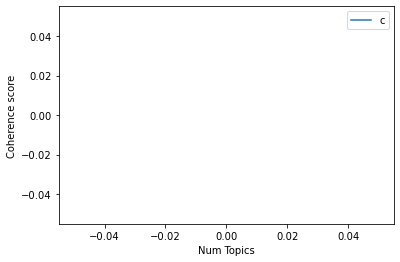

In [62]:
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [68]:
print(coherence_values)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [83]:
coherence_model_lda = models.CoherenceModel(model=lda, dictionary=d, texts=data_nouns_adj['lemmatized'].tolist(), coherence='c_v')
with np.errstate(invalid='ignore'):
    coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2021-02-23 10:34:06,383 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2021-02-23 10:34:07,338 : INFO : serializing accumulator to return to master...
2021-02-23 10:34:07,339 : INFO : serializing accumulator to return to master...
2021-02-23 10:34:07,339 : INFO : serializing accumulator to return to master...
2021-02-23 10:34:07,346 : INFO : accumulator serialized
2021-02-23 10:34:07,345 : INFO : accumulator serialized
2021-02-23 10:34:07,345 : INFO : accumulator serialized
2021-02-23 10:34:07,401 : INFO : 3 accumulators retrieved from output queue
2021-02-23 10:34:07,424 : INFO : accumulated word occurrence stats for 0 virtual documents



Coherence Score:  nan


In [17]:
df_ff =  df[df['cleaned'].str.contains("Welcome to Feedback Friday")]

In [18]:
df_ff.shape

(150, 6)

In [176]:
data_nouns_adj_ff = pd.DataFrame(df_ff['cleaned'].apply(nouns_adj))
data_nouns_adj_ff

cleaned
0    Jordan Harbinger Welcome Feedback Friday host ...
4    Jordan Harbinger Welcome Feedback Friday host ...
8    Jordan Harbinger Welcome Feedback Friday host ...
12   Jordan Harbinger Welcome Feedback Friday host ...
15   Jordan Harbinger Welcome Feedback Friday host ...
..                                                 ...
158  Feedback Friday host Jordan harbinger producer...
260  Feedback Friday host Jordan Harbinger producer...
291  Feedback Friday host Jordan Harbinger producer...
456  Feedback Friday host Jordan Harbinger producer...
457  Jordan Harbinger Welcome Feedback Friday host ...

[191 rows x 1 columns]

In [257]:
data_adj_ff = pd.DataFrame(df_ff['cleaned'].apply(_adj))
data_adj_ff

cleaned
0    Welcome advisory fascinating practical own ama...
4    Welcome — fascinating practical own amazing be...
8    Welcome fascinating practical own amazing bett...
12   Welcome fascinating practical own amazing bett...
15   Welcome fascinating practical own amazing bett...
..                                                 ...
158  silly certain actual same important interestin...
260  brilliant interesting practical own crucial he...
291  brilliant interesting practical own incredible...
456  brilliant interesting practical own storied mo...
457  Welcome fascinating practical own amazing bett...

[191 rows x 1 columns]

In [281]:
cvna = CountVectorizer(stop_words=stop_words, strip_accents='unicode',max_df=.40,min_df=10)
data_cvna = cvna.fit_transform(data_adj_ff.cleaned)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_adj_ff.index
data_dtmna

absolute  abstract  absurd  abusive  academic  accept  acceptable  \
0           0         0       0        0         0       0           0   
4           0         0       1        0         1       0           0   
8           0         0       0        0         0       0           0   
12          0         0       0        0         1       0           0   
15          0         0       0        0         1       0           0   
..        ...       ...     ...      ...       ...     ...         ...   
158         1         0       0        0         0       0           0   
260         0         0       0        0         0       0           0   
291         0         0       0        0         0       0           0   
456         0         0       0        0         0       0           0   
457         0         0       0        1         0       0           1   

     accessible  accountable  accurate  ...  wonderful  woo  work  working  \
0             1            2         0  ...          0    0     0        0   
4             0            0         0  ...          0    0     0        1   
8             0            0         0  ...          1    0     0        0   
12            0            0         0  ...          0    0     0        0   
15            0            0         1  ...          0    0     0        1   
..          ...          ...       ...  ...        ...  ...   ...      ...   
158           0            0         0  ...          0    0     1        0   
260           0            0         0  ...          0    0     0        0   
291           0            0         0  ...          2    0     0        1   
456           0            0         0  ...          1    0     0        1   
457           0            0         1  ...          0    0     0        0   

     world  worthless  worthwhile  worthy  yeah  youngest  
0        0          0           0       0     0         0  
4        1          0           0       0     0         0  
8        1          0           0       0     0         0  
12       0          0           0       0     1         0  
15       0          0           1       1     0         0  
..     ...        ...         ...     ...   ...       ...  
158      0          0           0       0     0         0  
260      0          0           0       0     0         0  
291      0          0           0       0     0         0  
456      0          0           0       0     0         0  
457      0          0           0       0     0         0  

[191 rows x 869 columns]

In [282]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [283]:
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=3, passes=50)
lda.print_topics()

2021-02-23 20:56:18,343 : INFO : using symmetric alpha at 0.3333333333333333
2021-02-23 20:56:18,345 : INFO : using symmetric eta at 0.3333333333333333
2021-02-23 20:56:18,347 : INFO : using serial LDA version on this node
2021-02-23 20:56:18,351 : INFO : running online (multi-pass) LDA training, 3 topics, 50 passes over the supplied corpus of 191 documents, updating model once every 191 documents, evaluating perplexity every 191 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-23 20:56:18,782 : INFO : -7.253 per-word bound, 152.5 perplexity estimate based on a held-out corpus of 191 documents with 30391 words
2021-02-23 20:56:18,783 : INFO : PROGRESS: pass 0, at document #191/191
2021-02-23 20:56:19,018 : INFO : topic #0 (0.333): 0.006*"italian" + 0.006*"criminal" + 0.006*"incredible" + 0.005*"guilty" + 0.005*"white" + 0.005*"dangerous" + 0.005*"fake" + 0.005*"meaningful" + 0.005*"live" + 0.004*"strange"
2021-02-23 20:56:19,019 : INFO : topic #1 (0.333): 0.006

2021-02-23 20:56:23,908 : INFO : -6.626 per-word bound, 98.7 perplexity estimate based on a held-out corpus of 191 documents with 30391 words
2021-02-23 20:56:23,909 : INFO : PROGRESS: pass 8, at document #191/191
2021-02-23 20:56:24,132 : INFO : topic #0 (0.333): 0.008*"italian" + 0.007*"criminal" + 0.007*"guilty" + 0.006*"incredible" + 0.006*"narcissistic" + 0.006*"white" + 0.005*"sexual" + 0.005*"physical" + 0.005*"sensitive" + 0.005*"strange"
2021-02-23 20:56:24,133 : INFO : topic #1 (0.333): 0.008*"generous" + 0.007*"creative" + 0.006*"life" + 0.006*"live" + 0.006*"middle" + 0.006*"sick" + 0.005*"productive" + 0.005*"make" + 0.005*"clean" + 0.005*"freaking"
2021-02-23 20:56:24,134 : INFO : topic #2 (0.333): 0.009*"dangerous" + 0.009*"miserable" + 0.008*"meaningful" + 0.007*"large" + 0.006*"fake" + 0.005*"average" + 0.005*"confident" + 0.005*"black" + 0.005*"half" + 0.005*"final"
2021-02-23 20:56:24,136 : INFO : topic diff=0.033483, rho=0.316228
2021-02-23 20:56:24,546 : INFO : -6.

2021-02-23 20:56:28,898 : INFO : topic #2 (0.333): 0.010*"dangerous" + 0.009*"miserable" + 0.008*"meaningful" + 0.007*"large" + 0.007*"fake" + 0.006*"average" + 0.006*"black" + 0.006*"final" + 0.005*"confident" + 0.005*"modern"
2021-02-23 20:56:28,898 : INFO : topic diff=0.019576, rho=0.235702
2021-02-23 20:56:29,290 : INFO : -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 191 documents with 30391 words
2021-02-23 20:56:29,290 : INFO : PROGRESS: pass 17, at document #191/191
2021-02-23 20:56:29,484 : INFO : topic #0 (0.333): 0.008*"italian" + 0.008*"guilty" + 0.007*"criminal" + 0.006*"incredible" + 0.006*"narcissistic" + 0.006*"sexual" + 0.006*"white" + 0.005*"physical" + 0.005*"secret" + 0.005*"sensitive"
2021-02-23 20:56:29,485 : INFO : topic #1 (0.333): 0.008*"generous" + 0.007*"life" + 0.007*"creative" + 0.006*"live" + 0.006*"middle" + 0.006*"sick" + 0.005*"dumb" + 0.005*"miserable" + 0.005*"productive" + 0.005*"freaking"
2021-02-23 20:56:29,486 : INFO

2021-02-23 20:56:33,874 : INFO : PROGRESS: pass 25, at document #191/191
2021-02-23 20:56:34,053 : INFO : topic #0 (0.333): 0.008*"italian" + 0.008*"guilty" + 0.008*"criminal" + 0.007*"incredible" + 0.006*"narcissistic" + 0.006*"sexual" + 0.006*"white" + 0.006*"physical" + 0.006*"military" + 0.005*"secret"
2021-02-23 20:56:34,054 : INFO : topic #1 (0.333): 0.007*"generous" + 0.007*"life" + 0.007*"live" + 0.007*"creative" + 0.006*"middle" + 0.006*"dumb" + 0.006*"miserable" + 0.006*"sick" + 0.005*"productive" + 0.005*"freaking"
2021-02-23 20:56:34,055 : INFO : topic #2 (0.333): 0.010*"dangerous" + 0.009*"meaningful" + 0.009*"miserable" + 0.007*"fake" + 0.007*"large" + 0.006*"average" + 0.006*"final" + 0.006*"black" + 0.006*"modern" + 0.006*"painful"
2021-02-23 20:56:34,057 : INFO : topic diff=0.013443, rho=0.192450
2021-02-23 20:56:34,416 : INFO : -6.611 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 191 documents with 30391 words
2021-02-23 20:56:34,417 : INFO : 

2021-02-23 20:56:38,372 : INFO : topic #2 (0.333): 0.011*"dangerous" + 0.009*"meaningful" + 0.008*"miserable" + 0.007*"fake" + 0.007*"large" + 0.006*"final" + 0.006*"average" + 0.006*"black" + 0.006*"modern" + 0.006*"painful"
2021-02-23 20:56:38,373 : INFO : topic diff=0.010326, rho=0.169031
2021-02-23 20:56:38,729 : INFO : -6.609 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 191 documents with 30391 words
2021-02-23 20:56:38,730 : INFO : PROGRESS: pass 34, at document #191/191
2021-02-23 20:56:38,903 : INFO : topic #0 (0.333): 0.008*"italian" + 0.008*"guilty" + 0.008*"criminal" + 0.007*"incredible" + 0.006*"narcissistic" + 0.006*"sexual" + 0.006*"military" + 0.006*"white" + 0.006*"physical" + 0.006*"sensitive"
2021-02-23 20:56:38,904 : INFO : topic #1 (0.333): 0.007*"generous" + 0.007*"life" + 0.006*"live" + 0.006*"creative" + 0.006*"middle" + 0.006*"miserable" + 0.006*"dumb" + 0.006*"sick" + 0.006*"productive" + 0.005*"freaking"
2021-02-23 20:56:38,905 : INFO

2021-02-23 20:56:43,149 : INFO : PROGRESS: pass 42, at document #191/191
2021-02-23 20:56:43,309 : INFO : topic #0 (0.333): 0.008*"italian" + 0.008*"guilty" + 0.008*"criminal" + 0.007*"incredible" + 0.006*"narcissistic" + 0.006*"sexual" + 0.006*"military" + 0.006*"white" + 0.006*"sensitive" + 0.006*"physical"
2021-02-23 20:56:43,310 : INFO : topic #1 (0.333): 0.007*"generous" + 0.007*"life" + 0.006*"live" + 0.006*"middle" + 0.006*"miserable" + 0.006*"creative" + 0.006*"dumb" + 0.006*"productive" + 0.005*"sick" + 0.005*"freaking"
2021-02-23 20:56:43,311 : INFO : topic #2 (0.333): 0.011*"dangerous" + 0.010*"meaningful" + 0.008*"miserable" + 0.007*"fake" + 0.007*"large" + 0.006*"final" + 0.006*"black" + 0.006*"average" + 0.006*"painful" + 0.006*"modern"
2021-02-23 20:56:43,311 : INFO : topic diff=0.008280, rho=0.150756
2021-02-23 20:56:43,654 : INFO : -6.607 per-word bound, 97.5 perplexity estimate based on a held-out corpus of 191 documents with 30391 words
2021-02-23 20:56:43,655 : INFO

[(0,
  '0.009*"italian" + 0.008*"guilty" + 0.008*"criminal" + 0.007*"incredible" + 0.007*"narcissistic" + 0.006*"sexual" + 0.006*"military" + 0.006*"white" + 0.006*"sensitive" + 0.006*"secret"'),
 (1,
  '0.007*"generous" + 0.007*"life" + 0.006*"miserable" + 0.006*"middle" + 0.006*"live" + 0.006*"creative" + 0.006*"dumb" + 0.006*"productive" + 0.005*"sick" + 0.005*"make"'),
 (2,
  '0.011*"dangerous" + 0.010*"meaningful" + 0.008*"miserable" + 0.007*"fake" + 0.007*"large" + 0.007*"final" + 0.006*"black" + 0.006*"average" + 0.006*"progressive" + 0.006*"painful"')]

In [15]:
df_int =  df[~df['cleaned'].str.contains("Welcome to Feedback Friday")]

In [ ]:
pdf_df , data_nouns_adj_int

In [16]:
df_nouns_adj_int = pd.DataFrame(df_int['cleaned'].apply(nouns_adj))
df_nouns_adj_int

cleaned
1    show Jordan Harbinger Jordan Harbinger Show st...
2    podcast Microsoft Teams more ways more ways te...
3    Jordan Harbinger Show whole approach things he...
5    Jordan Harbinger Welcome show Jordan Harbinger...
6    Jordan Harbinger Jordan Harbinger Show David M...
..                                                 ...
536  Full show notes https //theartofcharm.com/podc...
537  Full show notes https //theartofcharm.com// WI...
538  Full show notes https //theartofcharm.com/podc...
539  Full show notes https //theartofcharm.com/podc...
540  Full show notes https //theartofcharm.com// DA...

[391 rows x 1 columns]

In [35]:
aoc_nouns_adj_int = pd.DataFrame(pdf_df['cleaned'].apply(nouns_adj))
aoc_nouns_adj_int

cleaned
0   Full show notes https //theartofcharm.com// SR...
1   Full show notes https //theartofcharm.com// NI...
2   Full show notes https //theartofcharm.com// RO...
3   Full show notes https //theartofcharm.com// CH...
4   Full show notes https //theartofcharm.com// FR...
..                                                ...
62  Full show notes https //theartofcharm.com/podc...
63  Full show notes https //theartofcharm.com// WI...
64  Full show notes https //theartofcharm.com/podc...
65  Full show notes https //theartofcharm.com/podc...
66  Full show notes https //theartofcharm.com// DA...

[67 rows x 1 columns]

In [10]:
data_adj_int = pd.DataFrame(df_int['cleaned'].apply(_adj))
data_adj_int

cleaned
1    Jordan fascinating new in-depth occasional Nor...
2    more more top medical guilty few terrible wron...
3    whole helpful open huge more more Jordan fasci...
5    Welcome Jordan fascinating new in-depth practi...
6    iconic talcum present difficult hard same nati...
..                                                 ...
536  //theartofcharm.com/podcast-episodes/graeme-wo...
537  //theartofcharm.com// young same same ethic mu...
538  //theartofcharm.com/podcast-episodes/neal-bren...
539  //theartofcharm.com/podcast-episodes/vanessa-v...
540  super tiny little useful Welcome neuro best im...

[350 rows x 1 columns]

In [299]:
cvna = CountVectorizer(stop_words=stop_words, strip_accents='unicode',max_df=.45,min_df=10)
data_cvna = cvna.fit_transform(data_adj_int.cleaned)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_adj_int.index
data_dtmna

absolute  abstract  absurd  abusive  academic  accept  acceptable  \
1           0         0       0        0         0       0           0   
2           1         0       5        0         0       0           0   
3           0         2       0        0         0       0           0   
5           0         0       1        0         0       0           0   
6           0         0       0        0         1       0           0   
..        ...       ...     ...      ...       ...     ...         ...   
536         0         0       0        0         0       0           0   
537         0         0       0        0         0       0           0   
538         0         0       0        0         0       0           0   
539         0         0       0        0         0       0           0   
540         0         0       0        0         1       0           0   

     accessible  accidental  accomplished  ...  year  yellow  yes  yoga  youd  \
1             0           0             0  ...     0       0    0     0     0   
2             0           0             0  ...     0       0    0     0     0   
3             0           0             0  ...     0       0    0     0     0   
5             0           2             0  ...     3       0    0     0     0   
6             0           0             0  ...     1       0    0     0     0   
..          ...         ...           ...  ...   ...     ...  ...   ...   ...   
536           0           0             0  ...     0       0    0     0     1   
537           0           0             0  ...     0       0    0     0     0   
538           0           0             0  ...     0       0    0     0     1   
539           0           0             0  ...     0       0    0     0     3   
540           0           1             0  ...     0       0    1     0     0   

     youll  younger  youngest  zero  ziprecruiter  
1        0        0         0     0             0  
2        0        0         0     0             0  
3        0        3         0     0             0  
5        0        1         0     0             0  
6        0        0         1     0             0  
..     ...      ...       ...   ...           ...  
536      0        1         0     0             0  
537      0        3         1     0             0  
538      0        1         1     0             0  
539      0        1         0     0             0  
540      1        0         0     0             0  

[350 rows x 1568 columns]

In [300]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [302]:
#.45/10/4
#.40/15/4
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=4, passes=50)
lda.print_topics()

2021-02-23 21:33:45,360 : INFO : using symmetric alpha at 0.25
2021-02-23 21:33:45,363 : INFO : using symmetric eta at 0.25
2021-02-23 21:33:45,366 : INFO : using serial LDA version on this node
2021-02-23 21:33:45,368 : INFO : running online (multi-pass) LDA training, 4 topics, 50 passes over the supplied corpus of 350 documents, updating model once every 350 documents, evaluating perplexity every 350 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-23 21:33:46,226 : INFO : -7.885 per-word bound, 236.4 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:33:46,227 : INFO : PROGRESS: pass 0, at document #350/350
2021-02-23 21:33:46,583 : INFO : topic #0 (0.250): 0.007*"russian" + 0.007*"critical" + 0.006*"chinese" + 0.006*"political" + 0.005*"fake" + 0.005*"lucky" + 0.005*"military" + 0.005*"medical" + 0.004*"cognitive" + 0.004*"large"
2021-02-23 21:33:46,584 : INFO : topic #1 (0.250): 0.005*"physical" + 0.005*"beautifu

2021-02-23 21:33:53,515 : INFO : topic #2 (0.250): 0.009*"lucky" + 0.009*"fake" + 0.008*"live" + 0.007*"korean" + 0.006*"stupid" + 0.006*"rich" + 0.006*"grand" + 0.006*"beautiful" + 0.005*"worth" + 0.005*"uncomfortable"
2021-02-23 21:33:53,517 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"medical" + 0.005*"non" + 0.005*"extra" + 0.005*"worth" + 0.005*"hot" + 0.005*"healthy" + 0.005*"sudden" + 0.005*"expensive" + 0.004*"year"
2021-02-23 21:33:53,519 : INFO : topic diff=0.065708, rho=0.353553
2021-02-23 21:33:54,304 : INFO : -6.934 per-word bound, 122.3 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:33:54,304 : INFO : PROGRESS: pass 7, at document #350/350
2021-02-23 21:33:54,668 : INFO : topic #0 (0.250): 0.016*"russian" + 0.012*"chinese" + 0.012*"political" + 0.012*"military" + 0.008*"fake" + 0.008*"foreign" + 0.006*"critical" + 0.006*"global" + 0.005*"criminal" + 0.005*"private"
2021-02-23 21:33:54,669 : INFO : topic #1 (0.250): 0

2021-02-23 21:34:01,421 : INFO : topic #2 (0.250): 0.011*"lucky" + 0.008*"live" + 0.008*"stupid" + 0.007*"korean" + 0.007*"fake" + 0.007*"grand" + 0.007*"beautiful" + 0.007*"rich" + 0.006*"worth" + 0.006*"uncomfortable"
2021-02-23 21:34:01,422 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"medical" + 0.005*"extra" + 0.005*"hot" + 0.005*"non" + 0.005*"expensive" + 0.005*"worth" + 0.005*"year" + 0.005*"healthy" + 0.005*"sudden"
2021-02-23 21:34:01,423 : INFO : topic diff=0.037010, rho=0.258199
2021-02-23 21:34:02,182 : INFO : -6.920 per-word bound, 121.1 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:34:02,183 : INFO : PROGRESS: pass 14, at document #350/350
2021-02-23 21:34:02,528 : INFO : topic #0 (0.250): 0.017*"russian" + 0.013*"chinese" + 0.013*"military" + 0.013*"political" + 0.009*"fake" + 0.009*"foreign" + 0.007*"criminal" + 0.006*"global" + 0.006*"secret" + 0.006*"critical"
2021-02-23 21:34:02,529 : INFO : topic #1 (0.250): 0

2021-02-23 21:34:09,038 : INFO : topic #2 (0.250): 0.012*"lucky" + 0.008*"live" + 0.008*"stupid" + 0.008*"beautiful" + 0.007*"grand" + 0.007*"korean" + 0.007*"rich" + 0.006*"fake" + 0.006*"worth" + 0.006*"uncomfortable"
2021-02-23 21:34:09,038 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"medical" + 0.005*"year" + 0.005*"hot" + 0.005*"extra" + 0.005*"non" + 0.005*"expensive" + 0.005*"worth" + 0.005*"healthy" + 0.005*"sudden"
2021-02-23 21:34:09,039 : INFO : topic diff=0.024521, rho=0.213201
2021-02-23 21:34:09,806 : INFO : -6.914 per-word bound, 120.6 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:34:09,807 : INFO : PROGRESS: pass 21, at document #350/350
2021-02-23 21:34:10,132 : INFO : topic #0 (0.250): 0.017*"russian" + 0.014*"chinese" + 0.014*"military" + 0.014*"political" + 0.010*"fake" + 0.009*"foreign" + 0.007*"criminal" + 0.007*"secret" + 0.006*"global" + 0.006*"international"
2021-02-23 21:34:10,133 : INFO : topic #1 (0.25

2021-02-23 21:34:16,619 : INFO : topic #2 (0.250): 0.013*"lucky" + 0.009*"stupid" + 0.008*"live" + 0.008*"beautiful" + 0.008*"grand" + 0.007*"korean" + 0.006*"rich" + 0.006*"worth" + 0.006*"uncomfortable" + 0.006*"fake"
2021-02-23 21:34:16,619 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"medical" + 0.006*"year" + 0.005*"hot" + 0.005*"extra" + 0.005*"expensive" + 0.005*"non" + 0.005*"worth" + 0.005*"sudden" + 0.005*"sick"
2021-02-23 21:34:16,621 : INFO : topic diff=0.017968, rho=0.185695
2021-02-23 21:34:17,355 : INFO : -6.910 per-word bound, 120.3 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:34:17,356 : INFO : PROGRESS: pass 28, at document #350/350
2021-02-23 21:34:17,661 : INFO : topic #0 (0.250): 0.018*"russian" + 0.014*"chinese" + 0.014*"military" + 0.014*"political" + 0.010*"fake" + 0.009*"foreign" + 0.008*"criminal" + 0.007*"secret" + 0.006*"global" + 0.006*"international"
2021-02-23 21:34:17,661 : INFO : topic #1 (0.250):

2021-02-23 21:34:24,091 : INFO : topic #2 (0.250): 0.013*"lucky" + 0.009*"stupid" + 0.008*"beautiful" + 0.008*"live" + 0.008*"grand" + 0.007*"korean" + 0.006*"rich" + 0.006*"uncomfortable" + 0.006*"worth" + 0.005*"fake"
2021-02-23 21:34:24,092 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"year" + 0.006*"medical" + 0.005*"hot" + 0.005*"extra" + 0.005*"expensive" + 0.005*"non" + 0.005*"worth" + 0.005*"sick" + 0.005*"sudden"
2021-02-23 21:34:24,093 : INFO : topic diff=0.014001, rho=0.166667
2021-02-23 21:34:24,837 : INFO : -6.907 per-word bound, 120.0 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:34:24,838 : INFO : PROGRESS: pass 35, at document #350/350
2021-02-23 21:34:25,162 : INFO : topic #0 (0.250): 0.018*"russian" + 0.015*"chinese" + 0.014*"military" + 0.014*"political" + 0.011*"fake" + 0.010*"foreign" + 0.008*"criminal" + 0.007*"secret" + 0.006*"international" + 0.006*"global"
2021-02-23 21:34:25,163 : INFO : topic #1 (0.250):

2021-02-23 21:34:31,606 : INFO : topic #2 (0.250): 0.013*"lucky" + 0.009*"stupid" + 0.009*"beautiful" + 0.008*"live" + 0.008*"grand" + 0.007*"korean" + 0.006*"uncomfortable" + 0.006*"worth" + 0.006*"rich" + 0.006*"excited"
2021-02-23 21:34:31,607 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"year" + 0.006*"medical" + 0.005*"hot" + 0.005*"extra" + 0.005*"expensive" + 0.005*"worth" + 0.005*"non" + 0.005*"sudden" + 0.005*"sick"
2021-02-23 21:34:31,608 : INFO : topic diff=0.011217, rho=0.152499
2021-02-23 21:34:32,344 : INFO : -6.906 per-word bound, 119.9 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:34:32,344 : INFO : PROGRESS: pass 42, at document #350/350
2021-02-23 21:34:32,664 : INFO : topic #0 (0.250): 0.018*"russian" + 0.015*"chinese" + 0.015*"military" + 0.014*"political" + 0.011*"fake" + 0.010*"foreign" + 0.008*"criminal" + 0.007*"secret" + 0.007*"international" + 0.006*"global"
2021-02-23 21:34:32,665 : INFO : topic #1 (0.25

2021-02-23 21:34:39,110 : INFO : topic #2 (0.250): 0.014*"lucky" + 0.009*"stupid" + 0.009*"beautiful" + 0.008*"live" + 0.008*"grand" + 0.007*"korean" + 0.006*"uncomfortable" + 0.006*"worth" + 0.006*"rich" + 0.006*"excited"
2021-02-23 21:34:39,113 : INFO : topic #3 (0.250): 0.013*"creative" + 0.006*"year" + 0.006*"medical" + 0.005*"hot" + 0.005*"expensive" + 0.005*"extra" + 0.005*"worth" + 0.005*"non" + 0.005*"sudden" + 0.005*"day"
2021-02-23 21:34:39,114 : INFO : topic diff=0.009300, rho=0.141421
2021-02-23 21:34:39,849 : INFO : -6.904 per-word bound, 119.8 perplexity estimate based on a held-out corpus of 350 documents with 83652 words
2021-02-23 21:34:39,849 : INFO : PROGRESS: pass 49, at document #350/350
2021-02-23 21:34:40,173 : INFO : topic #0 (0.250): 0.018*"russian" + 0.015*"chinese" + 0.015*"military" + 0.014*"political" + 0.011*"fake" + 0.010*"foreign" + 0.008*"criminal" + 0.007*"secret" + 0.007*"international" + 0.006*"global"
2021-02-23 21:34:40,174 : INFO : topic #1 (0.250

[(0,
  '0.018*"russian" + 0.015*"chinese" + 0.015*"military" + 0.014*"political" + 0.011*"fake" + 0.010*"foreign" + 0.008*"criminal" + 0.007*"secret" + 0.007*"international" + 0.006*"global"'),
 (1,
  '0.011*"cognitive" + 0.010*"physical" + 0.008*"angry" + 0.007*"nonverbal" + 0.007*"conscious" + 0.006*"uncomfortable" + 0.006*"internal" + 0.006*"helpful" + 0.006*"healthy" + 0.005*"psychological"'),
 (2,
  '0.014*"lucky" + 0.009*"stupid" + 0.009*"beautiful" + 0.008*"live" + 0.008*"grand" + 0.007*"korean" + 0.006*"uncomfortable" + 0.006*"worth" + 0.006*"rich" + 0.006*"excited"'),
 (3,
  '0.013*"creative" + 0.006*"year" + 0.006*"medical" + 0.005*"hot" + 0.005*"expensive" + 0.005*"extra" + 0.005*"worth" + 0.005*"non" + 0.005*"day" + 0.005*"sudden"')]

In [191]:
cvna = CountVectorizer(stop_words=stop_words, strip_accents='unicode',max_df=.4,min_df=10)
data_cvna = cvna.fit_transform(data_nouns_adj_ff.cleaned)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj_ff.index
data_dtmna

abilities  absence  absolute  abstract  absurd  abuse  abusive  academic  \
0            0        0         0         0       0      0        0         0   
4            0        0         0         0       1      0        0         1   
8            0        0         0         0       0      0        0         0   
12           0        0         0         0       0      0        0         1   
15           0        0         0         0       0      1        0         1   
..         ...      ...       ...       ...     ...    ...      ...       ...   
158          0        0         1         0       0      0        0         0   
260          1        0         0         0       0      0        0         0   
291          0        0         0         0       0      0        0         0   
456          0        0         0         0       0      1        0         0   
457          0        0         0         0       0      3        1         0   

     accent  accept  ...  yesterday  yikes  yoga  youngest  youth  yup  zero  \
0         0       0  ...          0      2     0         0      0    0     0   
4         0       0  ...          0      2     0         0      0    0     0   
8         0       0  ...          1      0     0         0      1    0     1   
12        0       0  ...          0      0     0         0      0    0     0   
15        0       1  ...          0      0     0         0      0    0     0   
..      ...     ...  ...        ...    ...   ...       ...    ...  ...   ...   
158       0       0  ...          0      0     0         0      1    0     0   
260       0       0  ...          0      0     0         0      0    0     0   
291       0       0  ...          1      0     0         0      0    0     0   
456       0       0  ...          0      0     0         0      0    4     0   
457       0       0  ...          0      0     0         0      3    0     0   

     zone  zoom  zuckerberg  
0       1     0           0  
4       0     1           0  
8       0     1           0  
12      0     0           0  
15      0     0           0  
..    ...   ...         ...  
158     0     0           0  
260     0     0           0  
291     0     0           0  
456     1     0           0  
457     0     0           1  

[191 rows x 3460 columns]

In [69]:
#.35/15 ~/.4/15
cvna = CountVectorizer(stop_words=stop_words, strip_accents='unicode',max_df=.35,min_df=15)
data_cvna = cvna.fit_transform(df_nouns_adj_int.cleaned)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = df_nouns_adj_int.index
data_dtmna

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


abilities  absence  absolute  abstract  absurd  abuse  abusive  academia  \
1            0        0         0         0       0      0        0         0   
2            0        0         1         0       5      1        0         1   
3            2        0         1         2       0      0        0         0   
5            0        0         0         0       1      0        0         0   
6            0        0         0         0       0      0        0         1   
..         ...      ...       ...       ...     ...    ...      ...       ...   
536          0        0         0         0       0      0        0         0   
537          0        0         0         0       0      0        0         0   
538          0        0         0         0       0      0        0         0   
539          0        0         0         0       0      0        0         2   
540          0        0         0         0       0      0        0         0   

     academic  academics  ...  youngest  youth  yup  zealand  zero  zip  \
1           0          0  ...         0      1    0        0     0    0   
2           0          1  ...         0      0    0        0     0    0   
3           0          0  ...         0      0    0        0     0    1   
5           0          0  ...         0      1    0        0     1    0   
6           1          0  ...         1      0    0        0     0    0   
..        ...        ...  ...       ...    ...  ...      ...   ...  ...   
536         0          0  ...         0      0    0        0     0    0   
537         0          0  ...         1      0    0        0     0    0   
538         0          0  ...         1      0    0        0     0    0   
539         0          0  ...         0      1    0        0     0    0   
540         1          0  ...         0      0    0        0     0    0   

     zombie  zone  zoom  zuckerberg  
1         0     3     0           0  
2         0     0     0           0  
3         0     0     0           0  
5         0     0     0           0  
6         0     0     0           0  
..      ...   ...   ...         ...  
536       0     0     0           0  
537       0     1     0           0  
538       0     0     0           0  
539       0     1     0           0  
540       4     0     0           0  

[391 rows x 4686 columns]

In [100]:
#.4/15
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=5, passes=100,random_state=88)
lda.print_topics()

2021-02-24 16:05:36,790 : INFO : using symmetric alpha at 0.2
2021-02-24 16:05:36,791 : INFO : using symmetric eta at 0.2
2021-02-24 16:05:36,794 : INFO : using serial LDA version on this node
2021-02-24 16:05:36,802 : INFO : running online (multi-pass) LDA training, 5 topics, 100 passes over the supplied corpus of 350 documents, updating model once every 350 documents, evaluating perplexity every 350 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-24 16:05:40,091 : INFO : -8.918 per-word bound, 483.6 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:05:40,094 : INFO : PROGRESS: pass 0, at document #350/350
2021-02-24 16:05:41,234 : INFO : topic #0 (0.200): 0.004*"prison" + 0.004*"china" + 0.003*"north" + 0.003*"emotions" + 0.002*"korea" + 0.002*"gold" + 0.002*"drug" + 0.002*"countries" + 0.002*"president" + 0.002*"drugs"
2021-02-24 16:05:41,236 : INFO : topic #1 (0.200): 0.002*"prison" + 0.002*"drugs" + 0.002*"evi

2021-02-24 16:05:56,350 : INFO : topic #3 (0.200): 0.008*"russia" + 0.005*"russian" + 0.004*"patent" + 0.004*"soviet" + 0.004*"putin" + 0.003*"election" + 0.003*"chess" + 0.003*"scientists" + 0.003*"china" + 0.003*"machine"
2021-02-24 16:05:56,352 : INFO : topic #4 (0.200): 0.005*"sleep" + 0.005*"creative" + 0.003*"china" + 0.002*"moments" + 0.002*"creativity" + 0.002*"chase" + 0.002*"coffee" + 0.002*"gift" + 0.002*"apple" + 0.002*"movies"
2021-02-24 16:05:56,353 : INFO : topic diff=0.079560, rho=0.377964
2021-02-24 16:05:58,451 : INFO : -8.042 per-word bound, 263.5 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:05:58,452 : INFO : PROGRESS: pass 6, at document #350/350
2021-02-24 16:05:59,062 : INFO : topic #0 (0.200): 0.009*"prison" + 0.008*"china" + 0.007*"north" + 0.006*"korea" + 0.004*"chinese" + 0.004*"drug" + 0.004*"gold" + 0.004*"police" + 0.004*"drugs" + 0.004*"crime"
2021-02-24 16:05:59,063 : INFO : topic #1 (0.200): 0.002*"come

2021-02-24 16:06:13,053 : INFO : topic #3 (0.200): 0.010*"russia" + 0.006*"russian" + 0.004*"putin" + 0.004*"patent" + 0.004*"soviet" + 0.004*"election" + 0.004*"china" + 0.004*"ai" + 0.004*"machine" + 0.004*"chess"
2021-02-24 16:06:13,055 : INFO : topic #4 (0.200): 0.005*"sleep" + 0.005*"creative" + 0.003*"moments" + 0.003*"creativity" + 0.002*"coffee" + 0.002*"chase" + 0.002*"videos" + 0.002*"gift" + 0.002*"camera" + 0.002*"apple"
2021-02-24 16:06:13,057 : INFO : topic diff=0.048800, rho=0.277350
2021-02-24 16:06:15,097 : INFO : -8.017 per-word bound, 259.1 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:06:15,098 : INFO : PROGRESS: pass 12, at document #350/350
2021-02-24 16:06:15,688 : INFO : topic #0 (0.200): 0.010*"prison" + 0.008*"china" + 0.008*"north" + 0.007*"korea" + 0.005*"chinese" + 0.004*"police" + 0.004*"drug" + 0.004*"military" + 0.004*"drugs" + 0.004*"gold"
2021-02-24 16:06:15,689 : INFO : topic #1 (0.200): 0.003*"comedy"

2021-02-24 16:06:29,434 : INFO : topic #3 (0.200): 0.011*"russia" + 0.007*"russian" + 0.005*"putin" + 0.005*"soviet" + 0.005*"patent" + 0.004*"election" + 0.004*"china" + 0.004*"ai" + 0.004*"machine" + 0.004*"chess"
2021-02-24 16:06:29,436 : INFO : topic #4 (0.200): 0.005*"creative" + 0.005*"sleep" + 0.003*"moments" + 0.003*"coffee" + 0.003*"creativity" + 0.003*"videos" + 0.002*"chase" + 0.002*"gift" + 0.002*"camera" + 0.002*"apple"
2021-02-24 16:06:29,439 : INFO : topic diff=0.035149, rho=0.229416
2021-02-24 16:06:31,520 : INFO : -8.008 per-word bound, 257.3 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:06:31,520 : INFO : PROGRESS: pass 18, at document #350/350
2021-02-24 16:06:32,092 : INFO : topic #0 (0.200): 0.010*"prison" + 0.009*"china" + 0.008*"north" + 0.007*"korea" + 0.005*"chinese" + 0.005*"police" + 0.004*"military" + 0.004*"drug" + 0.004*"drugs" + 0.004*"gold"
2021-02-24 16:06:32,094 : INFO : topic #1 (0.200): 0.003*"comedy"

2021-02-24 16:06:46,399 : INFO : topic #3 (0.200): 0.011*"russia" + 0.007*"russian" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"china" + 0.005*"election" + 0.004*"ai" + 0.004*"machine" + 0.004*"chess"
2021-02-24 16:06:46,402 : INFO : topic #4 (0.200): 0.005*"creative" + 0.005*"sleep" + 0.003*"moments" + 0.003*"coffee" + 0.003*"videos" + 0.003*"creativity" + 0.002*"chase" + 0.002*"gift" + 0.002*"boss" + 0.002*"camera"
2021-02-24 16:06:46,403 : INFO : topic diff=0.026593, rho=0.200000
2021-02-24 16:06:51,771 : INFO : -8.002 per-word bound, 256.3 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:06:51,775 : INFO : PROGRESS: pass 24, at document #350/350
2021-02-24 16:06:52,830 : INFO : topic #0 (0.200): 0.010*"prison" + 0.009*"china" + 0.008*"north" + 0.007*"korea" + 0.005*"chinese" + 0.005*"police" + 0.004*"military" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi"
2021-02-24 16:06:52,831 : INFO : topic #1 (0.200): 0.003*"comedy" +

2021-02-24 16:07:09,011 : INFO : topic #3 (0.200): 0.012*"russia" + 0.007*"russian" + 0.005*"china" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.004*"ai" + 0.004*"machine" + 0.004*"president"
2021-02-24 16:07:09,013 : INFO : topic #4 (0.200): 0.005*"creative" + 0.004*"sleep" + 0.003*"moments" + 0.003*"coffee" + 0.003*"videos" + 0.002*"creativity" + 0.002*"boss" + 0.002*"gift" + 0.002*"google" + 0.002*"chase"
2021-02-24 16:07:09,015 : INFO : topic diff=0.021023, rho=0.179605
2021-02-24 16:07:12,479 : INFO : -7.998 per-word bound, 255.7 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:07:12,480 : INFO : PROGRESS: pass 30, at document #350/350
2021-02-24 16:07:13,082 : INFO : topic #0 (0.200): 0.010*"prison" + 0.009*"china" + 0.008*"north" + 0.007*"korea" + 0.005*"chinese" + 0.005*"police" + 0.004*"military" + 0.004*"drug" + 0.004*"fbi" + 0.004*"drugs"
2021-02-24 16:07:13,083 : INFO : topic #1 (0.200): 0.003*"comed

2021-02-24 16:07:26,447 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.006*"china" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.004*"president" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 16:07:26,449 : INFO : topic #4 (0.200): 0.005*"creative" + 0.004*"sleep" + 0.003*"coffee" + 0.003*"moments" + 0.003*"videos" + 0.003*"boss" + 0.002*"google" + 0.002*"creativity" + 0.002*"gift" + 0.002*"chase"
2021-02-24 16:07:26,450 : INFO : topic diff=0.017276, rho=0.164399
2021-02-24 16:07:28,548 : INFO : -7.996 per-word bound, 255.3 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:07:28,548 : INFO : PROGRESS: pass 36, at document #350/350
2021-02-24 16:07:29,139 : INFO : topic #0 (0.200): 0.010*"prison" + 0.009*"china" + 0.008*"north" + 0.007*"korea" + 0.005*"chinese" + 0.005*"police" + 0.004*"military" + 0.004*"drug" + 0.004*"fbi" + 0.004*"drugs"
2021-02-24 16:07:29,140 : INFO : topic #1 (0.200): 0.004*"co

2021-02-24 16:07:44,351 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.006*"china" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"president" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 16:07:44,352 : INFO : topic #4 (0.200): 0.005*"creative" + 0.004*"sleep" + 0.003*"coffee" + 0.003*"moments" + 0.003*"boss" + 0.003*"videos" + 0.002*"google" + 0.002*"creativity" + 0.002*"gift" + 0.002*"chase"
2021-02-24 16:07:44,354 : INFO : topic diff=0.014553, rho=0.152499
2021-02-24 16:07:46,379 : INFO : -7.994 per-word bound, 254.9 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:07:46,379 : INFO : PROGRESS: pass 42, at document #350/350
2021-02-24 16:07:46,947 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"china" + 0.009*"north" + 0.007*"korea" + 0.005*"police" + 0.005*"chinese" + 0.004*"military" + 0.004*"drug" + 0.004*"fbi" + 0.004*"drugs"
2021-02-24 16:07:46,948 : INFO : topic #1 (0.200): 0.004*"co

2021-02-24 16:08:02,061 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.006*"china" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"president" + 0.005*"election" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 16:08:02,062 : INFO : topic #4 (0.200): 0.005*"creative" + 0.003*"sleep" + 0.003*"coffee" + 0.003*"boss" + 0.003*"moments" + 0.003*"videos" + 0.002*"google" + 0.002*"creativity" + 0.002*"gift" + 0.002*"feedback"
2021-02-24 16:08:02,064 : INFO : topic diff=0.012463, rho=0.142857
2021-02-24 16:08:04,310 : INFO : -7.992 per-word bound, 254.6 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:08:04,311 : INFO : PROGRESS: pass 48, at document #350/350
2021-02-24 16:08:04,968 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.009*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"chinese" + 0.004*"military" + 0.004*"drug" + 0.004*"fbi" + 0.004*"drugs"
2021-02-24 16:08:04,969 : INFO : topic #1 (0.200): 0.004*

2021-02-24 16:08:19,168 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.006*"china" + 0.005*"soviet" + 0.005*"putin" + 0.005*"president" + 0.005*"patent" + 0.005*"election" + 0.004*"conspiracy" + 0.004*"ai"
2021-02-24 16:08:19,170 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"sleep" + 0.003*"boss" + 0.003*"coffee" + 0.003*"moments" + 0.003*"videos" + 0.003*"google" + 0.002*"creativity" + 0.002*"gift" + 0.002*"feedback"
2021-02-24 16:08:19,172 : INFO : topic diff=0.010793, rho=0.134840
2021-02-24 16:08:21,331 : INFO : -7.991 per-word bound, 254.4 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:08:21,331 : INFO : PROGRESS: pass 54, at document #350/350
2021-02-24 16:08:21,947 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"chinese" + 0.005*"drug" + 0.005*"military" + 0.004*"fbi" + 0.004*"drugs"
2021-02-24 16:08:21,949 : INFO : topic #1 (0.200): 0.004*

2021-02-24 16:08:36,817 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.007*"china" + 0.005*"soviet" + 0.005*"president" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.004*"conspiracy" + 0.004*"ai"
2021-02-24 16:08:36,818 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"sleep" + 0.003*"coffee" + 0.003*"moments" + 0.003*"google" + 0.003*"videos" + 0.002*"gift" + 0.002*"feedback" + 0.002*"creativity"
2021-02-24 16:08:36,819 : INFO : topic diff=0.009457, rho=0.128037
2021-02-24 16:08:39,009 : INFO : -7.990 per-word bound, 254.2 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:08:39,010 : INFO : PROGRESS: pass 60, at document #350/350
2021-02-24 16:08:39,622 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"chinese" + 0.005*"drug" + 0.005*"military" + 0.004*"fbi" + 0.004*"drugs"
2021-02-24 16:08:39,623 : INFO : topic #1 (0.200): 0.004*

2021-02-24 16:08:55,825 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.007*"china" + 0.006*"president" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.004*"conspiracy" + 0.004*"ai"
2021-02-24 16:08:55,829 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"sleep" + 0.003*"moments" + 0.003*"google" + 0.002*"videos" + 0.002*"feedback" + 0.002*"gift" + 0.002*"creativity"
2021-02-24 16:08:55,831 : INFO : topic diff=0.008399, rho=0.122169
2021-02-24 16:08:58,037 : INFO : -7.989 per-word bound, 254.1 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:08:58,037 : INFO : PROGRESS: pass 66, at document #350/350
2021-02-24 16:08:58,638 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"chinese" + 0.005*"drug" + 0.005*"military" + 0.004*"drugs" + 0.004*"fbi"
2021-02-24 16:08:58,639 : INFO : topic #1 (0.200): 0.004*

2021-02-24 16:09:12,416 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.007*"china" + 0.006*"president" + 0.005*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"conspiracy" + 0.004*"ai"
2021-02-24 16:09:12,419 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"sleep" + 0.003*"moments" + 0.003*"google" + 0.002*"videos" + 0.002*"feedback" + 0.002*"gift" + 0.002*"creativity"
2021-02-24 16:09:12,421 : INFO : topic diff=0.007550, rho=0.117041
2021-02-24 16:09:14,541 : INFO : -7.988 per-word bound, 254.0 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:09:14,541 : INFO : PROGRESS: pass 72, at document #350/350
2021-02-24 16:09:15,127 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"drug" + 0.005*"chinese" + 0.005*"military" + 0.004*"drugs" + 0.004*"fbi"
2021-02-24 16:09:15,128 : INFO : topic #1 (0.200): 0.004*

2021-02-24 16:09:28,780 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.008*"china" + 0.006*"president" + 0.006*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"conspiracy" + 0.004*"ai"
2021-02-24 16:09:28,782 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"google" + 0.003*"moments" + 0.002*"videos" + 0.002*"sleep" + 0.002*"feedback" + 0.002*"gift" + 0.002*"creativity"
2021-02-24 16:09:28,784 : INFO : topic diff=0.006849, rho=0.112509
2021-02-24 16:09:30,884 : INFO : -7.988 per-word bound, 253.8 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:09:30,885 : INFO : PROGRESS: pass 78, at document #350/350
2021-02-24 16:09:31,505 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"drug" + 0.005*"chinese" + 0.005*"drugs" + 0.005*"military" + 0.004*"fbi"
2021-02-24 16:09:31,506 : INFO : topic #1 (0.200): 0.004*

2021-02-24 16:09:45,948 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"russian" + 0.008*"china" + 0.006*"president" + 0.006*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"conspiracy" + 0.004*"political"
2021-02-24 16:09:45,949 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"google" + 0.003*"moments" + 0.002*"videos" + 0.002*"feedback" + 0.002*"sleep" + 0.002*"gift" + 0.002*"creativity"
2021-02-24 16:09:45,950 : INFO : topic diff=0.006252, rho=0.108465
2021-02-24 16:09:48,138 : INFO : -7.987 per-word bound, 253.8 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:09:48,139 : INFO : PROGRESS: pass 84, at document #350/350
2021-02-24 16:09:48,747 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"drug" + 0.005*"drugs" + 0.005*"fbi" + 0.005*"military" + 0.004*"chinese"
2021-02-24 16:09:48,748 : INFO : topic #1 (0.200):

2021-02-24 16:10:02,319 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"china" + 0.008*"russian" + 0.006*"president" + 0.006*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"conspiracy" + 0.004*"political"
2021-02-24 16:10:02,320 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"google" + 0.003*"moments" + 0.002*"videos" + 0.002*"feedback" + 0.002*"gift" + 0.002*"creativity" + 0.002*"sleep"
2021-02-24 16:10:02,321 : INFO : topic diff=0.005737, rho=0.104828
2021-02-24 16:10:04,442 : INFO : -7.987 per-word bound, 253.7 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:10:04,442 : INFO : PROGRESS: pass 90, at document #350/350
2021-02-24 16:10:05,035 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"drug" + 0.005*"drugs" + 0.005*"fbi" + 0.004*"military" + 0.004*"chinese"
2021-02-24 16:10:05,036 : INFO : topic #1 (0.200):

2021-02-24 16:10:21,830 : INFO : topic #3 (0.200): 0.012*"russia" + 0.008*"china" + 0.008*"russian" + 0.006*"president" + 0.006*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"conspiracy" + 0.004*"political"
2021-02-24 16:10:21,831 : INFO : topic #4 (0.200): 0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"google" + 0.002*"moments" + 0.002*"videos" + 0.002*"feedback" + 0.002*"gift" + 0.002*"creativity" + 0.002*"employees"
2021-02-24 16:10:21,833 : INFO : topic diff=0.005288, rho=0.101535
2021-02-24 16:10:23,909 : INFO : -7.986 per-word bound, 253.6 perplexity estimate based on a held-out corpus of 350 documents with 353748 words
2021-02-24 16:10:23,910 : INFO : PROGRESS: pass 96, at document #350/350
2021-02-24 16:10:24,489 : INFO : topic #0 (0.200): 0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"drug" + 0.005*"drugs" + 0.005*"fbi" + 0.004*"military" + 0.004*"crime"
2021-02-24 16:10:24,490 : INFO : topic #1 (0.200

[(0,
  '0.011*"prison" + 0.009*"north" + 0.008*"china" + 0.007*"korea" + 0.005*"police" + 0.005*"drug" + 0.005*"drugs" + 0.005*"fbi" + 0.004*"military" + 0.004*"crime"'),
 (1,
  '0.004*"comedy" + 0.004*"poker" + 0.003*"charm" + 0.003*"stage" + 0.003*"ego" + 0.003*"dog" + 0.003*"radio" + 0.002*"fight" + 0.002*"song" + 0.002*"brother"'),
 (2,
  '0.006*"emotions" + 0.005*"bias" + 0.004*"sleep" + 0.004*"brains" + 0.004*"response" + 0.004*"evidence" + 0.003*"cognitive" + 0.003*"studies" + 0.003*"memory" + 0.003*"disease"'),
 (3,
  '0.012*"russia" + 0.008*"china" + 0.008*"russian" + 0.006*"president" + 0.006*"soviet" + 0.005*"putin" + 0.005*"patent" + 0.005*"election" + 0.005*"conspiracy" + 0.004*"political"'),
 (4,
  '0.004*"creative" + 0.003*"boss" + 0.003*"coffee" + 0.003*"google" + 0.002*"moments" + 0.002*"videos" + 0.002*"feedback" + 0.002*"gift" + 0.002*"creativity" + 0.002*"employees"')]

In [109]:
#.35/15
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=5, passes=250,random_state=88)
lda.print_topics()

2021-02-24 16:40:34,848 : INFO : using symmetric alpha at 0.2
2021-02-24 16:40:34,853 : INFO : using symmetric eta at 0.2
2021-02-24 16:40:34,859 : INFO : using serial LDA version on this node
2021-02-24 16:40:34,863 : INFO : running online (multi-pass) LDA training, 5 topics, 250 passes over the supplied corpus of 350 documents, updating model once every 350 documents, evaluating perplexity every 350 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-24 16:40:36,958 : INFO : -8.893 per-word bound, 475.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:40:36,959 : INFO : PROGRESS: pass 0, at document #350/350
2021-02-24 16:40:37,598 : INFO : topic #0 (0.200): 0.004*"prison" + 0.003*"north" + 0.003*"emotions" + 0.003*"intelligence" + 0.003*"korea" + 0.002*"russia" + 0.002*"china" + 0.002*"comedy" + 0.002*"leaders" + 0.002*"leader"
2021-02-24 16:40:37,599 : INFO : topic #1 (0.200): 0.003*"china" + 0.002*"military" + 0.

2021-02-24 16:40:50,919 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"drugs" + 0.003*"sand" + 0.003*"drug" + 0.002*"memory" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"identity" + 0.002*"behaviors"
2021-02-24 16:40:50,921 : INFO : topic #4 (0.200): 0.012*"china" + 0.007*"russia" + 0.006*"chinese" + 0.005*"russian" + 0.005*"gold" + 0.004*"president" + 0.004*"intelligence" + 0.004*"countries" + 0.004*"soviet" + 0.003*"putin"
2021-02-24 16:40:50,923 : INFO : topic diff=0.078749, rho=0.377964
2021-02-24 16:40:52,874 : INFO : -8.046 per-word bound, 264.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:40:52,874 : INFO : PROGRESS: pass 6, at document #350/350
2021-02-24 16:40:53,453 : INFO : topic #0 (0.200): 0.009*"prison" + 0.006*"north" + 0.005*"korea" + 0.003*"emotions" + 0.003*"comedy" + 0.003*"shit" + 0.002*"cia" + 0.002*"jail" + 0.002*"cell" + 0.002*"intelligence"
2021-02-24 16:40:53,454 : INFO : topic #1 (0.200): 0.003*

2021-02-24 16:41:06,001 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.003*"drugs" + 0.002*"mindset" + 0.002*"habit" + 0.002*"gym" + 0.002*"memory" + 0.002*"drug" + 0.002*"identity" + 0.002*"entrepreneur"
2021-02-24 16:41:06,003 : INFO : topic #4 (0.200): 0.014*"china" + 0.010*"russia" + 0.007*"chinese" + 0.006*"russian" + 0.006*"intelligence" + 0.005*"countries" + 0.005*"gold" + 0.005*"president" + 0.005*"soviet" + 0.004*"military"
2021-02-24 16:41:06,006 : INFO : topic diff=0.052266, rho=0.277350
2021-02-24 16:41:07,930 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:41:07,931 : INFO : PROGRESS: pass 12, at document #350/350
2021-02-24 16:41:08,501 : INFO : topic #0 (0.200): 0.010*"prison" + 0.006*"north" + 0.005*"korea" + 0.003*"comedy" + 0.003*"shit" + 0.003*"jail" + 0.003*"drugs" + 0.003*"fbi" + 0.002*"hotel" + 0.002*"girl"
2021-02-24 16:41:08,502 : INFO : topic #1 (0.200): 0.004*"em

2021-02-24 16:41:21,078 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.003*"mindset" + 0.002*"drugs" + 0.002*"habit" + 0.002*"gym" + 0.002*"memory" + 0.002*"entrepreneur" + 0.002*"identity" + 0.002*"apple"
2021-02-24 16:41:21,081 : INFO : topic #4 (0.200): 0.015*"china" + 0.010*"russia" + 0.008*"chinese" + 0.007*"intelligence" + 0.007*"russian" + 0.006*"countries" + 0.005*"president" + 0.005*"military" + 0.005*"gold" + 0.005*"soviet"
2021-02-24 16:41:21,083 : INFO : topic diff=0.038444, rho=0.229416
2021-02-24 16:41:22,999 : INFO : -7.999 per-word bound, 255.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:41:23,000 : INFO : PROGRESS: pass 18, at document #350/350
2021-02-24 16:41:23,567 : INFO : topic #0 (0.200): 0.011*"prison" + 0.007*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"fbi" + 0.003*"drug" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:41:23,569 : INFO : topic #1 (0.200): 0.005*"e

2021-02-24 16:41:36,348 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"mindset" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"drugs" + 0.002*"memory" + 0.002*"identity" + 0.002*"apple"
2021-02-24 16:41:36,350 : INFO : topic #4 (0.200): 0.016*"china" + 0.010*"russia" + 0.008*"chinese" + 0.007*"intelligence" + 0.007*"russian" + 0.006*"countries" + 0.006*"military" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:41:36,351 : INFO : topic diff=0.029216, rho=0.200000
2021-02-24 16:41:38,291 : INFO : -7.992 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:41:38,291 : INFO : PROGRESS: pass 24, at document #350/350
2021-02-24 16:41:38,869 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"drug" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:41:38,870 : INFO : topic #1 (0.200): 0.006*"emot

2021-02-24 16:41:52,111 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"employees" + 0.002*"apple" + 0.002*"memory"
2021-02-24 16:41:52,113 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.006*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:41:52,114 : INFO : topic diff=0.022983, rho=0.179605
2021-02-24 16:41:54,125 : INFO : -7.987 per-word bound, 253.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:41:54,126 : INFO : PROGRESS: pass 30, at document #350/350
2021-02-24 16:41:54,711 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"drug" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:41:54,712 : INFO : topic #1 (0.200): 0.006*"emo

2021-02-24 16:42:07,533 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"employees" + 0.002*"apple" + 0.002*"marketing"
2021-02-24 16:42:07,535 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.006*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:42:07,536 : INFO : topic diff=0.018779, rho=0.164399
2021-02-24 16:42:09,449 : INFO : -7.984 per-word bound, 253.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:42:09,450 : INFO : PROGRESS: pass 36, at document #350/350
2021-02-24 16:42:10,111 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:42:10,112 : INFO : topic #1 (0.200): 0.006*"

2021-02-24 16:42:24,570 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"employees" + 0.002*"gift" + 0.002*"marketing"
2021-02-24 16:42:24,572 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:42:24,574 : INFO : topic diff=0.015817, rho=0.152499
2021-02-24 16:42:26,962 : INFO : -7.981 per-word bound, 252.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:42:26,962 : INFO : PROGRESS: pass 42, at document #350/350
2021-02-24 16:42:27,525 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:42:27,526 : INFO : topic #1 (0.200): 0.006*"e

2021-02-24 16:42:40,594 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"gift" + 0.002*"employees" + 0.002*"sales"
2021-02-24 16:42:40,595 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:42:40,596 : INFO : topic diff=0.013676, rho=0.142857
2021-02-24 16:42:42,555 : INFO : -7.979 per-word bound, 252.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:42:42,556 : INFO : PROGRESS: pass 48, at document #350/350
2021-02-24 16:42:43,115 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:42:43,116 : INFO : topic #1 (0.200): 0.006*"emoti

2021-02-24 16:42:55,770 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"gift" + 0.002*"employees" + 0.002*"creativity"
2021-02-24 16:42:55,772 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:42:55,773 : INFO : topic diff=0.011987, rho=0.134840
2021-02-24 16:42:57,736 : INFO : -7.978 per-word bound, 252.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:42:57,737 : INFO : PROGRESS: pass 54, at document #350/350
2021-02-24 16:42:58,303 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:42:58,304 : INFO : topic #1 (0.200): 0.007*"

2021-02-24 16:43:10,875 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"mindset" + 0.002*"gift" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:43:10,877 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:43:10,879 : INFO : topic diff=0.010547, rho=0.128037
2021-02-24 16:43:12,788 : INFO : -7.976 per-word bound, 251.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:43:12,789 : INFO : PROGRESS: pass 60, at document #350/350
2021-02-24 16:43:13,345 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:43:13,346 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:43:25,863 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"gift" + 0.002*"mindset" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:43:25,865 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:43:25,867 : INFO : topic diff=0.009310, rho=0.122169
2021-02-24 16:43:27,813 : INFO : -7.975 per-word bound, 251.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:43:27,814 : INFO : PROGRESS: pass 66, at document #350/350
2021-02-24 16:43:28,371 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:43:28,372 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:43:41,132 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"mindset"
2021-02-24 16:43:41,134 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:43:41,137 : INFO : topic diff=0.008267, rho=0.117041
2021-02-24 16:43:43,044 : INFO : -7.974 per-word bound, 251.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:43:43,045 : INFO : PROGRESS: pass 72, at document #350/350
2021-02-24 16:43:43,591 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.004*"drugs" + 0.004*"korea" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:43:43,592 : INFO : topic #1 (0.200): 0.007*"em

2021-02-24 16:43:55,932 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:43:55,933 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:43:55,934 : INFO : topic diff=0.007407, rho=0.112509
2021-02-24 16:43:57,831 : INFO : -7.973 per-word bound, 251.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:43:57,831 : INFO : PROGRESS: pass 78, at document #350/350
2021-02-24 16:43:58,384 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"korea" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:43:58,385 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:44:10,761 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"sand" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:44:10,763 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:44:10,765 : INFO : topic diff=0.006693, rho=0.108465
2021-02-24 16:44:12,673 : INFO : -7.973 per-word bound, 251.2 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:44:12,674 : INFO : PROGRESS: pass 84, at document #350/350
2021-02-24 16:44:13,229 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:44:13,230 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:44:26,168 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"sand" + 0.002*"gift" + 0.002*"passion" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:44:26,169 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:44:26,170 : INFO : topic diff=0.006088, rho=0.104828
2021-02-24 16:44:28,368 : INFO : -7.972 per-word bound, 251.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:44:28,369 : INFO : PROGRESS: pass 90, at document #350/350
2021-02-24 16:44:28,948 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:44:28,950 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:44:42,822 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sand" + 0.002*"sales"
2021-02-24 16:44:42,824 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:44:42,827 : INFO : topic diff=0.005579, rho=0.101535
2021-02-24 16:44:45,608 : INFO : -7.971 per-word bound, 251.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:44:45,609 : INFO : PROGRESS: pass 96, at document #350/350
2021-02-24 16:44:46,188 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:44:46,189 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:44:58,785 : INFO : topic #2 (0.200): 0.006*"bias" + 0.005*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 16:44:58,788 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:44:58,790 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:44:58,791 : INFO : topic diff=0.005155, rho=0.098533
2021-02-24 16:45:00,705 : INFO : -7.971 per-word bound, 250.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:45:00,705 : INFO : PROGRESS: pass 102, at document #350/350
2021-02-24 16:45:01,252 : INFO : to

2021-02-24 16:45:13,990 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"brains" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:45:13,991 : INFO : topic #2 (0.200): 0.006*"bias" + 0.005*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 16:45:13,993 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:45:13,997 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:45:13,999 : INFO : topic diff=0.004797, rho=0.095783
2021-02-24 16:45:1

2021-02-24 16:45:28,990 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:45:28,992 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"brains" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:45:28,993 : INFO : topic #2 (0.200): 0.005*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 16:45:28,997 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:45:28,999 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*

2021-02-24 16:45:43,666 : INFO : -7.969 per-word bound, 250.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:45:43,667 : INFO : PROGRESS: pass 119, at document #350/350
2021-02-24 16:45:44,215 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:45:44,216 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:45:44,217 : INFO : topic #2 (0.200): 0.005*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 16:45:44,218 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepren

2021-02-24 16:45:56,641 : INFO : topic diff=0.003994, rho=0.089087
2021-02-24 16:45:58,567 : INFO : -7.969 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:45:58,568 : INFO : PROGRESS: pass 125, at document #350/350
2021-02-24 16:45:59,120 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:45:59,122 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:45:59,123 : INFO : topic #2 (0.200): 0.005*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 16:45:59,125 : INFO : topic #3 (0.2

2021-02-24 16:46:11,714 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.006*"north" + 0.005*"gold"
2021-02-24 16:46:11,715 : INFO : topic diff=0.003767, rho=0.087039
2021-02-24 16:46:13,626 : INFO : -7.968 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:46:13,627 : INFO : PROGRESS: pass 131, at document #350/350
2021-02-24 16:46:14,186 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:46:14,187 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:46:14,188 : INFO : topic #2 (

2021-02-24 16:46:27,008 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:46:27,011 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.006*"north" + 0.005*"gold"
2021-02-24 16:46:27,013 : INFO : topic diff=0.003560, rho=0.085126
2021-02-24 16:46:29,074 : INFO : -7.968 per-word bound, 250.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:46:29,075 : INFO : PROGRESS: pass 137, at document #350/350
2021-02-24 16:46:29,629 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"korea" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:46:29,630 : INFO : topic #1 (0.200): 0.00

2021-02-24 16:46:43,713 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"pill" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 16:46:43,715 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:46:43,716 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.006*"north" + 0.005*"korea"
2021-02-24 16:46:43,717 : INFO : topic diff=0.003364, rho=0.083333
2021-02-24 16:46:47,510 : INFO : -7.968 per-word bound, 250.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:46:47,511 : INFO : PROGRESS: pass 143, at document #350/350
2021-02-24 16:46:48,618 : INFO : to

2021-02-24 16:47:03,182 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:47:03,183 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.005*"pill" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 16:47:03,184 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"passion" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:47:03,186 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"north" + 0.006*"president" + 0.006*"korea"
2021-02-24 16:47:03,188 : INFO : topic diff=0.003186, rho=0.081650
2021-02-24 16:47:0

2021-02-24 16:47:18,257 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"korea" + 0.003*"crime" + 0.003*"jail"
2021-02-24 16:47:18,258 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:47:18,259 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 16:47:18,261 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"passion" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"habit" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 16:47:18,263 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"ru

2021-02-24 16:47:32,808 : INFO : -7.967 per-word bound, 250.2 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:47:32,809 : INFO : PROGRESS: pass 160, at document #350/350
2021-02-24 16:47:33,366 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"north" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"korea" + 0.003*"crime" + 0.003*"jail"
2021-02-24 16:47:33,368 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:47:33,368 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"medical"
2021-02-24 16:47:33,370 : INFO : topic #3 (0.200): 0.003*"sleep" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gym"

2021-02-24 16:47:46,214 : INFO : topic diff=0.002741, rho=0.077382
2021-02-24 16:47:48,153 : INFO : -7.967 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:47:48,154 : INFO : PROGRESS: pass 166, at document #350/350
2021-02-24 16:47:48,708 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"north" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"korea" + 0.003*"jail"
2021-02-24 16:47:48,709 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:47:48,710 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 16:47:48,712 : INFO : topic #3 (0.200): 0

2021-02-24 16:48:01,094 : INFO : topic diff=0.002611, rho=0.076029
2021-02-24 16:48:02,981 : INFO : -7.966 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:48:02,981 : INFO : PROGRESS: pass 172, at document #350/350
2021-02-24 16:48:03,538 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"north" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"korea"
2021-02-24 16:48:03,539 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:48:03,540 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 16:48:03,541 : INFO : topic #3 (0.200): 0

2021-02-24 16:48:16,913 : INFO : topic diff=0.002494, rho=0.074744
2021-02-24 16:48:18,835 : INFO : -7.966 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:48:18,835 : INFO : PROGRESS: pass 178, at document #350/350
2021-02-24 16:48:19,399 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"north" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:48:19,400 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:48:19,401 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 16:48:19,402 : INFO : topic #3 (0.200): 0.0

2021-02-24 16:48:32,574 : INFO : topic diff=0.002388, rho=0.073521
2021-02-24 16:48:34,696 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:48:34,697 : INFO : PROGRESS: pass 184, at document #350/350
2021-02-24 16:48:35,268 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"north" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:48:35,269 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:48:35,270 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 16:48:35,271 : INFO : topic #3 (0.200): 0.0

2021-02-24 16:48:47,734 : INFO : topic diff=0.002292, rho=0.072357
2021-02-24 16:48:49,634 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:48:49,634 : INFO : PROGRESS: pass 190, at document #350/350
2021-02-24 16:48:50,199 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:48:50,200 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:48:50,201 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 16:48:50,203 : INFO : topic #3 (0.200): 0.0

2021-02-24 16:49:05,402 : INFO : topic diff=0.002203, rho=0.071247
2021-02-24 16:49:07,598 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:49:07,598 : INFO : PROGRESS: pass 196, at document #350/350
2021-02-24 16:49:08,151 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:49:08,152 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:49:08,153 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"sleep"
2021-02-24 16:49:08,154 : INFO : topic #3 (0.200): 

2021-02-24 16:49:21,301 : INFO : topic diff=0.002121, rho=0.070186
2021-02-24 16:49:23,294 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:49:23,295 : INFO : PROGRESS: pass 202, at document #350/350
2021-02-24 16:49:23,855 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:49:23,856 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 16:49:23,858 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"sleep" + 0.004*"medical"
2021-02-24 16:49:23,860 : INFO : topic #3 (0.200): 

2021-02-24 16:49:37,743 : INFO : topic diff=0.002043, rho=0.069171
2021-02-24 16:49:40,167 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:49:40,168 : INFO : PROGRESS: pass 208, at document #350/350
2021-02-24 16:49:40,770 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:49:40,772 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 16:49:40,773 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"sleep" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:49:40,773 : INFO : topic #3 (0.200): 0.003*

2021-02-24 16:49:57,085 : INFO : topic diff=0.001968, rho=0.068199
2021-02-24 16:49:59,135 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:49:59,136 : INFO : PROGRESS: pass 214, at document #350/350
2021-02-24 16:49:59,658 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"north" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:49:59,659 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 16:49:59,660 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"sleep" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:49:59,661 : INFO : topic #3 (0.200): 0.003*

2021-02-24 16:50:18,514 : INFO : topic diff=0.001898, rho=0.067267
2021-02-24 16:50:20,719 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:50:20,720 : INFO : PROGRESS: pass 220, at document #350/350
2021-02-24 16:50:21,703 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"north" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:50:21,704 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 16:50:21,706 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.005*"sleep" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:50:21,713 : INFO : topic #3 (0.200): 0.003*

2021-02-24 16:50:39,172 : INFO : topic diff=0.001830, rho=0.066372
2021-02-24 16:50:41,437 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:50:41,438 : INFO : PROGRESS: pass 226, at document #350/350
2021-02-24 16:50:41,968 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"north" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:50:41,969 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 16:50:41,970 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"sleep" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:50:41,973 : INFO : topic #3 (0.200): 0.003*

2021-02-24 16:50:59,772 : INFO : topic diff=0.001764, rho=0.065512
2021-02-24 16:51:01,960 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:51:01,961 : INFO : PROGRESS: pass 232, at document #350/350
2021-02-24 16:51:02,501 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"north" + 0.003*"jail" + 0.003*"dog"
2021-02-24 16:51:02,502 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 16:51:02,503 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"sleep" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:51:02,512 : INFO : topic #3 (0.200): 0.00

2021-02-24 16:51:16,367 : INFO : topic diff=0.001702, rho=0.064685
2021-02-24 16:51:19,014 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:51:19,015 : INFO : PROGRESS: pass 238, at document #350/350
2021-02-24 16:51:19,735 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"north" + 0.003*"dog"
2021-02-24 16:51:19,739 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 16:51:19,741 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"sleep" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:51:19,743 : INFO : topic #3 (0.200): 0.00

2021-02-24 16:51:32,910 : INFO : topic diff=0.001643, rho=0.063888
2021-02-24 16:51:34,920 : INFO : -7.964 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:51:34,921 : INFO : PROGRESS: pass 244, at document #350/350
2021-02-24 16:51:35,479 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 16:51:35,481 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 16:51:35,481 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"sleep" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:51:35,484 : INFO : topic #3 (0.200): 0.003

2021-02-24 16:51:48,491 : INFO : topic diff=0.001587, rho=0.063119
2021-02-24 16:51:48,519 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 16:51:48,520 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 16:51:48,522 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"sleep" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 16:51:48,523 : INFO : topic #3 (0.200): 0.003*"sleep" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"creativity" + 0.002*"gym" + 0.002*"sales" + 0.002*"coach" + 0.002*"habit" + 0.002*"customer"
2021-02-24 16:51:48,525 : INFO : topic #4 (0.200): 

[(0,
  '0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"'),
 (1,
  '0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"'),
 (2,
  '0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"sleep" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"'),
 (3,
  '0.003*"sleep" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"creativity" + 0.002*"gym" + 0.002*"sales" + 0.002*"coach" + 0.002*"habit" + 0.002*"customer"'),
 (4,
  '0.017*"china" + 0.011*"russia" + 0.009*"north" + 0.008*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"')]

In [110]:
#.35/15
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=5, passes=100,random_state=88)
lda.print_topics()

2021-02-24 16:51:48,600 : INFO : using symmetric alpha at 0.2
2021-02-24 16:51:48,601 : INFO : using symmetric eta at 0.2
2021-02-24 16:51:48,603 : INFO : using serial LDA version on this node
2021-02-24 16:51:48,609 : INFO : running online (multi-pass) LDA training, 5 topics, 100 passes over the supplied corpus of 350 documents, updating model once every 350 documents, evaluating perplexity every 350 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-24 16:51:50,631 : INFO : -8.893 per-word bound, 475.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:51:50,632 : INFO : PROGRESS: pass 0, at document #350/350
2021-02-24 16:51:51,286 : INFO : topic #0 (0.200): 0.004*"prison" + 0.003*"north" + 0.003*"emotions" + 0.003*"intelligence" + 0.003*"korea" + 0.002*"russia" + 0.002*"china" + 0.002*"comedy" + 0.002*"leaders" + 0.002*"leader"
2021-02-24 16:51:51,287 : INFO : topic #1 (0.200): 0.003*"china" + 0.002*"military" + 0.

2021-02-24 16:52:06,314 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"drugs" + 0.003*"sand" + 0.003*"drug" + 0.002*"memory" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"identity" + 0.002*"behaviors"
2021-02-24 16:52:06,316 : INFO : topic #4 (0.200): 0.012*"china" + 0.007*"russia" + 0.006*"chinese" + 0.005*"russian" + 0.005*"gold" + 0.004*"president" + 0.004*"intelligence" + 0.004*"countries" + 0.004*"soviet" + 0.003*"putin"
2021-02-24 16:52:06,320 : INFO : topic diff=0.078749, rho=0.377964
2021-02-24 16:52:08,276 : INFO : -8.046 per-word bound, 264.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:52:08,276 : INFO : PROGRESS: pass 6, at document #350/350
2021-02-24 16:52:08,837 : INFO : topic #0 (0.200): 0.009*"prison" + 0.006*"north" + 0.005*"korea" + 0.003*"emotions" + 0.003*"comedy" + 0.003*"shit" + 0.002*"cia" + 0.002*"jail" + 0.002*"cell" + 0.002*"intelligence"
2021-02-24 16:52:08,838 : INFO : topic #1 (0.200): 0.003*

2021-02-24 16:52:27,502 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.003*"drugs" + 0.002*"mindset" + 0.002*"habit" + 0.002*"gym" + 0.002*"memory" + 0.002*"drug" + 0.002*"identity" + 0.002*"entrepreneur"
2021-02-24 16:52:27,503 : INFO : topic #4 (0.200): 0.014*"china" + 0.010*"russia" + 0.007*"chinese" + 0.006*"russian" + 0.006*"intelligence" + 0.005*"countries" + 0.005*"gold" + 0.005*"president" + 0.005*"soviet" + 0.004*"military"
2021-02-24 16:52:27,505 : INFO : topic diff=0.052266, rho=0.277350
2021-02-24 16:52:29,761 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:52:29,762 : INFO : PROGRESS: pass 12, at document #350/350
2021-02-24 16:52:30,321 : INFO : topic #0 (0.200): 0.010*"prison" + 0.006*"north" + 0.005*"korea" + 0.003*"comedy" + 0.003*"shit" + 0.003*"jail" + 0.003*"drugs" + 0.003*"fbi" + 0.002*"hotel" + 0.002*"girl"
2021-02-24 16:52:30,323 : INFO : topic #1 (0.200): 0.004*"em

2021-02-24 16:52:43,422 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.003*"mindset" + 0.002*"drugs" + 0.002*"habit" + 0.002*"gym" + 0.002*"memory" + 0.002*"entrepreneur" + 0.002*"identity" + 0.002*"apple"
2021-02-24 16:52:43,424 : INFO : topic #4 (0.200): 0.015*"china" + 0.010*"russia" + 0.008*"chinese" + 0.007*"intelligence" + 0.007*"russian" + 0.006*"countries" + 0.005*"president" + 0.005*"military" + 0.005*"gold" + 0.005*"soviet"
2021-02-24 16:52:43,426 : INFO : topic diff=0.038444, rho=0.229416
2021-02-24 16:52:45,389 : INFO : -7.999 per-word bound, 255.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:52:45,390 : INFO : PROGRESS: pass 18, at document #350/350
2021-02-24 16:52:45,954 : INFO : topic #0 (0.200): 0.011*"prison" + 0.007*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"fbi" + 0.003*"drug" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:52:45,956 : INFO : topic #1 (0.200): 0.005*"e

2021-02-24 16:52:59,322 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"mindset" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"drugs" + 0.002*"memory" + 0.002*"identity" + 0.002*"apple"
2021-02-24 16:52:59,324 : INFO : topic #4 (0.200): 0.016*"china" + 0.010*"russia" + 0.008*"chinese" + 0.007*"intelligence" + 0.007*"russian" + 0.006*"countries" + 0.006*"military" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:52:59,327 : INFO : topic diff=0.029216, rho=0.200000
2021-02-24 16:53:01,335 : INFO : -7.992 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:53:01,335 : INFO : PROGRESS: pass 24, at document #350/350
2021-02-24 16:53:01,914 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"drug" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:53:01,915 : INFO : topic #1 (0.200): 0.006*"emot

2021-02-24 16:53:15,156 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"employees" + 0.002*"apple" + 0.002*"memory"
2021-02-24 16:53:15,160 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.006*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:53:15,162 : INFO : topic diff=0.022983, rho=0.179605
2021-02-24 16:53:17,285 : INFO : -7.987 per-word bound, 253.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:53:17,286 : INFO : PROGRESS: pass 30, at document #350/350
2021-02-24 16:53:17,864 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"drug" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:53:17,865 : INFO : topic #1 (0.200): 0.006*"emo

2021-02-24 16:53:33,162 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"employees" + 0.002*"apple" + 0.002*"marketing"
2021-02-24 16:53:33,163 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.006*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:53:33,165 : INFO : topic diff=0.018779, rho=0.164399
2021-02-24 16:53:36,051 : INFO : -7.984 per-word bound, 253.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:53:36,052 : INFO : PROGRESS: pass 36, at document #350/350
2021-02-24 16:53:36,855 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:53:36,856 : INFO : topic #1 (0.200): 0.006*"

2021-02-24 16:53:51,387 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"employees" + 0.002*"gift" + 0.002*"marketing"
2021-02-24 16:53:51,389 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:53:51,391 : INFO : topic diff=0.015817, rho=0.152499
2021-02-24 16:53:53,410 : INFO : -7.981 per-word bound, 252.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:53:53,410 : INFO : PROGRESS: pass 42, at document #350/350
2021-02-24 16:53:54,061 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:53:54,062 : INFO : topic #1 (0.200): 0.006*"e

2021-02-24 16:54:07,421 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"gift" + 0.002*"employees" + 0.002*"sales"
2021-02-24 16:54:07,422 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:54:07,424 : INFO : topic diff=0.013676, rho=0.142857
2021-02-24 16:54:09,682 : INFO : -7.979 per-word bound, 252.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:54:09,683 : INFO : PROGRESS: pass 48, at document #350/350
2021-02-24 16:54:10,235 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:54:10,237 : INFO : topic #1 (0.200): 0.006*"emoti

2021-02-24 16:54:22,900 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"gift" + 0.002*"employees" + 0.002*"creativity"
2021-02-24 16:54:22,902 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:54:22,904 : INFO : topic diff=0.011987, rho=0.134840
2021-02-24 16:54:24,850 : INFO : -7.978 per-word bound, 252.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:54:24,850 : INFO : PROGRESS: pass 54, at document #350/350
2021-02-24 16:54:25,413 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:54:25,414 : INFO : topic #1 (0.200): 0.007*"

2021-02-24 16:54:39,237 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"mindset" + 0.002*"gift" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:54:39,240 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:54:39,241 : INFO : topic diff=0.010547, rho=0.128037
2021-02-24 16:54:41,250 : INFO : -7.976 per-word bound, 251.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:54:41,251 : INFO : PROGRESS: pass 60, at document #350/350
2021-02-24 16:54:41,830 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:54:41,831 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:54:54,763 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"gift" + 0.002*"mindset" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:54:54,763 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:54:54,765 : INFO : topic diff=0.009310, rho=0.122169
2021-02-24 16:54:56,721 : INFO : -7.975 per-word bound, 251.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:54:56,721 : INFO : PROGRESS: pass 66, at document #350/350
2021-02-24 16:54:57,310 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:54:57,311 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:55:10,316 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"mindset"
2021-02-24 16:55:10,320 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:55:10,325 : INFO : topic diff=0.008267, rho=0.117041
2021-02-24 16:55:12,312 : INFO : -7.974 per-word bound, 251.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:55:12,313 : INFO : PROGRESS: pass 72, at document #350/350
2021-02-24 16:55:12,886 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.004*"drugs" + 0.004*"korea" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:55:12,887 : INFO : topic #1 (0.200): 0.007*"em

2021-02-24 16:55:25,955 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:55:25,957 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:55:25,960 : INFO : topic diff=0.007407, rho=0.112509
2021-02-24 16:55:27,929 : INFO : -7.973 per-word bound, 251.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:55:27,930 : INFO : PROGRESS: pass 78, at document #350/350
2021-02-24 16:55:28,502 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"korea" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:55:28,503 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:55:42,349 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"sand" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:55:42,352 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:55:42,353 : INFO : topic diff=0.006693, rho=0.108465
2021-02-24 16:55:44,298 : INFO : -7.973 per-word bound, 251.2 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:55:44,299 : INFO : PROGRESS: pass 84, at document #350/350
2021-02-24 16:55:44,878 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:55:44,880 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:55:57,607 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"sand" + 0.002*"gift" + 0.002*"passion" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 16:55:57,611 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:55:57,613 : INFO : topic diff=0.006088, rho=0.104828
2021-02-24 16:55:59,557 : INFO : -7.972 per-word bound, 251.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:55:59,558 : INFO : PROGRESS: pass 90, at document #350/350
2021-02-24 16:56:00,142 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 16:56:00,143 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 16:56:12,798 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sand" + 0.002*"sales"
2021-02-24 16:56:12,802 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 16:56:12,804 : INFO : topic diff=0.005579, rho=0.101535
2021-02-24 16:56:14,736 : INFO : -7.971 per-word bound, 251.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 16:56:14,736 : INFO : PROGRESS: pass 96, at document #350/350
2021-02-24 16:56:15,287 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 16:56:15,288 : INFO : topic #1 (0.200): 0.007*"emot

[(0,
  '0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"'),
 (1,
  '0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"brains" + 0.003*"ego" + 0.003*"personality" + 0.003*"psychology" + 0.003*"uncomfortable"'),
 (2,
  '0.006*"bias" + 0.005*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"'),
 (3,
  '0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"'),
 (4,
  '0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"')]

In [20]:
#.35/15
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=5, passes=50,random_state=88)
lda.print_topics()

2021-02-25 11:03:49,674 : INFO : using symmetric alpha at 0.2
2021-02-25 11:03:49,677 : INFO : using symmetric eta at 0.2
2021-02-25 11:03:49,690 : INFO : using serial LDA version on this node
2021-02-25 11:03:49,711 : INFO : running online (multi-pass) LDA training, 5 topics, 50 passes over the supplied corpus of 391 documents, updating model once every 391 documents, evaluating perplexity every 391 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-25 11:03:52,105 : INFO : -8.981 per-word bound, 505.3 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:03:52,105 : INFO : PROGRESS: pass 0, at document #391/391
2021-02-25 11:03:52,798 : INFO : topic #0 (0.200): 0.003*"china" + 0.002*"intelligence" + 0.002*"bias" + 0.002*"patent" + 0.002*"leaders" + 0.002*"military" + 0.002*"memory" + 0.002*"leader" + 0.001*"chinese" + 0.001*"north"
2021-02-25 11:03:52,799 : INFO : topic #1 (0.200): 0.004*"china" + 0.003*"prison" + 0.003

2021-02-25 11:04:08,893 : INFO : topic #3 (0.200): 0.005*"emotions" + 0.002*"emotion" + 0.002*"cognitive" + 0.002*"disease" + 0.002*"bias" + 0.002*"cult" + 0.002*"feelings" + 0.002*"conspiracy" + 0.002*"argument" + 0.002*"alzheimer"
2021-02-25 11:04:08,896 : INFO : topic #4 (0.200): 0.004*"sleep" + 0.003*"gold" + 0.003*"luck" + 0.002*"meaning" + 0.002*"dog" + 0.002*"shit" + 0.002*"depression" + 0.002*"radio" + 0.002*"magic" + 0.002*"passion"
2021-02-25 11:04:08,897 : INFO : topic diff=0.078463, rho=0.377964
2021-02-25 11:04:12,962 : INFO : -8.120 per-word bound, 278.1 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:04:12,963 : INFO : PROGRESS: pass 6, at document #391/391
2021-02-25 11:04:13,724 : INFO : topic #0 (0.200): 0.004*"military" + 0.004*"patent" + 0.004*"leadership" + 0.003*"ship" + 0.003*"leader" + 0.003*"pill" + 0.003*"memory" + 0.003*"leaders" + 0.003*"mission" + 0.003*"birth"
2021-02-25 11:04:13,725 : INFO : topic #1 (0.200)

2021-02-25 11:04:31,871 : INFO : topic #3 (0.200): 0.005*"emotions" + 0.003*"disease" + 0.003*"cognitive" + 0.003*"emotion" + 0.002*"bias" + 0.002*"feelings" + 0.002*"psychopath" + 0.002*"cult" + 0.002*"brains" + 0.002*"argument"
2021-02-25 11:04:31,872 : INFO : topic #4 (0.200): 0.004*"sleep" + 0.003*"luck" + 0.003*"gold" + 0.002*"meaning" + 0.002*"passion" + 0.002*"dog" + 0.002*"shit" + 0.002*"poker" + 0.002*"radio" + 0.002*"magic"
2021-02-25 11:04:31,873 : INFO : topic diff=0.051561, rho=0.277350
2021-02-25 11:04:34,122 : INFO : -8.090 per-word bound, 272.5 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:04:34,123 : INFO : PROGRESS: pass 12, at document #391/391
2021-02-25 11:04:34,783 : INFO : topic #0 (0.200): 0.004*"military" + 0.004*"leadership" + 0.004*"patent" + 0.003*"leader" + 0.003*"ship" + 0.003*"pill" + 0.003*"mission" + 0.003*"memory" + 0.003*"birth" + 0.003*"leaders"
2021-02-25 11:04:34,784 : INFO : topic #1 (0.200): 0.010

2021-02-25 11:04:54,757 : INFO : topic #3 (0.200): 0.006*"emotions" + 0.003*"bias" + 0.003*"cognitive" + 0.003*"disease" + 0.003*"feelings" + 0.003*"emotion" + 0.003*"psychopath" + 0.002*"brains" + 0.002*"cult" + 0.002*"studies"
2021-02-25 11:04:54,758 : INFO : topic #4 (0.200): 0.003*"sleep" + 0.003*"luck" + 0.002*"poker" + 0.002*"meaning" + 0.002*"passion" + 0.002*"shit" + 0.002*"dog" + 0.002*"radio" + 0.002*"magic" + 0.002*"happiness"
2021-02-25 11:04:54,759 : INFO : topic diff=0.038832, rho=0.229416
2021-02-25 11:04:58,329 : INFO : -8.077 per-word bound, 270.1 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:04:58,331 : INFO : PROGRESS: pass 18, at document #391/391
2021-02-25 11:04:59,090 : INFO : topic #0 (0.200): 0.005*"military" + 0.004*"leadership" + 0.004*"patent" + 0.004*"charm" + 0.004*"leader" + 0.004*"pill" + 0.004*"ship" + 0.003*"mission" + 0.003*"habit" + 0.003*"birth"
2021-02-25 11:04:59,091 : INFO : topic #1 (0.200): 0.01

2021-02-25 11:05:19,211 : INFO : topic #3 (0.200): 0.006*"emotions" + 0.003*"bias" + 0.003*"feelings" + 0.003*"cognitive" + 0.003*"disease" + 0.003*"emotion" + 0.003*"psychopath" + 0.003*"brains" + 0.002*"studies" + 0.002*"cult"
2021-02-25 11:05:19,213 : INFO : topic #4 (0.200): 0.003*"sleep" + 0.002*"luck" + 0.002*"poker" + 0.002*"passion" + 0.002*"meaning" + 0.002*"dream" + 0.002*"shit" + 0.002*"radio" + 0.002*"dog" + 0.002*"magic"
2021-02-25 11:05:19,215 : INFO : topic diff=0.030194, rho=0.200000
2021-02-25 11:05:21,999 : INFO : -8.070 per-word bound, 268.7 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:05:21,999 : INFO : PROGRESS: pass 24, at document #391/391
2021-02-25 11:05:22,833 : INFO : topic #0 (0.200): 0.005*"military" + 0.005*"leadership" + 0.004*"charm" + 0.004*"patent" + 0.004*"leader" + 0.004*"pill" + 0.004*"ship" + 0.003*"mission" + 0.003*"habit" + 0.003*"birth"
2021-02-25 11:05:22,834 : INFO : topic #1 (0.200): 0.011*"n

2021-02-25 11:05:39,200 : INFO : topic #3 (0.200): 0.006*"emotions" + 0.003*"bias" + 0.003*"feelings" + 0.003*"cognitive" + 0.003*"disease" + 0.003*"emotion" + 0.003*"brains" + 0.003*"psychopath" + 0.003*"studies" + 0.002*"sleep"
2021-02-25 11:05:39,201 : INFO : topic #4 (0.200): 0.003*"sleep" + 0.002*"luck" + 0.002*"poker" + 0.002*"passion" + 0.002*"meaning" + 0.002*"dream" + 0.002*"radio" + 0.002*"comedy" + 0.002*"shit" + 0.002*"magic"
2021-02-25 11:05:39,203 : INFO : topic diff=0.024154, rho=0.179605
2021-02-25 11:05:41,933 : INFO : -8.065 per-word bound, 267.7 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:05:41,934 : INFO : PROGRESS: pass 30, at document #391/391
2021-02-25 11:05:42,901 : INFO : topic #0 (0.200): 0.005*"military" + 0.005*"charm" + 0.005*"leadership" + 0.004*"patent" + 0.004*"leader" + 0.004*"pill" + 0.004*"ship" + 0.004*"mission" + 0.004*"habit" + 0.003*"birth"
2021-02-25 11:05:42,908 : INFO : topic #1 (0.200): 0.01

2021-02-25 11:06:02,081 : INFO : topic #3 (0.200): 0.006*"emotions" + 0.004*"bias" + 0.003*"feelings" + 0.003*"cognitive" + 0.003*"disease" + 0.003*"brains" + 0.003*"emotion" + 0.003*"studies" + 0.003*"sleep" + 0.003*"psychopath"
2021-02-25 11:06:02,083 : INFO : topic #4 (0.200): 0.002*"sleep" + 0.002*"luck" + 0.002*"poker" + 0.002*"passion" + 0.002*"comedy" + 0.002*"meaning" + 0.002*"dream" + 0.002*"radio" + 0.002*"shit" + 0.002*"magic"
2021-02-25 11:06:02,084 : INFO : topic diff=0.019738, rho=0.164399
2021-02-25 11:06:05,051 : INFO : -8.061 per-word bound, 267.1 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:06:05,052 : INFO : PROGRESS: pass 36, at document #391/391
2021-02-25 11:06:05,802 : INFO : topic #0 (0.200): 0.005*"charm" + 0.005*"military" + 0.005*"leadership" + 0.004*"patent" + 0.004*"leader" + 0.004*"pill" + 0.004*"mission" + 0.004*"habit" + 0.004*"ship" + 0.003*"birth"
2021-02-25 11:06:05,803 : INFO : topic #1 (0.200): 0.01

2021-02-25 11:06:23,663 : INFO : topic #3 (0.200): 0.006*"emotions" + 0.004*"bias" + 0.003*"feelings" + 0.003*"cognitive" + 0.003*"sleep" + 0.003*"brains" + 0.003*"disease" + 0.003*"emotion" + 0.003*"studies" + 0.003*"psychopath"
2021-02-25 11:06:23,664 : INFO : topic #4 (0.200): 0.002*"luck" + 0.002*"poker" + 0.002*"sleep" + 0.002*"comedy" + 0.002*"passion" + 0.002*"dream" + 0.002*"meaning" + 0.002*"radio" + 0.002*"shit" + 0.002*"magic"
2021-02-25 11:06:23,665 : INFO : topic diff=0.016556, rho=0.152499
2021-02-25 11:06:26,368 : INFO : -8.059 per-word bound, 266.7 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:06:26,368 : INFO : PROGRESS: pass 42, at document #391/391
2021-02-25 11:06:27,213 : INFO : topic #0 (0.200): 0.006*"charm" + 0.005*"military" + 0.005*"leadership" + 0.004*"patent" + 0.004*"leader" + 0.004*"mission" + 0.004*"pill" + 0.004*"habit" + 0.004*"ship" + 0.004*"birth"
2021-02-25 11:06:27,215 : INFO : topic #1 (0.200): 0.01

2021-02-25 11:06:46,553 : INFO : topic #3 (0.200): 0.006*"emotions" + 0.004*"bias" + 0.003*"feelings" + 0.003*"sleep" + 0.003*"cognitive" + 0.003*"brains" + 0.003*"studies" + 0.003*"disease" + 0.003*"emotion" + 0.003*"psychopath"
2021-02-25 11:06:46,555 : INFO : topic #4 (0.200): 0.002*"luck" + 0.002*"poker" + 0.002*"comedy" + 0.002*"passion" + 0.002*"dream" + 0.002*"sleep" + 0.002*"meaning" + 0.002*"radio" + 0.002*"shit" + 0.002*"magic"
2021-02-25 11:06:46,557 : INFO : topic diff=0.014251, rho=0.142857
2021-02-25 11:06:49,612 : INFO : -8.057 per-word bound, 266.3 perplexity estimate based on a held-out corpus of 391 documents with 367804 words
2021-02-25 11:06:49,612 : INFO : PROGRESS: pass 48, at document #391/391
2021-02-25 11:06:50,343 : INFO : topic #0 (0.200): 0.006*"charm" + 0.005*"military" + 0.005*"leadership" + 0.005*"patent" + 0.004*"leader" + 0.004*"mission" + 0.004*"pill" + 0.004*"habit" + 0.004*"ship" + 0.004*"birth"
2021-02-25 11:06:50,344 : INFO : topic #1 (0.200): 0.01

[(0,
  '0.006*"charm" + 0.005*"military" + 0.005*"leadership" + 0.005*"patent" + 0.004*"leader" + 0.004*"mission" + 0.004*"pill" + 0.004*"habit" + 0.004*"ship" + 0.004*"birth"'),
 (1,
  '0.011*"north" + 0.011*"prison" + 0.009*"korea" + 0.007*"china" + 0.005*"fbi" + 0.005*"sand" + 0.004*"crime" + 0.004*"drug" + 0.004*"agent" + 0.004*"chinese"'),
 (2,
  '0.010*"russia" + 0.010*"china" + 0.007*"russian" + 0.006*"president" + 0.005*"intelligence" + 0.005*"countries" + 0.005*"gold" + 0.005*"political" + 0.004*"putin" + 0.004*"soviet"'),
 (3,
  '0.006*"emotions" + 0.004*"bias" + 0.003*"sleep" + 0.003*"feelings" + 0.003*"cognitive" + 0.003*"brains" + 0.003*"studies" + 0.003*"disease" + 0.003*"emotion" + 0.003*"psychopath"'),
 (4,
  '0.002*"luck" + 0.002*"poker" + 0.002*"comedy" + 0.002*"passion" + 0.002*"dream" + 0.002*"meaning" + 0.002*"sleep" + 0.002*"radio" + 0.002*"shit" + 0.002*"magic"')]

In [70]:
#.35/15
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())
lda = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=5, passes=500,random_state=88)
lda.print_topics()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-02-25 12:16:26,321 : INFO : using symmetric alpha at 0.2
2021-02-25 12:16:26,323 : INFO : using symmetric eta at 0.2
2021-02-25 12:16:26,329 : INFO : using serial LDA version on this node
2021-02-25 12:16:26,335 : INFO : running online (multi-pass) LDA training, 5 topics, 500 passes over the supplied corpus of 391 documents, updating model once every 391 documents, evaluating perplexity every 391 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-25 12:16:32,315 : INFO : -8.979 per-word bound, 504.7 perplexity estimate based on a held-out corpus of 391 documents with 367145 words
2021-02-25 12:16

2021-02-25 12:17:10,059 : INFO : topic #1 (0.200): 0.003*"sleep" + 0.002*"bias" + 0.002*"habit" + 0.002*"memory" + 0.002*"passion" + 0.002*"dog" + 0.002*"luck" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"emotions"
2021-02-25 12:17:10,061 : INFO : topic #2 (0.200): 0.005*"prison" + 0.003*"psychopath" + 0.002*"poker" + 0.002*"psychopaths" + 0.002*"cult" + 0.002*"fbi" + 0.002*"chase" + 0.002*"shit" + 0.002*"clients" + 0.002*"cell"
2021-02-25 12:17:10,068 : INFO : topic #3 (0.200): 0.010*"north" + 0.008*"korea" + 0.006*"gold" + 0.005*"emotions" + 0.005*"china" + 0.004*"patent" + 0.004*"argument" + 0.003*"scientists" + 0.003*"korean" + 0.003*"ai"
2021-02-25 12:17:10,070 : INFO : topic #4 (0.200): 0.004*"comedy" + 0.003*"sand" + 0.003*"pill" + 0.003*"sex" + 0.003*"drugs" + 0.003*"depression" + 0.002*"personality" + 0.002*"birth" + 0.002*"meaning" + 0.002*"song"
2021-02-25 12:17:10,074 : INFO : topic diff=0.075434, rho=0.377964
2021-02-25 12:17:13,545 : INFO : -8.113 per-word bound, 276.

2021-02-25 12:17:32,892 : INFO : topic #1 (0.200): 0.004*"sleep" + 0.002*"bias" + 0.002*"habit" + 0.002*"memory" + 0.002*"passion" + 0.002*"luck" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"emotions" + 0.002*"dog"
2021-02-25 12:17:32,894 : INFO : topic #2 (0.200): 0.006*"prison" + 0.003*"psychopath" + 0.003*"poker" + 0.003*"shit" + 0.002*"fbi" + 0.002*"psychopaths" + 0.002*"cult" + 0.002*"chase" + 0.002*"gun" + 0.002*"magic"
2021-02-25 12:17:32,896 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.006*"gold" + 0.006*"china" + 0.005*"patent" + 0.005*"emotions" + 0.005*"argument" + 0.004*"scientists" + 0.004*"ai" + 0.004*"korean"
2021-02-25 12:17:32,898 : INFO : topic #4 (0.200): 0.005*"comedy" + 0.004*"sex" + 0.004*"sand" + 0.003*"depression" + 0.003*"pill" + 0.003*"drugs" + 0.003*"birth" + 0.003*"disease" + 0.003*"personality" + 0.002*"song"
2021-02-25 12:17:32,899 : INFO : topic diff=0.048879, rho=0.277350
2021-02-25 12:17:35,509 : INFO : -8.089 per-word bound, 272.4 p

2021-02-25 12:17:53,215 : INFO : topic #1 (0.200): 0.004*"sleep" + 0.002*"habit" + 0.002*"emotions" + 0.002*"luck" + 0.002*"memory" + 0.002*"passion" + 0.002*"bias" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"meaning"
2021-02-25 12:17:53,216 : INFO : topic #2 (0.200): 0.007*"prison" + 0.003*"psychopath" + 0.003*"shit" + 0.003*"poker" + 0.003*"fbi" + 0.002*"psychopaths" + 0.002*"cult" + 0.002*"chase" + 0.002*"magic" + 0.002*"gun"
2021-02-25 12:17:53,217 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.006*"china" + 0.006*"gold" + 0.006*"patent" + 0.005*"argument" + 0.005*"scientists" + 0.004*"ai" + 0.004*"bias" + 0.004*"emotions"
2021-02-25 12:17:53,219 : INFO : topic #4 (0.200): 0.005*"comedy" + 0.004*"sex" + 0.004*"depression" + 0.004*"sand" + 0.004*"pill" + 0.003*"drugs" + 0.003*"disease" + 0.003*"birth" + 0.003*"dr" + 0.002*"song"
2021-02-25 12:17:53,220 : INFO : topic diff=0.036213, rho=0.229416
2021-02-25 12:17:56,287 : INFO : -8.079 per-word bound, 270.4 perplexi

2021-02-25 12:18:21,012 : INFO : topic #1 (0.200): 0.003*"sleep" + 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"passion" + 0.002*"feelings" + 0.002*"memory" + 0.002*"meaning" + 0.002*"bias" + 0.002*"motivation"
2021-02-25 12:18:21,015 : INFO : topic #2 (0.200): 0.008*"prison" + 0.003*"psychopath" + 0.003*"shit" + 0.003*"fbi" + 0.003*"poker" + 0.002*"psychopaths" + 0.002*"magic" + 0.002*"gun" + 0.002*"cult" + 0.002*"chase"
2021-02-25 12:18:21,016 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.007*"china" + 0.006*"gold" + 0.006*"patent" + 0.005*"argument" + 0.005*"scientists" + 0.005*"bias" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:18:21,019 : INFO : topic #4 (0.200): 0.005*"comedy" + 0.004*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"sand" + 0.003*"drugs" + 0.003*"disease" + 0.003*"birth" + 0.003*"dr" + 0.003*"song"
2021-02-25 12:18:21,020 : INFO : topic diff=0.027704, rho=0.200000
2021-02-25 12:18:23,577 : INFO : -8.073 per-word bound, 269.3 perple

2021-02-25 12:18:43,831 : INFO : topic #1 (0.200): 0.003*"sleep" + 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"passion" + 0.002*"memory" + 0.002*"motivation" + 0.002*"bias"
2021-02-25 12:18:43,834 : INFO : topic #2 (0.200): 0.009*"prison" + 0.003*"shit" + 0.003*"psychopath" + 0.003*"fbi" + 0.003*"poker" + 0.002*"magic" + 0.002*"psychopaths" + 0.002*"gun" + 0.002*"drugs" + 0.002*"drug"
2021-02-25 12:18:43,837 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.007*"china" + 0.007*"gold" + 0.006*"patent" + 0.005*"argument" + 0.005*"bias" + 0.005*"scientists" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:18:43,839 : INFO : topic #4 (0.200): 0.005*"comedy" + 0.004*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"sand" + 0.004*"disease" + 0.004*"drugs" + 0.003*"birth" + 0.003*"dog" + 0.003*"dr"
2021-02-25 12:18:43,840 : INFO : topic diff=0.022050, rho=0.179605
2021-02-25 12:18:46,738 : INFO : -8.069 per-word bound, 268.6 perplex

2021-02-25 12:19:04,880 : INFO : topic #1 (0.200): 0.003*"sleep" + 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"passion" + 0.002*"memory" + 0.002*"motivation" + 0.002*"emotion"
2021-02-25 12:19:04,880 : INFO : topic #2 (0.200): 0.009*"prison" + 0.003*"shit" + 0.003*"psychopath" + 0.003*"fbi" + 0.003*"poker" + 0.002*"drug" + 0.002*"drugs" + 0.002*"crime" + 0.002*"magic" + 0.002*"girl"
2021-02-25 12:19:04,881 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.007*"china" + 0.007*"gold" + 0.006*"patent" + 0.005*"bias" + 0.005*"argument" + 0.005*"scientists" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:19:04,883 : INFO : topic #4 (0.200): 0.005*"comedy" + 0.004*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"sand" + 0.004*"disease" + 0.004*"drugs" + 0.003*"dog" + 0.003*"birth" + 0.003*"dr"
2021-02-25 12:19:04,884 : INFO : topic diff=0.018137, rho=0.164399
2021-02-25 12:19:07,428 : INFO : -8.066 per-word bound, 268.0 perplexit

2021-02-25 12:19:25,234 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.003*"sleep" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"passion" + 0.002*"motivation" + 0.002*"memory"
2021-02-25 12:19:25,236 : INFO : topic #2 (0.200): 0.009*"prison" + 0.003*"shit" + 0.003*"fbi" + 0.003*"psychopath" + 0.003*"drug" + 0.003*"drugs" + 0.003*"poker" + 0.002*"crime" + 0.002*"magic" + 0.002*"girl"
2021-02-25 12:19:25,237 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.007*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.005*"argument" + 0.005*"scientists" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:19:25,240 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.004*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"disease" + 0.004*"sand" + 0.004*"drugs" + 0.004*"dog" + 0.003*"birth" + 0.003*"dr"
2021-02-25 12:19:25,246 : INFO : topic diff=0.015378, rho=0.152499
2021-02-25 12:19:27,824 : INFO : -8.064 per-word bound, 267.6 perplexit

2021-02-25 12:19:44,812 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.003*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:19:44,813 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.003*"fbi" + 0.003*"psychopath" + 0.003*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.002*"poker" + 0.002*"agent" + 0.002*"magic"
2021-02-25 12:19:44,815 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.007*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.005*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:19:44,816 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"disease" + 0.004*"sand" + 0.004*"dog" + 0.004*"drugs" + 0.003*"birth" + 0.003*"fight"
2021-02-25 12:19:44,817 : INFO : topic diff=0.013258, rho=0.142857
2021-02-25 12:19:47,501 : INFO : -8.062 per-word bound, 267.3 perpl

2021-02-25 12:20:05,004 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.003*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:20:05,005 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.003*"fbi" + 0.003*"psychopath" + 0.003*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.002*"poker" + 0.002*"agent" + 0.002*"girl"
2021-02-25 12:20:05,006 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.007*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:20:05,007 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"disease" + 0.004*"dog" + 0.004*"sand" + 0.004*"drugs" + 0.003*"fight" + 0.003*"birth"
2021-02-25 12:20:05,008 : INFO : topic diff=0.011634, rho=0.134840
2021-02-25 12:20:07,550 : INFO : -8.061 per-word bound, 267.0 perple

2021-02-25 12:20:24,828 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.003*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:20:24,829 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.003*"fbi" + 0.003*"drug" + 0.003*"psychopath" + 0.003*"drugs" + 0.003*"crime" + 0.002*"agent" + 0.002*"poker" + 0.002*"girl"
2021-02-25 12:20:24,830 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.007*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:20:24,832 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.004*"depression" + 0.004*"pill" + 0.004*"disease" + 0.004*"dog" + 0.004*"sand" + 0.004*"drugs" + 0.003*"fight" + 0.003*"birth"
2021-02-25 12:20:24,832 : INFO : topic diff=0.010376, rho=0.128037
2021-02-25 12:20:27,441 : INFO : -8.059 per-word bound, 266.8 perple

2021-02-25 12:20:45,773 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.003*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:20:45,776 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.003*"fbi" + 0.003*"drug" + 0.003*"drugs" + 0.003*"psychopath" + 0.003*"crime" + 0.003*"agent" + 0.002*"girl" + 0.002*"poker"
2021-02-25 12:20:45,779 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:20:45,780 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.004*"pill" + 0.004*"disease" + 0.004*"dog" + 0.004*"sand" + 0.004*"drugs" + 0.003*"fight" + 0.003*"birth"
2021-02-25 12:20:45,781 : INFO : topic diff=0.009374, rho=0.122169
2021-02-25 12:20:48,310 : INFO : -8.058 per-word bound, 266.6 perple

2021-02-25 12:21:05,617 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.003*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:21:05,619 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.003*"fbi" + 0.003*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"girl" + 0.002*"magic"
2021-02-25 12:21:05,620 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:21:05,622 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.004*"pill" + 0.004*"disease" + 0.004*"dog" + 0.004*"sand" + 0.004*"drugs" + 0.003*"fight" + 0.003*"birth"
2021-02-25 12:21:05,623 : INFO : topic diff=0.008554, rho=0.117041
2021-02-25 12:21:08,183 : INFO : -8.057 per-word bound, 266.4 perple

2021-02-25 12:21:30,980 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:21:30,981 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.004*"fbi" + 0.003*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:21:30,984 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:21:30,985 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.004*"pill" + 0.004*"dog" + 0.004*"disease" + 0.004*"sand" + 0.004*"drugs" + 0.004*"sleep" + 0.003*"fight"
2021-02-25 12:21:30,987 : INFO : topic diff=0.007862, rho=0.112509
2021-02-25 12:21:33,931 : INFO : -8.056 per-word bound, 266.2 perplexi

2021-02-25 12:21:53,721 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"passion" + 0.002*"memory"
2021-02-25 12:21:53,723 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.004*"fbi" + 0.003*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"girl" + 0.002*"jail"
2021-02-25 12:21:53,725 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:21:53,729 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.005*"pill" + 0.004*"dog" + 0.004*"disease" + 0.004*"sleep" + 0.004*"sand" + 0.004*"drugs" + 0.004*"fight"
2021-02-25 12:21:53,731 : INFO : topic diff=0.007230, rho=0.108465
2021-02-25 12:21:59,253 : INFO : -8.056 per-word bound, 266.1 perplex

2021-02-25 12:22:17,138 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"sleep" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"ego" + 0.002*"passion"
2021-02-25 12:22:17,139 : INFO : topic #2 (0.200): 0.009*"prison" + 0.004*"shit" + 0.004*"fbi" + 0.004*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"girl" + 0.002*"jail"
2021-02-25 12:22:17,140 : INFO : topic #3 (0.200): 0.013*"north" + 0.011*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:22:17,142 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.005*"pill" + 0.004*"dog" + 0.004*"disease" + 0.004*"sleep" + 0.004*"sand" + 0.004*"drugs" + 0.004*"fight"
2021-02-25 12:22:17,142 : INFO : topic diff=0.006657, rho=0.104828
2021-02-25 12:22:19,650 : INFO : -8.055 per-word bound, 265.9 perplexity

2021-02-25 12:22:39,610 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"sleep" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"ego" + 0.002*"passion"
2021-02-25 12:22:39,611 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"shit" + 0.004*"fbi" + 0.004*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"jail" + 0.002*"girl"
2021-02-25 12:22:39,613 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:22:39,615 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.005*"pill" + 0.004*"sleep" + 0.004*"dog" + 0.004*"disease" + 0.004*"drugs" + 0.004*"fight" + 0.004*"sand"
2021-02-25 12:22:39,616 : INFO : topic diff=0.006142, rho=0.101535
2021-02-25 12:22:44,641 : INFO : -8.054 per-word bound, 265.8 perplexity

2021-02-25 12:23:07,304 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"sleep" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"ego" + 0.002*"passion"
2021-02-25 12:23:07,305 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"shit" + 0.004*"fbi" + 0.004*"drug" + 0.003*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"jail" + 0.002*"girl"
2021-02-25 12:23:07,307 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:23:07,312 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"depression" + 0.005*"sleep" + 0.005*"pill" + 0.004*"dog" + 0.004*"disease" + 0.004*"drugs" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:23:07,315 : INFO : topic diff=0.005687, rho=0.098533
2021-02-25 12:23:10,043 : INFO : -8.054 per-word bound, 265.7 perplexit

2021-02-25 12:23:27,448 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"sleep" + 0.002*"motivation" + 0.002*"ego" + 0.002*"performance"
2021-02-25 12:23:27,449 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"drugs" + 0.003*"crime" + 0.003*"psychopath" + 0.003*"agent" + 0.002*"jail" + 0.002*"girl"
2021-02-25 12:23:27,451 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:23:27,453 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"sleep" + 0.005*"depression" + 0.005*"pill" + 0.005*"dog" + 0.004*"disease" + 0.004*"drugs" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:23:27,454 : INFO : topic diff=0.005296, rho=0.095783
2021-02-25 12:23:30,140 : INFO : -8.053 per-word bound, 265.6 perpl

2021-02-25 12:23:46,924 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"sleep" + 0.002*"motivation" + 0.002*"ego" + 0.002*"performance"
2021-02-25 12:23:46,925 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"drugs" + 0.003*"crime" + 0.003*"agent" + 0.003*"psychopath" + 0.002*"jail" + 0.002*"girl"
2021-02-25 12:23:46,926 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:23:46,928 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sex" + 0.005*"sleep" + 0.005*"depression" + 0.005*"pill" + 0.005*"dog" + 0.005*"disease" + 0.004*"drugs" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:23:46,929 : INFO : topic diff=0.004957, rho=0.093250
2021-02-25 12:23:49,453 : INFO : -8.053 per-word bound, 265.5 perpl

2021-02-25 12:24:06,505 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"sleep" + 0.002*"motivation" + 0.002*"ego" + 0.002*"performance"
2021-02-25 12:24:06,506 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"drugs" + 0.003*"crime" + 0.003*"agent" + 0.003*"psychopath" + 0.002*"jail" + 0.002*"girl"
2021-02-25 12:24:06,507 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.004*"conspiracy"
2021-02-25 12:24:06,508 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"drugs" + 0.004*"fight" + 0.004*"dr"
2021-02-25 12:24:06,510 : INFO : topic diff=0.004657, rho=0.090909
2021-02-25 12:24:08,992 : INFO : -8.052 per-word bound, 265.5 perplexi

2021-02-25 12:24:26,206 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"ego" + 0.002*"sleep" + 0.002*"performance"
2021-02-25 12:24:26,207 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"agent" + 0.003*"psychopath" + 0.003*"jail" + 0.002*"girl"
2021-02-25 12:24:26,208 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai" + 0.005*"sand"
2021-02-25 12:24:26,210 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.005*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"fight" + 0.004*"drugs" + 0.004*"dr"
2021-02-25 12:24:26,211 : INFO : topic diff=0.004393, rho=0.088736
2021-02-25 12:24:28,832 : INFO : -8.052 per-word bound, 265.4 perplexity est

2021-02-25 12:24:46,922 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"meaning" + 0.002*"luck" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"ego" + 0.002*"sleep" + 0.002*"performance"
2021-02-25 12:24:46,923 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"agent" + 0.003*"psychopath" + 0.003*"jail" + 0.002*"girl"
2021-02-25 12:24:46,924 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"sand" + 0.005*"ai"
2021-02-25 12:24:46,926 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"fight" + 0.004*"dr" + 0.004*"drugs"
2021-02-25 12:24:46,926 : INFO : topic diff=0.004167, rho=0.086711
2021-02-25 12:24:50,421 : INFO : -8.051 per-word bound, 265.3 perplexity est

2021-02-25 12:25:26,019 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"motivation" + 0.002*"ego" + 0.002*"sleep" + 0.002*"performance"
2021-02-25 12:25:26,021 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"psychopath" + 0.002*"girl"
2021-02-25 12:25:26,022 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.006*"sand" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:25:26,024 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"drugs"
2021-02-25 12:25:26,025 : INFO : topic diff=0.003974, rho=0.084819
2021-02-25 12:25:29,614 : INFO : -8.051 per-word bound, 265.2 perplexity est

2021-02-25 12:25:57,074 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"sleep"
2021-02-25 12:25:57,077 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:25:57,079 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:25:57,080 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:25:57,082 : INFO : topic diff=0.003810, rho=0.083045
2021-02-25 12:26:00,121 : INFO : -8.051 per-word bound, 265.2 perplexity estimate b

2021-02-25 12:26:22,215 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"sleep"
2021-02-25 12:26:22,217 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:26:22,218 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:26:22,219 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:26:22,220 : INFO : topic diff=0.003659, rho=0.081379
2021-02-25 12:26:25,193 : INFO : -8.051 per-word bound, 265.1 perplexity estimate b

2021-02-25 12:26:47,018 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"habit" + 0.002*"luck" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:26:47,019 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:26:47,020 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:26:47,021 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:26:47,025 : INFO : topic diff=0.003507, rho=0.079809
2021-02-25 12:26:50,160 : INFO : -8.050 per-word bound, 265.1 perplexity es

2021-02-25 12:27:12,523 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:27:12,525 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:27:12,527 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:27:12,529 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:27:12,530 : INFO : topic diff=0.003351, rho=0.078326
2021-02-25 12:27:15,711 : INFO : -8.050 per-word bound, 265.0 perplexity es

2021-02-25 12:27:39,635 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:27:39,638 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:27:39,640 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:27:39,642 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"birth"
2021-02-25 12:27:39,643 : INFO : topic diff=0.003202, rho=0.076923
2021-02-25 12:27:43,372 : INFO : -8.050 per-word bound, 265.0 perplexity es

2021-02-25 12:28:10,665 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:28:10,667 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:28:10,669 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"bias" + 0.006*"scientists" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:28:10,674 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"fight" + 0.004*"emotions"
2021-02-25 12:28:10,675 : INFO : topic diff=0.003061, rho=0.075593
2021-02-25 12:28:13,618 : INFO : -8.050 per-word bound, 265.0 perplexity

2021-02-25 12:28:30,979 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:28:30,981 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.002*"girl" + 0.002*"gun"
2021-02-25 12:28:30,982 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:28:30,984 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:28:30,985 : INFO : topic diff=0.002928, rho=0.074329
2021-02-25 12:28:33,573 : INFO : -8.049 per-word bound, 264.9 perplexity

2021-02-25 12:28:51,400 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:28:51,401 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.002*"gun"
2021-02-25 12:28:51,404 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:28:51,405 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:28:51,407 : INFO : topic diff=0.002803, rho=0.073127
2021-02-25 12:28:53,925 : INFO : -8.049 per-word bound, 264.9 perplexity

2021-02-25 12:29:11,460 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:29:11,461 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.002*"gun"
2021-02-25 12:29:11,462 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:29:11,463 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:29:11,464 : INFO : topic diff=0.002688, rho=0.071982
2021-02-25 12:29:14,317 : INFO : -8.049 per-word bound, 264.8 perplexity

2021-02-25 12:29:33,950 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:29:33,951 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.002*"gun"
2021-02-25 12:29:33,955 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:29:33,957 : INFO : topic #4 (0.200): 0.006*"comedy" + 0.006*"sleep" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:29:33,961 : INFO : topic diff=0.002580, rho=0.070888
2021-02-25 12:29:36,858 : INFO : -8.049 per-word bound, 264.8 perplexity

2021-02-25 12:29:54,078 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:29:54,079 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"fbi" + 0.004*"shit" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.002*"gun"
2021-02-25 12:29:54,080 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:29:54,081 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:29:54,082 : INFO : topic diff=0.002480, rho=0.069843
2021-02-25 12:29:56,800 : INFO : -8.049 per-word bound, 264.8 perplexity

2021-02-25 12:30:15,639 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:30:15,641 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drug" + 0.004*"drugs" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:30:15,643 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:30:15,644 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:30:15,645 : INFO : topic diff=0.002388, rho=0.068843
2021-02-25 12:30:18,243 : INFO : -8.049 per-word bound, 264.8 perplexity

2021-02-25 12:30:35,351 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:30:35,352 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:30:35,355 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:30:35,356 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.005*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:30:35,358 : INFO : topic diff=0.002301, rho=0.067884
2021-02-25 12:30:37,884 : INFO : -8.048 per-word bound, 264.7 perplexity

2021-02-25 12:30:55,796 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:30:55,797 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:30:55,800 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:30:55,801 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"dr" + 0.004*"emotions" + 0.004*"fight"
2021-02-25 12:30:55,803 : INFO : topic diff=0.002221, rho=0.066965
2021-02-25 12:30:58,516 : INFO : -8.048 per-word bound, 264.7 perplexity

2021-02-25 12:31:15,589 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:31:15,591 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:31:15,594 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.008*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:31:15,599 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"emotions" + 0.004*"dr" + 0.004*"fight"
2021-02-25 12:31:15,600 : INFO : topic diff=0.002147, rho=0.066082
2021-02-25 12:31:18,141 : INFO : -8.048 per-word bound, 264.7 perplexity

2021-02-25 12:31:36,914 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:31:36,915 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:31:36,916 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:31:36,918 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"emotions" + 0.004*"dr" + 0.004*"fight"
2021-02-25 12:31:36,921 : INFO : topic diff=0.002078, rho=0.065233
2021-02-25 12:31:39,531 : INFO : -8.048 per-word bound, 264.6 perplexity

2021-02-25 12:31:56,774 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:31:56,774 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:31:56,775 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.006*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:31:56,777 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"emotions" + 0.004*"dr" + 0.004*"fight"
2021-02-25 12:31:56,778 : INFO : topic diff=0.002014, rho=0.064416
2021-02-25 12:31:59,619 : INFO : -8.048 per-word bound, 264.6 perplexity

2021-02-25 12:32:17,413 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:32:17,415 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:32:17,420 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:32:17,422 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"emotions" + 0.004*"dr" + 0.004*"psychopath"
2021-02-25 12:32:17,423 : INFO : topic diff=0.001955, rho=0.063628
2021-02-25 12:32:19,907 : INFO : -8.048 per-word bound, 264.6 perpl

2021-02-25 12:32:38,249 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:32:38,250 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:32:38,255 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:32:38,259 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.004*"emotions" + 0.004*"dr" + 0.004*"psychopath"
2021-02-25 12:32:38,261 : INFO : topic diff=0.001900, rho=0.062869
2021-02-25 12:32:41,000 : INFO : -8.047 per-word bound, 264.6 perpl

2021-02-25 12:33:00,529 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:33:00,530 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:33:00,531 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:33:00,533 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"emotions" + 0.004*"dr" + 0.004*"psychopath"
2021-02-25 12:33:00,534 : INFO : topic diff=0.001849, rho=0.062137
2021-02-25 12:33:03,370 : INFO : -8.047 per-word bound, 264.5 perpl

2021-02-25 12:33:21,254 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:33:21,255 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:33:21,257 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:33:21,259 : INFO : topic #4 (0.200): 0.006*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"dog" + 0.005*"depression" + 0.005*"disease" + 0.005*"emotions" + 0.005*"psychopath" + 0.004*"dr"
2021-02-25 12:33:21,260 : INFO : topic diff=0.001803, rho=0.061430
2021-02-25 12:33:23,821 : INFO : -8.047 per-word bound, 264.5 perpl

2021-02-25 12:33:41,639 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"emotion" + 0.002*"feelings" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:33:41,641 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.004*"crime" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:33:41,643 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:33:41,644 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"dog" + 0.005*"depression" + 0.005*"disease" + 0.005*"emotions" + 0.005*"psychopath" + 0.004*"dr"
2021-02-25 12:33:41,647 : INFO : topic diff=0.001760, rho=0.060746
2021-02-25 12:33:44,195 : INFO : -8.047 per-word bound, 264.5 perpl

2021-02-25 12:34:04,063 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:34:04,064 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"crime" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:34:04,065 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:34:04,066 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"psychopath" + 0.005*"emotions" + 0.004*"dr"
2021-02-25 12:34:04,067 : INFO : topic diff=0.001719, rho=0.060084
2021-02-25 12:34:06,644 : INFO : -8.047 per-word bound, 264.5 perpl

2021-02-25 12:34:29,341 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:34:29,342 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"crime" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:34:29,345 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:34:29,348 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"psychopath" + 0.005*"emotions" + 0.004*"dr"
2021-02-25 12:34:29,349 : INFO : topic diff=0.001680, rho=0.059444
2021-02-25 12:34:31,980 : INFO : -8.047 per-word bound, 264.5 perpl

2021-02-25 12:34:58,162 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:34:58,163 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.004*"crime" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:34:58,164 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:34:58,166 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"emotions" + 0.005*"dr"
2021-02-25 12:34:58,167 : INFO : topic diff=0.001641, rho=0.058824
2021-02-25 12:35:00,810 : INFO : -8.047 per-word bound, 264.4 perpl

2021-02-25 12:35:18,109 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:35:18,110 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:35:18,113 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:35:18,114 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"emotions" + 0.005*"dr"
2021-02-25 12:35:18,115 : INFO : topic diff=0.001602, rho=0.058222
2021-02-25 12:35:20,607 : INFO : -8.047 per-word bound, 264.4 perpl

2021-02-25 12:35:37,764 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"ego" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:35:37,765 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:35:37,766 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:35:37,768 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"emotions" + 0.005*"dr"
2021-02-25 12:35:37,771 : INFO : topic diff=0.001562, rho=0.057639
2021-02-25 12:35:40,336 : INFO : -8.047 per-word bound, 264.4 perpl

2021-02-25 12:35:57,462 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:35:57,465 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:35:57,471 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:35:57,472 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"dr"
2021-02-25 12:35:57,473 : INFO : topic diff=0.001522, rho=0.057073
2021-02-25 12:36:00,114 : INFO : -8.046 per-word bound, 264.4 perpl

2021-02-25 12:36:17,039 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:36:17,040 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:36:17,041 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"bias" + 0.005*"argument" + 0.005*"ai"
2021-02-25 12:36:17,042 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"dr"
2021-02-25 12:36:17,043 : INFO : topic diff=0.001482, rho=0.056523
2021-02-25 12:36:19,549 : INFO : -8.046 per-word bound, 264.4 perpl

2021-02-25 12:36:38,974 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:36:38,975 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:36:38,977 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:36:38,979 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"dr"
2021-02-25 12:36:38,981 : INFO : topic diff=0.001442, rho=0.055989
2021-02-25 12:36:42,023 : INFO : -8.046 per-word bound, 264.4 perpl

2021-02-25 12:37:00,260 : INFO : topic #1 (0.200): 0.003*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:37:00,264 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:37:00,265 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:37:00,268 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"dr"
2021-02-25 12:37:00,270 : INFO : topic diff=0.001402, rho=0.055470
2021-02-25 12:37:02,827 : INFO : -8.046 per-word bound, 264.3 perpl

2021-02-25 12:37:20,350 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:37:20,353 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:37:20,355 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:37:20,357 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"comedy" + 0.006*"sex" + 0.005*"pill" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"depression" + 0.005*"dog" + 0.005*"disease" + 0.005*"dr"
2021-02-25 12:37:20,358 : INFO : topic diff=0.001365, rho=0.054965
2021-02-25 12:37:23,250 : INFO : -8.046 per-word bound, 264.3 perpl

2021-02-25 12:37:41,975 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"uncomfortable"
2021-02-25 12:37:41,976 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:37:41,980 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:37:41,983 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"comedy" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"emotions" + 0.005*"depression" + 0.005*"disease" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:37:41,986 : INFO : topic diff=0.001329, rho=0.054473
2021-02-25 12:37:44,689 : INFO : -8.046 per-word bound, 264.3 perpl

2021-02-25 12:38:10,735 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"happiness"
2021-02-25 12:38:10,736 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:38:10,737 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:38:10,738 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"comedy" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"emotions" + 0.005*"depression" + 0.005*"disease" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:38:10,740 : INFO : topic diff=0.001296, rho=0.053995
2021-02-25 12:38:13,267 : INFO : -8.046 per-word bound, 264.3 perplexit

2021-02-25 12:38:30,243 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"feelings" + 0.002*"ego" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"happiness"
2021-02-25 12:38:30,244 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:38:30,245 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:38:30,247 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"comedy" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"emotions" + 0.005*"depression" + 0.005*"disease" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:38:30,248 : INFO : topic diff=0.001265, rho=0.053529
2021-02-25 12:38:32,825 : INFO : -8.046 per-word bound, 264.3 perplexit

2021-02-25 12:38:50,449 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"happiness"
2021-02-25 12:38:50,454 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:38:50,455 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:38:50,457 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"comedy" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"emotions" + 0.005*"depression" + 0.005*"disease" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:38:50,458 : INFO : topic diff=0.001235, rho=0.053074
2021-02-25 12:38:53,082 : INFO : -8.046 per-word bound, 264.3 perplexit

2021-02-25 12:39:11,414 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"happiness"
2021-02-25 12:39:11,415 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:39:11,417 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:39:11,418 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"comedy" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"pill" + 0.005*"depression" + 0.005*"disease" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:39:11,419 : INFO : topic diff=0.001207, rho=0.052632
2021-02-25 12:39:13,937 : INFO : -8.046 per-word bound, 264.3 perplexit

2021-02-25 12:39:34,067 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"happiness"
2021-02-25 12:39:34,068 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:39:34,072 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:39:34,074 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"comedy" + 0.005*"psychopath" + 0.005*"emotions" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:39:34,075 : INFO : topic diff=0.001181, rho=0.052200
2021-02-25 12:39:36,674 : INFO : -8.046 per-word bound, 264.3 perplexit

2021-02-25 12:39:53,691 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"performance" + 0.002*"happiness"
2021-02-25 12:39:53,692 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:39:53,694 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:39:53,695 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"psychopath" + 0.005*"comedy" + 0.005*"emotions" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:39:53,696 : INFO : topic diff=0.001155, rho=0.051778
2021-02-25 12:39:56,205 : INFO : -8.046 per-word bound, 264.2 perplexit

2021-02-25 12:40:14,184 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"happiness" + 0.002*"performance"
2021-02-25 12:40:14,185 : INFO : topic #2 (0.200): 0.010*"prison" + 0.004*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:40:14,186 : INFO : topic #3 (0.200): 0.013*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:40:14,188 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"emotions" + 0.005*"psychopath" + 0.005*"comedy" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:40:14,189 : INFO : topic diff=0.001132, rho=0.051367
2021-02-25 12:40:16,739 : INFO : -8.046 per-word bound, 264.2 perplexit

2021-02-25 12:40:33,686 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"happiness" + 0.002*"poker"
2021-02-25 12:40:33,688 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:40:33,690 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:40:33,692 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"comedy" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:40:33,693 : INFO : topic diff=0.001108, rho=0.050965
2021-02-25 12:40:36,199 : INFO : -8.046 per-word bound, 264.2 perplexity esti

2021-02-25 12:40:53,772 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:40:53,773 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:40:53,774 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:40:53,776 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"comedy" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:40:53,776 : INFO : topic diff=0.001087, rho=0.050572
2021-02-25 12:40:56,273 : INFO : -8.046 per-word bound, 264.2 perplexity esti

2021-02-25 12:41:13,752 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:41:13,753 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:41:13,755 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:41:13,756 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"comedy" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:41:13,757 : INFO : topic diff=0.001068, rho=0.050189
2021-02-25 12:41:16,290 : INFO : -8.045 per-word bound, 264.2 perplexity esti

2021-02-25 12:41:33,667 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:41:33,669 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:41:33,673 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:41:33,675 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.005*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"comedy" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:41:33,676 : INFO : topic diff=0.001051, rho=0.049814
2021-02-25 12:41:36,206 : INFO : -8.045 per-word bound, 264.2 perplexity esti

2021-02-25 12:41:53,096 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:41:53,098 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:41:53,101 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:41:53,103 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"comedy" + 0.005*"dog" + 0.005*"dr"
2021-02-25 12:41:53,104 : INFO : topic diff=0.001033, rho=0.049447
2021-02-25 12:41:55,707 : INFO : -8.045 per-word bound, 264.2 perplexity esti

2021-02-25 12:42:14,776 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:42:14,777 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:42:14,779 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:42:14,785 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"comedy" + 0.005*"dr"
2021-02-25 12:42:14,786 : INFO : topic diff=0.001016, rho=0.049088
2021-02-25 12:42:17,580 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:42:35,464 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:42:35,465 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:42:35,467 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:42:35,470 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr" + 0.005*"comedy"
2021-02-25 12:42:35,473 : INFO : topic diff=0.001000, rho=0.048737
2021-02-25 12:42:38,199 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:42:56,398 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:42:56,405 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:42:56,408 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:42:56,410 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr" + 0.005*"comedy"
2021-02-25 12:42:56,413 : INFO : topic diff=0.000983, rho=0.048393
2021-02-25 12:42:58,866 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:43:15,909 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"poker" + 0.002*"happiness"
2021-02-25 12:43:15,911 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:43:15,913 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:43:15,914 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr" + 0.005*"comedy"
2021-02-25 12:43:15,915 : INFO : topic diff=0.000965, rho=0.048057
2021-02-25 12:43:18,412 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:43:35,375 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"emotion" + 0.002*"poker" + 0.002*"motivation" + 0.002*"happiness"
2021-02-25 12:43:35,379 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:43:35,383 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.009*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:43:35,385 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dog" + 0.005*"dr" + 0.005*"comedy"
2021-02-25 12:43:35,387 : INFO : topic diff=0.000949, rho=0.047727
2021-02-25 12:43:37,903 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:43:54,792 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"happiness"
2021-02-25 12:43:54,793 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:43:54,795 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:43:54,796 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"sex" + 0.006*"emotions" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.005*"comedy"
2021-02-25 12:43:54,797 : INFO : topic diff=0.000933, rho=0.047405
2021-02-25 12:43:57,590 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:44:14,782 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"happiness"
2021-02-25 12:44:14,784 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:44:14,785 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:44:14,787 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.005*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"comedy"
2021-02-25 12:44:14,788 : INFO : topic diff=0.000918, rho=0.047088
2021-02-25 12:44:17,452 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:44:34,120 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"emotion" + 0.002*"motivation" + 0.002*"happiness"
2021-02-25 12:44:34,120 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:44:34,123 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:44:34,124 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"comedy"
2021-02-25 12:44:34,125 : INFO : topic diff=0.000903, rho=0.046778
2021-02-25 12:44:36,637 : INFO : -8.045 per-word bound, 264.1 perplexity esti

2021-02-25 12:44:55,395 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:44:55,397 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:44:55,399 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:44:55,401 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"comedy"
2021-02-25 12:44:55,403 : INFO : topic diff=0.000888, rho=0.046474
2021-02-25 12:44:58,034 : INFO : -8.045 per-word bound, 264.0 perplexity esti

2021-02-25 12:45:15,305 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:45:15,306 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:45:15,308 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:45:15,309 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"birth"
2021-02-25 12:45:15,310 : INFO : topic diff=0.000873, rho=0.046176
2021-02-25 12:45:17,784 : INFO : -8.045 per-word bound, 264.0 perplexity estim

2021-02-25 12:45:35,255 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:45:35,256 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:45:35,259 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:45:35,260 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"birth"
2021-02-25 12:45:35,261 : INFO : topic diff=0.000859, rho=0.045883
2021-02-25 12:45:37,749 : INFO : -8.045 per-word bound, 264.0 perplexity estim

2021-02-25 12:45:54,591 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:45:54,592 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:45:54,594 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:45:54,595 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"birth"
2021-02-25 12:45:54,596 : INFO : topic diff=0.000845, rho=0.045596
2021-02-25 12:45:57,357 : INFO : -8.044 per-word bound, 264.0 perplexity estim

2021-02-25 12:46:14,493 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:46:14,494 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:46:14,497 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:46:14,498 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"birth"
2021-02-25 12:46:14,499 : INFO : topic diff=0.000831, rho=0.045314
2021-02-25 12:46:16,994 : INFO : -8.044 per-word bound, 264.0 perplexity estim

2021-02-25 12:46:34,681 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:46:34,686 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:46:34,687 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:46:34,689 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"depression" + 0.005*"dr" + 0.005*"dog" + 0.004*"birth"
2021-02-25 12:46:34,690 : INFO : topic diff=0.000818, rho=0.045038
2021-02-25 12:46:37,208 : INFO : -8.044 per-word bound, 264.0 perplexity estim

2021-02-25 12:46:55,050 : INFO : topic #1 (0.200): 0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"
2021-02-25 12:46:55,051 : INFO : topic #2 (0.200): 0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"
2021-02-25 12:46:55,052 : INFO : topic #3 (0.200): 0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"
2021-02-25 12:46:55,053 : INFO : topic #4 (0.200): 0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"dr" + 0.005*"depression" + 0.005*"dog" + 0.004*"birth"
2021-02-25 12:46:55,054 : INFO : topic diff=0.000805, rho=0.044766
2021-02-25 12:46:58,128 : INFO : -8.044 per-word bound, 264.0 perplexity estim

[(0,
  '0.011*"russia" + 0.011*"china" + 0.008*"russian" + 0.008*"military" + 0.008*"intelligence" + 0.006*"countries" + 0.006*"president" + 0.006*"chinese" + 0.006*"cia" + 0.005*"soviet"'),
 (1,
  '0.002*"emotions" + 0.002*"luck" + 0.002*"habit" + 0.002*"meaning" + 0.002*"ego" + 0.002*"feelings" + 0.002*"poker" + 0.002*"motivation" + 0.002*"emotion" + 0.002*"happiness"'),
 (2,
  '0.010*"prison" + 0.005*"drugs" + 0.004*"drug" + 0.004*"crime" + 0.004*"shit" + 0.004*"fbi" + 0.003*"agent" + 0.003*"jail" + 0.003*"girl" + 0.003*"gun"'),
 (3,
  '0.012*"north" + 0.010*"korea" + 0.010*"china" + 0.007*"gold" + 0.006*"sand" + 0.006*"patent" + 0.006*"scientists" + 0.005*"argument" + 0.005*"bias" + 0.005*"ai"'),
 (4,
  '0.007*"sleep" + 0.006*"emotions" + 0.006*"sex" + 0.006*"psychopath" + 0.005*"pill" + 0.005*"disease" + 0.005*"dr" + 0.005*"depression" + 0.005*"dog" + 0.004*"birth"')]

In [137]:
lda_corpus = lda[corpusna]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
with open('lda_corpus.pickle', 'wb') as lda_corpus_pickle:
    pickle.dump(lda_corpus, lda_corpus_pickle)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [138]:
lda[corpusna[0]]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.3509861), (2, 0.12985434), (3, 0.5188391)]

In [151]:
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
for doc in lda_corpus:
    if len(doc) == 5:
        count_5 += 1
    if len(doc) == 4:
        count_4 += 1
    if len(doc) == 3:
        count_3 += 1
    if len(doc) == 2:
        count_2 += 1
    if len(doc) == 1:
        count_1 += 1
print(count_1,count_2,count_3,count_4,count_5)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


15 68 148 111 49


In [24]:
df_int.iloc[0]

url           https://www.jordanharbinger.com/going-to-north...
title         435: Going to North Korea: Part One | Stereo S...
transcript    [ Welcome to the show. I'm Jordan Harbinger. O...
source                                                      JHS
cleaned        Welcome to the show. I'm Jordan Harbinger. On...
lemmatized    Welcome to the show . I 'm Jordan Harbinger . ...
Name: 1, dtype: object

In [129]:
#scores = []
df_int['lda_topics'] = 0
for idx, doc in enumerate(lda_corpus):
    df_int.at[idx,'lda_topics'] = doc
    #for topic in doc:
        #print(doc,topic)
        #for topic_id, score in topic:
            #scores.append(score)

ValueError: setting an array element with a sequence.

In [147]:
doc_topics = {i: [] for i in range(391)}

for docID in range(391):
    topic_vector = lda[corpusna[docID]]
    for topicID, prob in topic_vector:
        doc_topics[docID].append((topicID, prob))

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [148]:
doc_topics

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: [(0, 0.3509857), (2, 0.12985486), (3, 0.518839)],
 1: [(3, 0.95397425), (4, 0.043222364)],
 2: [(0, 0.24278979), (1, 0.47392112), (2, 0.10393306), (3, 0.17913704)],
 3: [(0, 0.22107026), (2, 0.23570932), (3, 0.54292744)],
 4: [(2, 0.07371026), (3, 0.8582931), (4, 0.067650646)],
 5: [(1, 0.3009192), (2, 0.21973178), (4, 0.4788379)],
 6: [(0, 0.16193222), (1, 0.03744993), (2, 0.68018836), (3, 0.12012065)],
 7: [(0, 0.35741997), (2, 0.6417892)],
 8: [(1, 0.86260855), (2, 0.13295789)],
 9: [(0, 0.22355543), (1, 0.393986), (2, 0.0341182), (3, 0.3480796)],
 10: [(0, 0.58319366), (1, 0.08713256), (2, 0.23252079), (4, 0.09454825)],
 11: [(0, 0.06815859), (1, 0.12794317), (2, 0.71227205), (3, 0.0914713)],
 12: [(0, 0.3202962), (1, 0.53328437), (2, 0.07426283), (4, 0.07194622)],
 13: [(0, 0.5986436), (1, 0.114166774), (2, 0.2868724)],
 14: [(0, 0.025315996), (1, 0.8670398), (3, 0.04806836), (4, 0.059300043)],
 15: [(0, 0.03234766), (1, 0.8685841), (2, 0.07418565), (4, 0.024665488)],
 16: [(1

In [130]:
#.35/15
lda_fin = models.LdaModel(corpus=corpusna, id2word=id2wordna, num_topics=5, passes=500,random_state=88,minimum_probability=0)
lda_fin.print_topics()

2021-02-24 18:02:40,257 : INFO : using symmetric alpha at 0.2
2021-02-24 18:02:40,263 : INFO : using symmetric eta at 0.2
2021-02-24 18:02:40,271 : INFO : using serial LDA version on this node
2021-02-24 18:02:40,296 : INFO : running online (multi-pass) LDA training, 5 topics, 500 passes over the supplied corpus of 350 documents, updating model once every 350 documents, evaluating perplexity every 350 documents, iterating 50x with a convergence threshold of 0.001000
2021-02-24 18:02:42,343 : INFO : -8.893 per-word bound, 475.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:02:42,344 : INFO : PROGRESS: pass 0, at document #350/350
2021-02-24 18:02:43,127 : INFO : topic #0 (0.200): 0.004*"prison" + 0.003*"north" + 0.003*"emotions" + 0.003*"intelligence" + 0.003*"korea" + 0.002*"russia" + 0.002*"china" + 0.002*"comedy" + 0.002*"leaders" + 0.002*"leader"
2021-02-24 18:02:43,129 : INFO : topic #1 (0.200): 0.003*"china" + 0.002*"military" + 0.

2021-02-24 18:02:56,667 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"drugs" + 0.003*"sand" + 0.003*"drug" + 0.002*"memory" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"identity" + 0.002*"behaviors"
2021-02-24 18:02:56,669 : INFO : topic #4 (0.200): 0.012*"china" + 0.007*"russia" + 0.006*"chinese" + 0.005*"russian" + 0.005*"gold" + 0.004*"president" + 0.004*"intelligence" + 0.004*"countries" + 0.004*"soviet" + 0.003*"putin"
2021-02-24 18:02:56,670 : INFO : topic diff=0.078749, rho=0.377964
2021-02-24 18:02:58,629 : INFO : -8.046 per-word bound, 264.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:02:58,629 : INFO : PROGRESS: pass 6, at document #350/350
2021-02-24 18:02:59,206 : INFO : topic #0 (0.200): 0.009*"prison" + 0.006*"north" + 0.005*"korea" + 0.003*"emotions" + 0.003*"comedy" + 0.003*"shit" + 0.002*"cia" + 0.002*"jail" + 0.002*"cell" + 0.002*"intelligence"
2021-02-24 18:02:59,208 : INFO : topic #1 (0.200): 0.003*

2021-02-24 18:03:12,272 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.003*"drugs" + 0.002*"mindset" + 0.002*"habit" + 0.002*"gym" + 0.002*"memory" + 0.002*"drug" + 0.002*"identity" + 0.002*"entrepreneur"
2021-02-24 18:03:12,274 : INFO : topic #4 (0.200): 0.014*"china" + 0.010*"russia" + 0.007*"chinese" + 0.006*"russian" + 0.006*"intelligence" + 0.005*"countries" + 0.005*"gold" + 0.005*"president" + 0.005*"soviet" + 0.004*"military"
2021-02-24 18:03:12,276 : INFO : topic diff=0.052266, rho=0.277350
2021-02-24 18:03:14,226 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:03:14,227 : INFO : PROGRESS: pass 12, at document #350/350
2021-02-24 18:03:14,858 : INFO : topic #0 (0.200): 0.010*"prison" + 0.006*"north" + 0.005*"korea" + 0.003*"comedy" + 0.003*"shit" + 0.003*"jail" + 0.003*"drugs" + 0.003*"fbi" + 0.002*"hotel" + 0.002*"girl"
2021-02-24 18:03:14,860 : INFO : topic #1 (0.200): 0.004*"em

2021-02-24 18:03:27,571 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.003*"mindset" + 0.002*"drugs" + 0.002*"habit" + 0.002*"gym" + 0.002*"memory" + 0.002*"entrepreneur" + 0.002*"identity" + 0.002*"apple"
2021-02-24 18:03:27,573 : INFO : topic #4 (0.200): 0.015*"china" + 0.010*"russia" + 0.008*"chinese" + 0.007*"intelligence" + 0.007*"russian" + 0.006*"countries" + 0.005*"president" + 0.005*"military" + 0.005*"gold" + 0.005*"soviet"
2021-02-24 18:03:27,575 : INFO : topic diff=0.038444, rho=0.229416
2021-02-24 18:03:29,482 : INFO : -7.999 per-word bound, 255.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:03:29,483 : INFO : PROGRESS: pass 18, at document #350/350
2021-02-24 18:03:30,074 : INFO : topic #0 (0.200): 0.011*"prison" + 0.007*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"fbi" + 0.003*"drug" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:03:30,076 : INFO : topic #1 (0.200): 0.005*"e

2021-02-24 18:03:42,958 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"mindset" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"drugs" + 0.002*"memory" + 0.002*"identity" + 0.002*"apple"
2021-02-24 18:03:42,960 : INFO : topic #4 (0.200): 0.016*"china" + 0.010*"russia" + 0.008*"chinese" + 0.007*"intelligence" + 0.007*"russian" + 0.006*"countries" + 0.006*"military" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:03:42,962 : INFO : topic diff=0.029216, rho=0.200000
2021-02-24 18:03:44,893 : INFO : -7.992 per-word bound, 254.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:03:44,894 : INFO : PROGRESS: pass 24, at document #350/350
2021-02-24 18:03:45,484 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"drug" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:03:45,485 : INFO : topic #1 (0.200): 0.006*"emot

2021-02-24 18:03:58,066 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"employees" + 0.002*"apple" + 0.002*"memory"
2021-02-24 18:03:58,069 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.006*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:03:58,071 : INFO : topic diff=0.022983, rho=0.179605
2021-02-24 18:04:00,155 : INFO : -7.987 per-word bound, 253.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:04:00,156 : INFO : PROGRESS: pass 30, at document #350/350
2021-02-24 18:04:00,737 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.003*"shit" + 0.003*"drugs" + 0.003*"drug" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:04:00,738 : INFO : topic #1 (0.200): 0.006*"emo

2021-02-24 18:04:13,512 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"mindset" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"employees" + 0.002*"apple" + 0.002*"marketing"
2021-02-24 18:04:13,514 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.006*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:04:13,515 : INFO : topic diff=0.018779, rho=0.164399
2021-02-24 18:04:15,405 : INFO : -7.984 per-word bound, 253.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:04:15,406 : INFO : PROGRESS: pass 36, at document #350/350
2021-02-24 18:04:15,966 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:04:15,968 : INFO : topic #1 (0.200): 0.006*"

2021-02-24 18:04:29,248 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"employees" + 0.002*"gift" + 0.002*"marketing"
2021-02-24 18:04:29,249 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.007*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:04:29,250 : INFO : topic diff=0.015817, rho=0.152499
2021-02-24 18:04:31,651 : INFO : -7.981 per-word bound, 252.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:04:31,651 : INFO : PROGRESS: pass 42, at document #350/350
2021-02-24 18:04:32,241 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:04:32,242 : INFO : topic #1 (0.200): 0.006*"e

2021-02-24 18:04:45,034 : INFO : topic #3 (0.200): 0.005*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"gift" + 0.002*"employees" + 0.002*"sales"
2021-02-24 18:04:45,036 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:04:45,037 : INFO : topic diff=0.013676, rho=0.142857
2021-02-24 18:04:46,974 : INFO : -7.979 per-word bound, 252.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:04:46,975 : INFO : PROGRESS: pass 48, at document #350/350
2021-02-24 18:04:47,547 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:04:47,548 : INFO : topic #1 (0.200): 0.006*"emoti

2021-02-24 18:05:01,138 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"mindset" + 0.002*"coach" + 0.002*"gift" + 0.002*"employees" + 0.002*"creativity"
2021-02-24 18:05:01,140 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:05:01,141 : INFO : topic diff=0.011987, rho=0.134840
2021-02-24 18:05:03,057 : INFO : -7.978 per-word bound, 252.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:05:03,058 : INFO : PROGRESS: pass 54, at document #350/350
2021-02-24 18:05:03,636 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"comedy" + 0.004*"drugs" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:05:03,637 : INFO : topic #1 (0.200): 0.007*"

2021-02-24 18:05:16,380 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.003*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"mindset" + 0.002*"gift" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 18:05:16,382 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:05:16,383 : INFO : topic diff=0.010547, rho=0.128037
2021-02-24 18:05:18,268 : INFO : -7.976 per-word bound, 251.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:05:18,268 : INFO : PROGRESS: pass 60, at document #350/350
2021-02-24 18:05:18,832 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:05:18,833 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 18:05:31,333 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"habit" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"gift" + 0.002*"mindset" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 18:05:31,335 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.006*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:05:31,336 : INFO : topic diff=0.009310, rho=0.122169
2021-02-24 18:05:33,297 : INFO : -7.975 per-word bound, 251.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:05:33,298 : INFO : PROGRESS: pass 66, at document #350/350
2021-02-24 18:05:34,110 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"korea" + 0.004*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:05:34,111 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 18:05:47,364 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"coach" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"mindset"
2021-02-24 18:05:47,366 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:05:47,366 : INFO : topic diff=0.008267, rho=0.117041
2021-02-24 18:05:49,273 : INFO : -7.974 per-word bound, 251.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:05:49,274 : INFO : PROGRESS: pass 72, at document #350/350
2021-02-24 18:05:49,854 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.004*"drugs" + 0.004*"korea" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:05:49,855 : INFO : topic #1 (0.200): 0.007*"em

2021-02-24 18:06:08,754 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"sand" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 18:06:08,754 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:06:08,755 : INFO : topic diff=0.007407, rho=0.112509
2021-02-24 18:06:11,063 : INFO : -7.973 per-word bound, 251.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:06:11,063 : INFO : PROGRESS: pass 78, at document #350/350
2021-02-24 18:06:11,626 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"korea" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:06:11,627 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 18:06:26,153 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"sand" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 18:06:26,156 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:06:26,156 : INFO : topic diff=0.006693, rho=0.108465
2021-02-24 18:06:28,463 : INFO : -7.973 per-word bound, 251.2 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:06:28,464 : INFO : PROGRESS: pass 84, at document #350/350
2021-02-24 18:06:29,001 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:06:29,002 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 18:06:41,760 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"sand" + 0.002*"gift" + 0.002*"passion" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales"
2021-02-24 18:06:41,761 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"intelligence" + 0.008*"russian" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:06:41,763 : INFO : topic diff=0.006088, rho=0.104828
2021-02-24 18:06:43,698 : INFO : -7.972 per-word bound, 251.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:06:43,699 : INFO : PROGRESS: pass 90, at document #350/350
2021-02-24 18:06:44,222 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"hotel"
2021-02-24 18:06:44,223 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 18:06:56,314 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sand" + 0.002*"sales"
2021-02-24 18:06:56,316 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:06:56,317 : INFO : topic diff=0.005579, rho=0.101535
2021-02-24 18:06:58,223 : INFO : -7.971 per-word bound, 251.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:06:58,224 : INFO : PROGRESS: pass 96, at document #350/350
2021-02-24 18:06:58,747 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"korea" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 18:06:58,748 : INFO : topic #1 (0.200): 0.007*"emot

2021-02-24 18:07:18,745 : INFO : topic #2 (0.200): 0.006*"bias" + 0.005*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 18:07:18,880 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:07:18,896 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:07:18,899 : INFO : topic diff=0.005155, rho=0.098533
2021-02-24 18:07:22,573 : INFO : -7.971 per-word bound, 250.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:07:22,574 : INFO : PROGRESS: pass 102, at document #350/350
2021-02-24 18:07:23,325 : INFO : to

2021-02-24 18:07:39,856 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"brains" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:07:39,858 : INFO : topic #2 (0.200): 0.006*"bias" + 0.005*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 18:07:39,862 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:07:39,865 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.005*"gold" + 0.005*"cia"
2021-02-24 18:07:39,871 : INFO : topic diff=0.004797, rho=0.095783
2021-02-24 18:07:4

2021-02-24 18:07:56,099 : INFO : topic #0 (0.200): 0.011*"prison" + 0.006*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 18:07:56,100 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"brains" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:07:56,101 : INFO : topic #2 (0.200): 0.005*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 18:07:56,106 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:07:56,110 : INFO : topic #4 (0.200): 0.016*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*

2021-02-24 18:08:11,174 : INFO : -7.969 per-word bound, 250.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:08:11,175 : INFO : PROGRESS: pass 119, at document #350/350
2021-02-24 18:08:11,729 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 18:08:11,731 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:08:11,734 : INFO : topic #2 (0.200): 0.005*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 18:08:11,738 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepren

2021-02-24 18:08:24,609 : INFO : topic diff=0.003994, rho=0.089087
2021-02-24 18:08:27,400 : INFO : -7.969 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:08:27,401 : INFO : PROGRESS: pass 125, at document #350/350
2021-02-24 18:08:27,969 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 18:08:27,970 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:08:27,971 : INFO : topic #2 (0.200): 0.005*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy" + 0.004*"medical"
2021-02-24 18:08:27,974 : INFO : topic #3 (0.2

2021-02-24 18:08:41,306 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.006*"north" + 0.005*"gold"
2021-02-24 18:08:41,306 : INFO : topic diff=0.003767, rho=0.087039
2021-02-24 18:08:43,285 : INFO : -7.968 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:08:43,286 : INFO : PROGRESS: pass 131, at document #350/350
2021-02-24 18:08:43,851 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"korea" + 0.004*"shit" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 18:08:43,852 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.004*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:08:43,853 : INFO : topic #2 (

2021-02-24 18:08:56,837 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:08:56,838 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.006*"north" + 0.005*"gold"
2021-02-24 18:08:56,839 : INFO : topic diff=0.003560, rho=0.085126
2021-02-24 18:08:58,834 : INFO : -7.968 per-word bound, 250.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:08:58,835 : INFO : PROGRESS: pass 137, at document #350/350
2021-02-24 18:08:59,616 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"korea" + 0.003*"fbi" + 0.003*"jail" + 0.003*"crime"
2021-02-24 18:08:59,617 : INFO : topic #1 (0.200): 0.00

2021-02-24 18:09:12,602 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.004*"pill" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 18:09:12,604 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"gym" + 0.002*"habit" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:09:12,606 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president" + 0.006*"north" + 0.005*"korea"
2021-02-24 18:09:12,607 : INFO : topic diff=0.003364, rho=0.083333
2021-02-24 18:09:15,024 : INFO : -7.968 per-word bound, 250.3 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:09:15,025 : INFO : PROGRESS: pass 143, at document #350/350
2021-02-24 18:09:15,593 : INFO : to

2021-02-24 18:09:29,015 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:09:29,016 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"argument" + 0.005*"pill" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 18:09:29,019 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"passion" + 0.002*"gym" + 0.002*"habit" + 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:09:29,021 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"north" + 0.006*"president" + 0.006*"korea"
2021-02-24 18:09:29,023 : INFO : topic diff=0.003186, rho=0.081650
2021-02-24 18:09:3

2021-02-24 18:09:44,693 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"north" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"korea" + 0.003*"crime" + 0.003*"jail"
2021-02-24 18:09:44,694 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:09:44,694 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"conspiracy"
2021-02-24 18:09:44,695 : INFO : topic #3 (0.200): 0.004*"sleep" + 0.002*"passion" + 0.002*"gym" + 0.002*"entrepreneur" + 0.002*"habit" + 0.002*"gift" + 0.002*"coach" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer"
2021-02-24 18:09:44,696 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.008*"chinese" + 0.008*"ru

2021-02-24 18:10:00,007 : INFO : -7.967 per-word bound, 250.2 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:10:00,007 : INFO : PROGRESS: pass 160, at document #350/350
2021-02-24 18:10:00,581 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"north" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"korea" + 0.003*"crime" + 0.003*"jail"
2021-02-24 18:10:00,582 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"brains" + 0.003*"ego" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:10:00,584 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"bias" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"ai" + 0.004*"medical"
2021-02-24 18:10:00,586 : INFO : topic #3 (0.200): 0.003*"sleep" + 0.002*"passion" + 0.002*"entrepreneur" + 0.002*"gym"

2021-02-24 18:10:15,114 : INFO : topic diff=0.002741, rho=0.077382
2021-02-24 18:10:17,168 : INFO : -7.967 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:10:17,168 : INFO : PROGRESS: pass 166, at document #350/350
2021-02-24 18:10:17,703 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"north" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"korea" + 0.003*"jail"
2021-02-24 18:10:17,704 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:10:17,704 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 18:10:17,706 : INFO : topic #3 (0.200): 0

2021-02-24 18:10:31,166 : INFO : topic diff=0.002611, rho=0.076029
2021-02-24 18:10:33,132 : INFO : -7.966 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:10:33,133 : INFO : PROGRESS: pass 172, at document #350/350
2021-02-24 18:10:33,661 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"north" + 0.004*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"korea"
2021-02-24 18:10:33,662 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:10:33,666 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"patent" + 0.005*"pill" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 18:10:33,668 : INFO : topic #3 (0.200): 0

2021-02-24 18:10:47,256 : INFO : topic diff=0.002494, rho=0.074744
2021-02-24 18:10:49,230 : INFO : -7.966 per-word bound, 250.1 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:10:49,231 : INFO : PROGRESS: pass 178, at document #350/350
2021-02-24 18:10:49,769 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"north" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:10:49,770 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:10:49,771 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 18:10:49,772 : INFO : topic #3 (0.200): 0.0

2021-02-24 18:11:02,638 : INFO : topic diff=0.002388, rho=0.073521
2021-02-24 18:11:04,664 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:11:04,665 : INFO : PROGRESS: pass 184, at document #350/350
2021-02-24 18:11:05,208 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"north" + 0.004*"drug" + 0.004*"shit" + 0.003*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:11:05,209 : INFO : topic #1 (0.200): 0.007*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:11:05,213 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 18:11:05,214 : INFO : topic #3 (0.200): 0.0

2021-02-24 18:11:18,233 : INFO : topic diff=0.002292, rho=0.072357
2021-02-24 18:11:20,237 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:11:20,238 : INFO : PROGRESS: pass 190, at document #350/350
2021-02-24 18:11:20,801 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:11:20,802 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:11:20,804 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"bias" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"ai"
2021-02-24 18:11:20,805 : INFO : topic #3 (0.200): 0.0

2021-02-24 18:11:34,453 : INFO : topic diff=0.002203, rho=0.071247
2021-02-24 18:11:36,527 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:11:36,527 : INFO : PROGRESS: pass 196, at document #350/350
2021-02-24 18:11:37,087 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.004*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:11:37,089 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:11:37,090 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical" + 0.004*"sleep"
2021-02-24 18:11:37,092 : INFO : topic #3 (0.200): 

2021-02-24 18:11:49,915 : INFO : topic diff=0.002121, rho=0.070186
2021-02-24 18:11:51,976 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:11:51,977 : INFO : PROGRESS: pass 202, at document #350/350
2021-02-24 18:11:52,515 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:11:52,516 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"uncomfortable"
2021-02-24 18:11:52,517 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"sleep" + 0.004*"medical"
2021-02-24 18:11:52,519 : INFO : topic #3 (0.200): 

2021-02-24 18:12:06,049 : INFO : topic diff=0.002043, rho=0.069171
2021-02-24 18:12:08,539 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:12:08,539 : INFO : PROGRESS: pass 208, at document #350/350
2021-02-24 18:12:09,155 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"north" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:12:09,157 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 18:12:09,159 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"sleep" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:12:09,161 : INFO : topic #3 (0.200): 0.003*

2021-02-24 18:12:22,248 : INFO : topic diff=0.001968, rho=0.068199
2021-02-24 18:12:24,230 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:12:24,231 : INFO : PROGRESS: pass 214, at document #350/350
2021-02-24 18:12:24,790 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"north" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:12:24,791 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 18:12:24,792 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.004*"sleep" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:12:24,795 : INFO : topic #3 (0.200): 0.003*

2021-02-24 18:12:38,847 : INFO : topic diff=0.001898, rho=0.067267
2021-02-24 18:12:40,951 : INFO : -7.965 per-word bound, 249.9 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:12:40,951 : INFO : PROGRESS: pass 220, at document #350/350
2021-02-24 18:12:41,482 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"north" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:12:41,483 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 18:12:41,485 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"argument" + 0.005*"sleep" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:12:41,487 : INFO : topic #3 (0.200): 0.003*

2021-02-24 18:12:54,314 : INFO : topic diff=0.001830, rho=0.066372
2021-02-24 18:12:56,305 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:12:56,306 : INFO : PROGRESS: pass 226, at document #350/350
2021-02-24 18:12:56,890 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"north" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:12:56,892 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"mindset"
2021-02-24 18:12:56,893 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"sleep" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:12:56,895 : INFO : topic #3 (0.200): 0.003*

2021-02-24 18:13:14,227 : INFO : topic diff=0.001764, rho=0.065512
2021-02-24 18:13:17,123 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:13:17,132 : INFO : PROGRESS: pass 232, at document #350/350
2021-02-24 18:13:17,828 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"north" + 0.003*"jail" + 0.003*"dog"
2021-02-24 18:13:17,830 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:13:17,832 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"sleep" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:13:17,834 : INFO : topic #3 (0.200): 0.00

2021-02-24 18:13:35,122 : INFO : topic diff=0.001702, rho=0.064685
2021-02-24 18:13:37,801 : INFO : -7.965 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:13:37,802 : INFO : PROGRESS: pass 238, at document #350/350
2021-02-24 18:13:38,415 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"north" + 0.003*"dog"
2021-02-24 18:13:38,416 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:13:38,417 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"bias" + 0.005*"pill" + 0.005*"patent" + 0.005*"sleep" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:13:38,419 : INFO : topic #3 (0.200): 0.00

2021-02-24 18:13:52,722 : INFO : topic diff=0.001643, rho=0.063888
2021-02-24 18:13:54,999 : INFO : -7.964 per-word bound, 249.8 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:13:55,000 : INFO : PROGRESS: pass 244, at document #350/350
2021-02-24 18:13:55,638 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:13:55,639 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:13:55,640 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"sleep" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:13:55,643 : INFO : topic #3 (0.200): 0.003

2021-02-24 18:14:11,838 : INFO : topic diff=0.001587, rho=0.063119
2021-02-24 18:14:15,911 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:14:15,912 : INFO : PROGRESS: pass 250, at document #350/350
2021-02-24 18:14:16,677 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:14:16,679 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:14:16,680 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"sleep" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:14:16,682 : INFO : topic #3 (0.200): 0.003

2021-02-24 18:14:33,438 : INFO : topic diff=0.001535, rho=0.062378
2021-02-24 18:14:35,662 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:14:35,663 : INFO : PROGRESS: pass 256, at document #350/350
2021-02-24 18:14:36,310 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:14:36,312 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:14:36,313 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"sleep" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:14:36,315 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:14:52,548 : INFO : topic diff=0.001484, rho=0.061663
2021-02-24 18:14:55,855 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:14:55,855 : INFO : PROGRESS: pass 262, at document #350/350
2021-02-24 18:14:56,649 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:14:56,650 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:14:56,652 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"scientists" + 0.005*"sleep" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:14:56,655 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:15:15,654 : INFO : topic diff=0.001436, rho=0.060971
2021-02-24 18:15:17,708 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:15:17,709 : INFO : PROGRESS: pass 268, at document #350/350
2021-02-24 18:15:18,267 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:15:18,274 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:15:18,276 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"sleep" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:15:18,278 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:15:32,157 : INFO : topic diff=0.001389, rho=0.060302
2021-02-24 18:15:34,038 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:15:34,039 : INFO : PROGRESS: pass 274, at document #350/350
2021-02-24 18:15:34,651 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"shit" + 0.004*"fbi" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:15:34,652 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:15:34,653 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"sleep" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:15:34,654 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:15:48,345 : INFO : topic diff=0.001344, rho=0.059655
2021-02-24 18:15:50,398 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:15:50,399 : INFO : PROGRESS: pass 280, at document #350/350
2021-02-24 18:15:50,921 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:15:50,922 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:15:50,922 : INFO : topic #2 (0.200): 0.006*"disease" + 0.005*"sleep" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:15:50,924 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:16:04,891 : INFO : topic diff=0.001302, rho=0.059028
2021-02-24 18:16:07,437 : INFO : -7.964 per-word bound, 249.7 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:16:07,438 : INFO : PROGRESS: pass 286, at document #350/350
2021-02-24 18:16:07,952 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:16:07,953 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:16:07,954 : INFO : topic #2 (0.200): 0.006*"disease" + 0.006*"sleep" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:16:07,957 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:16:23,626 : INFO : topic diff=0.001262, rho=0.058421
2021-02-24 18:16:25,530 : INFO : -7.964 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:16:25,531 : INFO : PROGRESS: pass 292, at document #350/350
2021-02-24 18:16:26,082 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:16:26,083 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"brains" + 0.003*"psychology" + 0.003*"behaviors"
2021-02-24 18:16:26,084 : INFO : topic #2 (0.200): 0.006*"disease" + 0.006*"sleep" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"bias" + 0.005*"patent" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"medical"
2021-02-24 18:16:26,085 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:16:39,241 : INFO : topic diff=0.001225, rho=0.057831
2021-02-24 18:16:41,208 : INFO : -7.964 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:16:41,209 : INFO : PROGRESS: pass 298, at document #350/350
2021-02-24 18:16:41,727 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:16:41,728 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:16:41,729 : INFO : topic #2 (0.200): 0.006*"disease" + 0.006*"sleep" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:16:41,733 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:16:56,316 : INFO : topic diff=0.001191, rho=0.057260
2021-02-24 18:16:58,465 : INFO : -7.964 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:16:58,466 : INFO : PROGRESS: pass 304, at document #350/350
2021-02-24 18:16:59,070 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:16:59,072 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:16:59,073 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:16:59,075 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:17:13,607 : INFO : topic diff=0.001159, rho=0.056705
2021-02-24 18:17:15,674 : INFO : -7.964 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:17:15,675 : INFO : PROGRESS: pass 310, at document #350/350
2021-02-24 18:17:16,276 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:17:16,277 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:17:16,278 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:17:16,279 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:17:30,286 : INFO : topic diff=0.001129, rho=0.056166
2021-02-24 18:17:32,337 : INFO : -7.964 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:17:32,338 : INFO : PROGRESS: pass 316, at document #350/350
2021-02-24 18:17:32,902 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:17:32,903 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:17:32,904 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:17:32,907 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:17:52,865 : INFO : topic diff=0.001100, rho=0.055641
2021-02-24 18:17:55,373 : INFO : -7.963 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:17:55,374 : INFO : PROGRESS: pass 322, at document #350/350
2021-02-24 18:17:55,939 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:17:55,940 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:17:55,941 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:17:55,942 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:18:11,136 : INFO : topic diff=0.001072, rho=0.055132
2021-02-24 18:18:13,167 : INFO : -7.963 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:18:13,168 : INFO : PROGRESS: pass 328, at document #350/350
2021-02-24 18:18:13,769 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:18:13,771 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:18:13,771 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:18:13,775 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:18:27,397 : INFO : topic diff=0.001045, rho=0.054636
2021-02-24 18:18:29,722 : INFO : -7.963 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:18:29,723 : INFO : PROGRESS: pass 334, at document #350/350
2021-02-24 18:18:30,309 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:18:30,310 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:18:30,311 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:18:30,315 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:18:43,534 : INFO : topic diff=0.001018, rho=0.054153
2021-02-24 18:18:45,554 : INFO : -7.963 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:18:45,555 : INFO : PROGRESS: pass 340, at document #350/350
2021-02-24 18:18:46,142 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:18:46,143 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:18:46,144 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:18:46,148 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:19:02,271 : INFO : topic diff=0.000993, rho=0.053683
2021-02-24 18:19:04,985 : INFO : -7.963 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:19:04,987 : INFO : PROGRESS: pass 346, at document #350/350
2021-02-24 18:19:06,501 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:19:06,502 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:19:06,503 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:19:06,506 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:19:21,770 : INFO : topic diff=0.000969, rho=0.053225
2021-02-24 18:19:26,316 : INFO : -7.963 per-word bound, 249.6 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:19:26,317 : INFO : PROGRESS: pass 352, at document #350/350
2021-02-24 18:19:27,819 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:19:27,820 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:19:27,821 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:19:27,822 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:19:42,722 : INFO : topic diff=0.000945, rho=0.052778
2021-02-24 18:19:45,105 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:19:45,106 : INFO : PROGRESS: pass 358, at document #350/350
2021-02-24 18:19:45,641 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:19:45,643 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:19:45,644 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:19:45,647 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:19:58,121 : INFO : topic diff=0.000922, rho=0.052342
2021-02-24 18:20:00,136 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:20:00,137 : INFO : PROGRESS: pass 364, at document #350/350
2021-02-24 18:20:00,706 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:20:00,707 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:20:00,708 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:20:00,711 : INFO : topic #3 (0.200): 0.002

2021-02-24 18:20:14,693 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.011*"north" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:20:14,695 : INFO : topic diff=0.000900, rho=0.051917
2021-02-24 18:20:17,148 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:20:17,149 : INFO : PROGRESS: pass 370, at document #350/350
2021-02-24 18:20:17,843 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.004*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"girl"
2021-02-24 18:20:17,844 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"brains" + 0.003*"behaviors"
2021-02-24 18:20:17,846 : INFO : topic #2 (0.200)

2021-02-24 18:20:30,554 : INFO : topic #3 (0.200): 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"gym" + 0.002*"marketing" + 0.002*"employees"
2021-02-24 18:20:30,555 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.011*"north" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:20:30,557 : INFO : topic diff=0.000878, rho=0.051503
2021-02-24 18:20:32,429 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:20:32,430 : INFO : PROGRESS: pass 376, at document #350/350
2021-02-24 18:20:32,939 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:20:32,940 : INFO : topic #1 (0.200

2021-02-24 18:20:46,031 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:20:46,035 : INFO : topic #3 (0.200): 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"gym" + 0.002*"employees"
2021-02-24 18:20:46,036 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.011*"north" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:20:46,037 : INFO : topic diff=0.000856, rho=0.051098
2021-02-24 18:20:47,928 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:20:47,928 : INFO : PROGRESS: pass 382, at document #350/350
2021-02-24 18:20:48,439 : I

2021-02-24 18:21:00,951 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"behaviors" + 0.003*"brains"
2021-02-24 18:21:00,953 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:21:00,954 : INFO : topic #3 (0.200): 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"gym" + 0.002*"employees"
2021-02-24 18:21:00,956 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.011*"north" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:21:00,958 : INFO : topic diff=0.000836, rho=0.050702
2021-02-24 18:

2021-02-24 18:21:17,178 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:21:17,179 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"behaviors" + 0.003*"brains"
2021-02-24 18:21:17,181 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:21:17,182 : INFO : topic #3 (0.200): 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"gym" + 0.002*"feedback"
2021-02-24 18:21:17,183 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.011*"north" + 0.009*"kor

2021-02-24 18:21:31,991 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:21:31,992 : INFO : PROGRESS: pass 399, at document #350/350
2021-02-24 18:21:32,499 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:21:32,499 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"behaviors" + 0.003*"brains"
2021-02-24 18:21:32,500 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:21:32,502 : INFO : topic #3 (0.200): 0.002*"entrepreneur" + 0.002*"gift" + 0.002*"passion" + 0.002*"creativi

2021-02-24 18:21:45,803 : INFO : topic diff=0.000782, rho=0.049629
2021-02-24 18:21:47,786 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:21:47,787 : INFO : PROGRESS: pass 405, at document #350/350
2021-02-24 18:21:48,330 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:21:48,334 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"psychology" + 0.003*"behaviors" + 0.003*"brains"
2021-02-24 18:21:48,336 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:21:48,337 : INFO : topic #3 (0.200): 0.00

2021-02-24 18:22:00,828 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"russia" + 0.011*"north" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:22:00,829 : INFO : topic diff=0.000765, rho=0.049266
2021-02-24 18:22:02,800 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:22:02,800 : INFO : PROGRESS: pass 411, at document #350/350
2021-02-24 18:22:03,366 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:22:03,367 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:22:03,368 : INFO : topic #2 (0.200

2021-02-24 18:22:15,524 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:22:15,527 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:22:15,528 : INFO : topic diff=0.000747, rho=0.048912
2021-02-24 18:22:17,496 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:22:17,497 : INFO : PROGRESS: pass 417, at document #350/350
2021-02-24 18:22:18,008 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:22:18,009 : INFO : topic #1 (

2021-02-24 18:22:30,701 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:22:30,704 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:22:30,705 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:22:30,707 : INFO : topic diff=0.000731, rho=0.048564
2021-02-24 18:22:32,567 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:22:32,568 : INFO : PROGRESS: pass 423, at document #350/350
2021-02-24 18:22:33,08

2021-02-24 18:22:45,874 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:22:45,875 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:22:45,876 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:22:45,877 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:22:45,878 : INFO : topic diff=0.000715, rho=0.048224
2021-02-2

2021-02-24 18:22:59,853 : INFO : PROGRESS: pass 434, at document #350/350
2021-02-24 18:23:00,360 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:23:00,361 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:23:00,362 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:23:00,363 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:23:00,364 : INFO

2021-02-24 18:23:12,996 : INFO : topic diff=0.000688, rho=0.047619
2021-02-24 18:23:15,669 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:23:15,670 : INFO : PROGRESS: pass 440, at document #350/350
2021-02-24 18:23:16,348 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:23:16,349 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:23:16,350 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:23:16,352 : INFO : topic #3 (0.200): 0.00

2021-02-24 18:23:34,126 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.009*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:23:34,127 : INFO : topic diff=0.000674, rho=0.047298
2021-02-24 18:23:36,702 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:23:36,703 : INFO : PROGRESS: pass 446, at document #350/350
2021-02-24 18:23:37,304 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:23:37,305 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:23:37,305 : INFO : topic #2 (0.200

2021-02-24 18:23:54,474 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:23:54,478 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:23:54,479 : INFO : topic diff=0.000661, rho=0.046984
2021-02-24 18:23:57,396 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:23:57,397 : INFO : PROGRESS: pass 452, at document #350/350
2021-02-24 18:23:58,334 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:23:58,337 : INFO : topic #1 (

2021-02-24 18:24:17,825 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:24:17,828 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:24:17,830 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:24:17,832 : INFO : topic diff=0.000648, rho=0.046676
2021-02-24 18:24:20,139 : INFO : -7.963 per-word bound, 249.5 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:24:20,140 : INFO : PROGRESS: pass 458, at document #350/350
2021-02-24 18:24:20,94

2021-02-24 18:24:40,489 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:24:40,490 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:24:40,492 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:24:40,494 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:24:40,496 : INFO : topic diff=0.000635, rho=0.046374
2021-02-2

2021-02-24 18:24:58,829 : INFO : PROGRESS: pass 469, at document #350/350
2021-02-24 18:24:59,419 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:24:59,419 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:24:59,420 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:24:59,421 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:24:59,422 : INFO

2021-02-24 18:25:17,248 : INFO : topic diff=0.000611, rho=0.045835
2021-02-24 18:25:19,801 : INFO : -7.963 per-word bound, 249.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:25:19,802 : INFO : PROGRESS: pass 475, at document #350/350
2021-02-24 18:25:20,460 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:25:20,462 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:25:20,463 : INFO : topic #2 (0.200): 0.006*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:25:20,466 : INFO : topic #3 (0.200): 0.00

2021-02-24 18:25:35,817 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:25:35,819 : INFO : topic diff=0.000598, rho=0.045549
2021-02-24 18:25:37,879 : INFO : -7.963 per-word bound, 249.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:25:37,880 : INFO : PROGRESS: pass 481, at document #350/350
2021-02-24 18:25:38,457 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:25:38,457 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:25:38,458 : INFO : topic #2 (0.200

2021-02-24 18:25:51,779 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:25:51,781 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:25:51,782 : INFO : topic diff=0.000584, rho=0.045268
2021-02-24 18:25:54,130 : INFO : -7.962 per-word bound, 249.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:25:54,130 : INFO : PROGRESS: pass 487, at document #350/350
2021-02-24 18:25:54,797 : INFO : topic #0 (0.200): 0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"
2021-02-24 18:25:54,798 : INFO : topic #1 (

2021-02-24 18:26:09,106 : INFO : topic #2 (0.200): 0.007*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:26:09,108 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:26:09,111 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:26:09,113 : INFO : topic diff=0.000571, rho=0.044992
2021-02-24 18:26:11,200 : INFO : -7.962 per-word bound, 249.4 perplexity estimate based on a held-out corpus of 350 documents with 322988 words
2021-02-24 18:26:11,201 : INFO : PROGRESS: pass 493, at document #350/350
2021-02-24 18:26:11,76

2021-02-24 18:26:26,565 : INFO : topic #1 (0.200): 0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"
2021-02-24 18:26:26,566 : INFO : topic #2 (0.200): 0.007*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"
2021-02-24 18:26:26,567 : INFO : topic #3 (0.200): 0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"
2021-02-24 18:26:26,569 : INFO : topic #4 (0.200): 0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"
2021-02-24 18:26:26,570 : INFO : topic diff=0.000557, rho=0.044721
2021-02-2

[(0,
  '0.011*"prison" + 0.005*"drugs" + 0.005*"comedy" + 0.005*"drug" + 0.004*"fbi" + 0.004*"shit" + 0.003*"crime" + 0.003*"jail" + 0.003*"dog" + 0.003*"agent"'),
 (1,
  '0.008*"emotions" + 0.005*"emotion" + 0.004*"charm" + 0.004*"poker" + 0.004*"feelings" + 0.003*"personality" + 0.003*"ego" + 0.003*"behaviors" + 0.003*"psychology" + 0.003*"brains"'),
 (2,
  '0.007*"sleep" + 0.006*"disease" + 0.005*"scientists" + 0.005*"cancer" + 0.005*"pill" + 0.005*"patent" + 0.005*"bias" + 0.005*"argument" + 0.004*"cognitive" + 0.004*"doctors"'),
 (3,
  '0.002*"gift" + 0.002*"entrepreneur" + 0.002*"passion" + 0.002*"creativity" + 0.002*"sales" + 0.002*"customer" + 0.002*"coach" + 0.002*"marketing" + 0.002*"feedback" + 0.002*"employees"'),
 (4,
  '0.017*"china" + 0.011*"north" + 0.011*"russia" + 0.010*"korea" + 0.008*"chinese" + 0.008*"russian" + 0.008*"intelligence" + 0.007*"military" + 0.007*"countries" + 0.006*"president"')]

In [136]:
lda_fin_corpus = lda_fin[corpusna]

In [ ]:
scores = []
for doc in lda_fin_corpus:
    for topic in doc:
        for topic_id, score in topic:
            scores.append(score)

In [137]:
full_topics = {i: [] for i in range(350)}

for docID in range(350):
    topic_vector = lda_fin[corpusna[docID]]
    for topicID, prob in topic_vector:
        full_topics[docID].append((topicID, prob))

In [140]:
test2 = pd.DataFrame.from_dict(full_topics,orient='index')

In [141]:
test2.head()

0                   1                   2  \
0     (0, 0.34268922)   (1, 0.0001641065)  (2, 0.00016375304)   
1  (0, 0.00015676235)  (1, 0.00015758237)      (2, 0.9446144)   
2    (0, 0.034563456)   (1, 0.0002242651)    (2, 0.036929682)   
3      (0, 0.4244027)  (1, 0.00014907432)  (2, 0.00014875155)   
4     (0, 0.07487519)  (1, 0.00017272591)      (2, 0.8496984)   

                    3                 4  
0  (3, 0.00016450048)   (4, 0.65681845)  
1  (3, 0.00015707937)   (4, 0.05491421)  
2      (3, 0.6152677)    (4, 0.3130149)  
3  (3, 0.00014943635)      (4, 0.57515)  
4     (3, 0.05457372)  (4, 0.020680023)

In [147]:
with open('fulltopics.pickle', 'wb') as fulltopics_pickle:
    pickle.dump(lda_fin_corpus, fulltopics_pickle)

In [139]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda, corpus=corpusna, dictionary=d)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [239]:
with open('LDAvis', 'wb') as f:
        pickle.dump(vis, f)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# load the pre-prepared pyLDAvis data from disk
with open('LDAvis', 'rb') as f:
    vis = pickle.load(f)

In [240]:
pyLDAvis.save_html(vis, 'LDAvis' +'.html')

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [283]:
pyLDAvis.save_json(vis,'LDAvis.json')

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#load the descriptions into textblob
desc_blob = [TextBlob(desc) for desc in df['cleaned']]
#add the sentiment metrics to the dataframe
df['Polarity'] = [b.sentiment.polarity for b in desc_blob]
df['Subjectivity'] = [b.sentiment.subjectivity for b in desc_blob]

In [157]:
df.head()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


url  \
0  https://www.jordanharbinger.com/should-a-cheat...   
1  https://www.jordanharbinger.com/going-to-north...   
2  https://www.jordanharbinger.com/stuart-ritchie...   
3  https://www.jordanharbinger.com/koch-and-hooks...   
4  https://www.jordanharbinger.com/how-to-straigh...   

                                               title  \
0  469: Should a Cheater Get a Second Chance? | F...   
1  435: Going to North Korea: Part One | Stereo S...   
2  436: Stuart Ritchie | The Science Fictions Und...   
3  437: Charles Koch & Brian Hooks | Bottom-Up So...   
4  438: How to Straighten Out Your Crooked Boss |...   

                                          transcript source  \
0  [<p><b>Jordan Harbinger: </b><span style="font...    JHS   
1  [ Welcome to the show. I'm Jordan Harbinger. O...    JHS   
2  [ This podcast is brought to you by Microsoft ...    JHS   
3  [ Coming up on The Jordan Harbinger Show. , [0...    JHS   
4  [<p><b>Jordan Harbinger: </b><span style="font...    JHS   

                                             cleaned  \
0  Jordan Harbinger: Welcome to Feedback Friday. ...   
1   Welcome to the show. I'm Jordan Harbinger. On...   
2   This podcast is brought to you by Microsoft T...   
3   Coming up on The Jordan Harbinger Show.  It's...   
4  Jordan Harbinger: Welcome to Feedback Friday. ...   

                                          lemmatized  Polarity  Subjectivity  
0  Jordan Harbinger : Welcome to Feedback Friday ...  0.153566      0.529923  
1  Welcome to the show . I 'm Jordan Harbinger . ...  0.116043      0.488637  
2  This podcast is brought to you by Microsoft Te...  0.102471      0.505557  
3  Coming up on The Jordan Harbinger Show . It 's...  0.162557      0.514782  
4  Jordan Harbinger : Welcome to Feedback Friday ...  0.129065      0.503930

In [158]:
df.tail()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


url                                              title  \
536  NaN  Transcript for Graeme Wood | Understanding ISI...   
537  NaN  Transcript for Admiral William H. McRaven | Th...   
538  NaN  Transcript for Neal Brennan | 3 Mics (Episode ...   
539  NaN  Transcript for Vanessa Van Edwards | Captivate...   
540  NaN  Transcript for David Eagleman | Making Sense o...   

                                            transcript source  \
536  [ , Full show notes found here: , https://thea...    AOC   
537  [Full show notes found here: https://theartofc...    AOC   
538  [ , Full show notes found here: , https://thea...    AOC   
539  [ , Full show notes found here: , https://thea...    AOC   
540  [Full show notes found here: https://theartofc...    AOC   

                                               cleaned lemmatized  Polarity  \
536   Full show notes found here: https://theartofc...        NaN  0.104747   
537  Full show notes found here: https://theartofch...        NaN  0.142498   
538   Full show notes found here: https://theartofc...        NaN  0.181965   
539   Full show notes found here: https://theartofc...        NaN  0.167325   
540  Full show notes found here: https://theartofch...        NaN  0.118559   

     Subjectivity  
536      0.499451  
537      0.483889  
538      0.548826  
539      0.509493  
540      0.489793

In [73]:
df_sentiment = df[~df['cleaned'].str.contains("Welcome to Feedback Friday")]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
df_sentiment[df_sentiment['source']=='JHS']['Polarity']

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1      0.116043
2      0.102471
3      0.162557
5      0.112696
6      0.081696
         ...   
455    0.116546
458    0.150475
459    0.115024
460    0.172817
463    0.120781
Name: Polarity, Length: 324, dtype: float64

In [75]:
df_sentiment[df_sentiment['source']=='AOC']['Polarity']

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


474    0.156866
475    0.147863
476    0.152038
477    0.159543
478    0.155500
         ...   
536    0.104747
537    0.142498
538    0.181965
539    0.167325
540    0.118559
Name: Polarity, Length: 67, dtype: float64

In [76]:
df_sentiment[df_sentiment['source']=='AOC']['Polarity'].mean()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.13925572811312797

In [77]:
df_sentiment[df_sentiment['source']=='AOC']['Polarity'].sort_values()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


496    0.061481
509    0.080716
534    0.091158
518    0.094962
501    0.101424
         ...   
538    0.181965
481    0.185388
531    0.186077
528    0.203119
529    0.206017
Name: Polarity, Length: 67, dtype: float64

In [104]:
df.iloc[496]['title']

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Transcript for R. Douglas Fields | Why We Snap (Episode 606)\xa0'

In [79]:
df.iloc[529]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


url                                                           NaN
title           Transcript​ ​for​ ​Jeff​ ​Goins​ ​|​ ​Real​ ​A...
transcript      [Full​ ​show​ ​notes​ ​found​ ​here:​ ​,  , JE...
source                                                        AOC
cleaned         Full show notes found here:  JEFF:https://thea...
lemmatized                                                    NaN
Polarity                                                 0.206017
Subjectivity                                             0.517891
Name: 529, dtype: object

In [80]:
df_sentiment[df_sentiment['source']=='JHS']['Polarity'].mean()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.1390097389546192

In [81]:
df_sentiment[df_sentiment['source']=='JHS']['Polarity'].sort_values()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


324    0.000000
159    0.065637
158    0.065749
131    0.067706
227    0.068480
         ...   
344    0.203395
426    0.205085
332    0.208250
147    0.214920
82     0.217987
Name: Polarity, Length: 324, dtype: float64

In [87]:
df.iloc[159]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


url             https://www.jordanharbinger.com/jon-taffer-rai...
title           142: Jon Taffer | Raising Your Bar and Crushin...
transcript      [ [00:00:00] Welcome to the show. I'm Jordan H...
source                                                        JHS
cleaned           Welcome to the show. I'm Jordan Harbinger. A...
lemmatized      Welcome to Feedback Friday . I 'm your host Jo...
Polarity                                                 0.065637
Subjectivity                                             0.520083
Name: 159, dtype: object

In [103]:
df.iloc[82]['title']

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'67: Allen Gannett | You Don’t Have to Be a Genius to Be Creative'

In [84]:
df_sentiment[df_sentiment['source']=='AOC']['Subjectivity'].mean()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5071945520290772

In [85]:
df_sentiment[df_sentiment['source']=='JHS']['Subjectivity'].mean()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5051006402824658

In [102]:
df_sentiment[df_sentiment['source']=='AOC']['Subjectivity'].sort_values()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


510    0.459688
517    0.463387
506    0.465672
487    0.474267
509    0.477818
         ...   
519    0.543560
483    0.545125
492    0.545897
538    0.548826
491    0.566545
Name: Subjectivity, Length: 67, dtype: float64

In [88]:
df_sentiment_ff = df[df['cleaned'].str.contains("Welcome to Feedback Friday")]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
df_sentiment_ff['Polarity'].mean()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.13642978814370416

In [92]:
df_sentiment_ff['Polarity'].sort_values()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


349    0.093556
219    0.095883
409    0.099385
38     0.099727
26     0.100335
         ...   
249    0.168091
427    0.178222
96     0.182770
370    0.182851
337    0.187709
Name: Polarity, Length: 150, dtype: float64

In [93]:
df_sentiment_ff['Subjectivity'].mean()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5065850092342846

In [124]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    #contents = pd.Series(texts)
    #sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
df_int_reset = df_int.reset_index(drop=True)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [134]:
df_int_reset.head()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


url  \
0  https://www.jordanharbinger.com/going-to-north...   
1  https://www.jordanharbinger.com/stuart-ritchie...   
2  https://www.jordanharbinger.com/koch-and-hooks...   
3  https://www.jordanharbinger.com/going-to-north...   
4  https://www.jordanharbinger.com/david-michaels...   

                                               title  \
0  435: Going to North Korea: Part One | Stereo S...   
1  436: Stuart Ritchie | The Science Fictions Und...   
2  437: Charles Koch & Brian Hooks | Bottom-Up So...   
3  439: Going to North Korea: Part Two | Stereo S...   
4  440: David Michaels | Dark Money and the Scien...   

                                          transcript source  \
0  [ Welcome to the show. I'm Jordan Harbinger. O...    JHS   
1  [ This podcast is brought to you by Microsoft ...    JHS   
2  [ Coming up on The Jordan Harbinger Show. , [0...    JHS   
3  [<p><b>Jordan Harbinger: </b><span style="font...    JHS   
4  [<p><b>Jordan Harbinger: </b><span style="font...    JHS   

                                             cleaned  \
0   Welcome to the show. I'm Jordan Harbinger. On...   
1   This podcast is brought to you by Microsoft T...   
2   Coming up on The Jordan Harbinger Show.  It's...   
3  Jordan Harbinger: Welcome to the show. I'm Jor...   
4  Jordan Harbinger: Coming up on The Jordan Harb...   

                                          lemmatized  
0  Welcome to the show . I 'm Jordan Harbinger . ...  
1  This podcast is brought to you by Microsoft Te...  
2  Coming up on The Jordan Harbinger Show . It 's...  
3  Jordan Harbinger : Welcome to the show . I 'm ...  
4  Jordan Harbinger : Coming up on The Jordan Har...

In [207]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpusna, texts=df_int['cleaned'])

# Format
df_dominant_topic = pd.concat([df_int_reset[['title','source']],df_topic_sents_keywords],axis=1)
df_dominant_topic.columns = ['Document_Title', 'Source','Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']
df_dominant_topic.head(10)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_Title Source  Dominant_Topic  \
0  435: Going to North Korea: Part One | Stereo S...    JHS             3.0   
1  436: Stuart Ritchie | The Science Fictions Und...    JHS             3.0   
2  437: Charles Koch & Brian Hooks | Bottom-Up So...    JHS             1.0   
3  439: Going to North Korea: Part Two | Stereo S...    JHS             3.0   
4  440: David Michaels | Dark Money and the Scien...    JHS             3.0   
5  441: Russell Brand | Finding Freedom from Our ...    JHS             4.0   
6  443: Kidnap Me Once, Shame on You | Stereo Sunday    JHS             2.0   
7  444: Jordan & Gabe | Kidnap Me Twice, Shame on Me    JHS             2.0   
8           445: Seth Godin | Shipping Creative Work    JHS             1.0   
9  447: Stephen Schwarzman | Lessons in the Pursu...    JHS             1.0   

   Topic_Perc_Contrib                                           Keywords  
0              0.5188  north, korea, china, gold, sand, patent, scien...  
1              0.9540  north, korea, china, gold, sand, patent, scien...  
2              0.4739  emotions, luck, habit, meaning, ego, feelings,...  
3              0.5429  north, korea, china, gold, sand, patent, scien...  
4              0.8582  north, korea, china, gold, sand, patent, scien...  
5              0.4788  sleep, emotions, sex, psychopath, pill, diseas...  
6              0.6802  prison, drugs, drug, crime, shit, fbi, agent, ...  
7              0.6418  prison, drugs, drug, crime, shit, fbi, agent, ...  
8              0.8626  emotions, luck, habit, meaning, ego, feelings,...  
9              0.3941  emotions, luck, habit, meaning, ego, feelings,...

In [220]:
df_dominant_topic.groupby('Source')['Dominant_Topic'].value_counts()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Source  Dominant_Topic
AOC     1.0                38
        4.0                11
        0.0                 9
        2.0                 6
        3.0                 3
JHS     1.0               169
        2.0                69
        0.0                34
        3.0                26
        4.0                26
Name: Dominant_Topic, dtype: int64

In [276]:
df_dominant_topic['Source'].value_counts()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


JHS    324
AOC     67
Name: Source, dtype: int64

In [136]:
df_dominant_topic.shape

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(391, 4)

In [281]:
with open('dfdt.pickle', 'wb') as dfdt_pickle:
    pickle.dump(df_dominant_topic, dfdt_pickle)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [282]:
df_dominant_topic.to_csv('dfdt.csv')

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [154]:
df_dominant_topic.sort_values('Topic_Perc_Contrib').head(10)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_Title  Dominant_Topic  \
228  309: Laila Ali | Finding Strength, Spirit, and...             0.0   
244  332: Rachael Denhollander | What Is a Girl Worth?             1.0   
277         381: Neal Brennan | Comedy’s Triple Threat             3.0   
172  231: Mike Abrashoff | It’s Your Ship — Here’s ...             1.0   
252               344: Jonna Mendez | The Moscow Rules             3.0   
316  450: Frank Maderal | The Dirty Money Behind Il...             2.0   
180  243: Mark Geragos | How Celebrities Stay out o...             2.0   
173  232: Daniel Goleman | A Logical Look at Emotio...             2.0   
202           271: Ryan Holiday | Stillness Is the Key             1.0   
113  145: Philip McKernan | Why Your Truth Matters ...             4.0   

     Topic_Perc_Contrib                                           Keywords  
228              0.2000  russia, china, russian, military, intelligence...  
244              0.2852  emotions, luck, habit, meaning, ego, feelings,...  
277              0.3194  north, korea, china, gold, sand, patent, scien...  
172              0.3325  emotions, luck, habit, meaning, ego, feelings,...  
252              0.3477  north, korea, china, gold, sand, patent, scien...  
316              0.3544  prison, drugs, drug, crime, shit, fbi, agent, ...  
180              0.3594  prison, drugs, drug, crime, shit, fbi, agent, ...  
173              0.3635  prison, drugs, drug, crime, shit, fbi, agent, ...  
202              0.3694  emotions, luck, habit, meaning, ego, feelings,...  
113              0.3784  sleep, emotions, sex, psychopath, pill, diseas...

In [153]:
df_dominant_topic.sort_values('Topic_Perc_Contrib',ascending=False).head(20)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_Title  Dominant_Topic  \
290  401: Robert Wittman | The Undercover Hunt for ...             0.0   
197  266: Should I Tell My Friend He’s a Horrible P...             4.0   
64   Bonus: Dr. Dale Bredesen | How to Make Alzheim...             4.0   
243   330: Gavin de Becker | The Gift of Fear Part Two             3.0   
337  Transcript for Garry Kasparov | Deep Thinking ...             0.0   
251  342: David Epstein | Why Generalists Triumph i...             0.0   
23   18: Gretchen Rubin | Four Tendencies: The Fram...             1.0   
88   109: The Five Keys to Being Unforgettable | De...             1.0   
78   94: This Is the Vulnerable Truth about Vulnera...             1.0   
299    414: Jonah Berger | How to Change Anyone’s Mind             2.0   
108  138: Forget Finding Your Purpose — Do This Ins...             1.0   
133  175: Brian Scudamore | How Failure Can Be Your...             1.0   
356  Transcript for Jack Barsky | Deep Undercover P...             0.0   
201     270: Ben Horowitz | What You Do Is Who You Are             0.0   
34        34: Why You Should Be an Amateur | Deep Dive             1.0   
329  Transcript​ ​for​ ​AoC​ ​Toolbox​ ​|​ ​Five​ ​...             1.0   
354  Transcript​ ​for​ ​Chris​ ​Guillebeau​ ​|​ ​Si...             1.0   
311  430: Setting Boundaries with a Bipolar Parent ...             1.0   
308  427: Sister’s Neo-Nazi Boyfriend Raises Red Fl...             1.0   
103  130: Srini Rao | Why You Should Reclaim Your O...             1.0   

     Topic_Perc_Contrib                                           Keywords  
290              0.9995  russia, china, russian, military, intelligence...  
197              0.9994  sleep, emotions, sex, psychopath, pill, diseas...  
64               0.9994  sleep, emotions, sex, psychopath, pill, diseas...  
243              0.9993  north, korea, china, gold, sand, patent, scien...  
337              0.9993  russia, china, russian, military, intelligence...  
251              0.9993  russia, china, russian, military, intelligence...  
23               0.9991  emotions, luck, habit, meaning, ego, feelings,...  
88               0.9990  emotions, luck, habit, meaning, ego, feelings,...  
78               0.9989  emotions, luck, habit, meaning, ego, feelings,...  
299              0.9989  prison, drugs, drug, crime, shit, fbi, agent, ...  
108              0.9988  emotions, luck, habit, meaning, ego, feelings,...  
133              0.9987  emotions, luck, habit, meaning, ego, feelings,...  
356              0.9987  russia, china, russian, military, intelligence...  
201              0.9986  russia, china, russian, military, intelligence...  
34               0.9927  emotions, luck, habit, meaning, ego, feelings,...  
329              0.9875  emotions, luck, habit, meaning, ego, feelings,...  
354              0.9869  emotions, luck, habit, meaning, ego, feelings,...  
311              0.9848  emotions, luck, habit, meaning, ego, feelings,...  
308              0.9848  emotions, luck, habit, meaning, ego, feelings,...  
103              0.9802  emotions, luck, habit, meaning, ego, feelings,...

In [164]:
df_int_reset.iloc[202]['title']

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'271: Ryan Holiday | Stillness Is the Key'

In [165]:
lda[corpusna[202]]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.36937383), (2, 0.28791294), (3, 0.0338113), (4, 0.30868444)]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


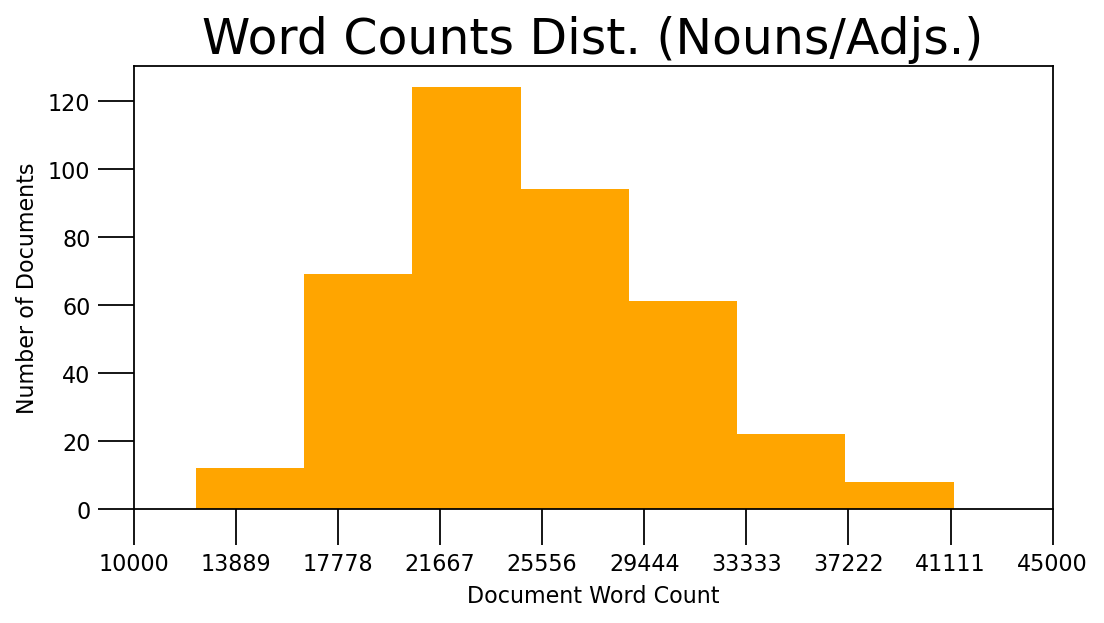

In [308]:
doc_lens = [len(d) for d in df_nouns_adj_int['cleaned']]

# Plot
plt.figure(figsize=(7,4), dpi=160)
plt.hist(doc_lens, color='orange')
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(10000, 45000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(10000,45000,10))
plt.title('Word Counts Dist. (Nouns/Adjs.)', fontdict=dict(size=22))
plt.tight_layout()
plt.savefig('nnadj_dist.svg')
plt.show()

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


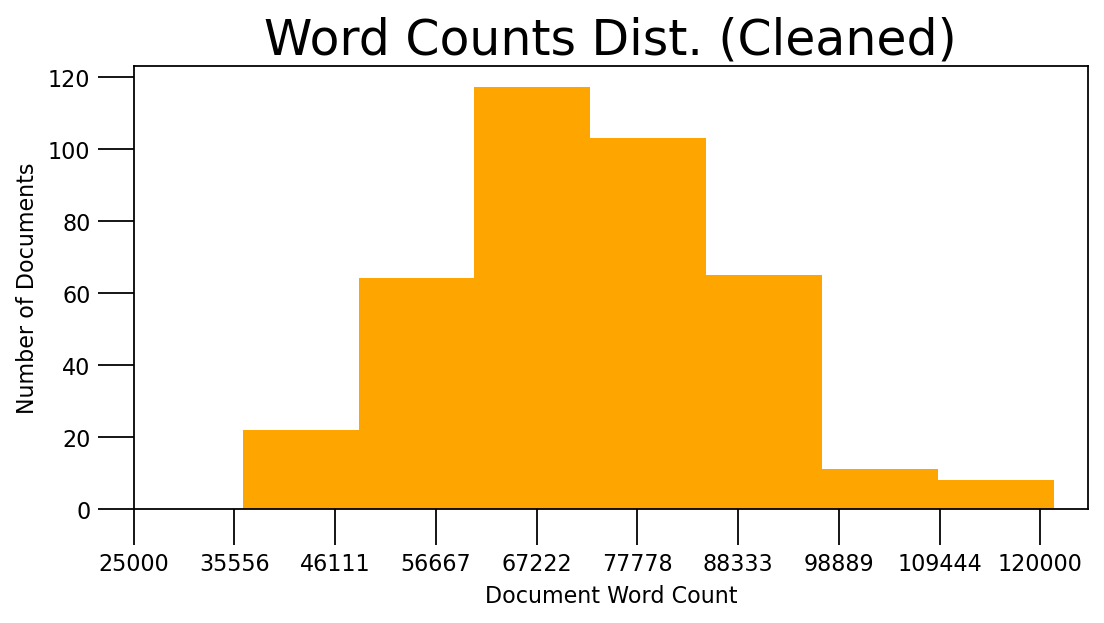

In [309]:
doc_lens = [len(d) for d in df_int['cleaned']]

# Plot
plt.figure(figsize=(7,4), dpi=160)
plt.hist(doc_lens, color='orange')
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(25000, 125000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(25000,120000,10))
plt.title('Word Counts Dist. (Cleaned)', fontdict=dict(size=22))
plt.tight_layout()
plt.savefig('numwords.svg')
plt.show()

In [177]:
for d in df_nouns_adj_int['cleaned']:
    print(len(d))

26156
32191
26052
34876
31904
25085
18960
24993
23369
21302
25752
35662
24001
29889
23503
26714
27819
22628
17852
27887
28967
18135
24284
27814
21178
23557
18494
20237
33971
25314
27713
20018
17099
22359
17718
15497
23839
26745
20106
24803
17799
22713
19628
18041
19675
21181
22036
23624
19591
33536
29638
27230
25341
19804
21930
17766
21415
24335
16913
25662
25785
30733
19568
30957
41230
37889
24115
29125
20195
19692
29227
19665
21812
25969
18452
32499
21468
26862
21160
28450
21599
28409
31893
26408
19255
20346
26907
38103
21396
21016
17223
29865
24145
29916
21442
21806
22870
14364
21836
18887
29437
25628
21203
27343
21191
22154
21086
24224
19170
19283
28690
25372
31281
18240
22007
33643
25109
29138
22318
26460
29241
28426
18739
22664
21083
27742
30824
22087
26357
23078
23203
22246
22548
24822
23458
27065
25407
27561
24218
22573
22516
28640
23848
25106
24325
23117
29551
24642
29494
28622
25072
25868
23022
29149
40098
22627
30195
21272
32932
24545
21433
27526
28223
27430
35314
34328
2524

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [248]:
def topics_per_document(model, corpus, start=0, end=1):
    #corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpusna, end=-1)  

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: 'int' object is not subscriptable

In [267]:
for idx, i in enumerate(lda[corpusna]):
    for tup in i: 
        print(sorted(tup),idx)
        #topic = sorted(tup)[0][0]
    #print(dominant_topic)
        #print(topic)

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0, 0.35098583] 0
[0.12985472, 2] 0
[0.51883906, 3] 0
[0.95395803, 3] 1
[0.04321911, 4] 1
[0, 0.2427896] 2
[0.47392103, 1] 2
[0.10393315, 2] 2
[0.1791372, 3] 2
[0, 0.22106983] 3
[0.23570977, 2] 3
[0.5429274, 3] 3
[0.07368162, 2] 4
[0.85832363, 3] 4
[0.06762744, 4] 4
[0.30092025, 1] 5
[0.21973038, 2] 5
[0.47883826, 4] 5
[0, 0.16193208] 6
[0.037450284, 1] 6
[0.68018824, 2] 6
[0.12012061, 3] 6
[0, 0.35742033] 7
[0.64178884, 2] 7
[0.8626082, 1] 8
[0.13295826, 2] 8
[0, 0.22355627] 9
[0.39399323, 1] 9
[0.034108445, 2] 9
[0.34808132, 3] 9
[0, 0.5831578] 10
[0.08707685, 1] 10
[0.23248976, 2] 10
[0.094536245, 4] 10
[0, 0.06815759] 11
[0.12794374, 1] 11
[0.71227235, 2] 11
[0.091471456, 3] 11
[0, 0.32029697] 12
[0.533287, 1] 12
[0.07425805, 2] 12
[0.0719476, 4] 12
[0, 0.59864366] 13
[0.114166416, 1] 13
[0.2868727, 2] 13
[0, 0.025315922] 14
[0.86703855, 1] 14
[0.048068188, 3] 14
[0.059301548, 4] 14
[0, 0.03233686] 15
[0.8685898, 1] 15
[0.07419018, 2] 15
[0.024666019, 4] 15
[0.15145014, 1] 16
[0.05

[0.79050297, 1] 149
[0.13394201, 2] 149
[0.07517301, 3] 149
[0.94704765, 1] 150
[0.05222391, 2] 150
[0.83511406, 1] 151
[0.1322376, 2] 151
[0.032181066, 3] 151
[0, 0.111371756] 152
[0.77925634, 1] 152
[0.06241641, 2] 152
[0.046716448, 3] 152
[0.29776335, 1] 153
[0.57390946, 2] 153
[0.12791494, 4] 153
[0, 0.22618407] 154
[0.54300433, 1] 154
[0.09324598, 2] 154
[0.098124385, 3] 154
[0.039441284, 4] 154
[0.77120394, 1] 155
[0.16392307, 2] 155
[0.043799523, 3] 155
[0.016565263, 4] 155
[0.4909496, 1] 156
[0.06682372, 2] 156
[0.41331828, 3] 156
[0.028721694, 4] 156
[0.39784372, 1] 157
[0.42553136, 2] 157
[0.17603695, 4] 157
[0, 0.39323863] 158
[0.06285591, 1] 158
[0.54246294, 2] 158
[0.7121045, 1] 159
[0.2385218, 2] 159
[0.048902232, 3] 159
[0.7951646, 1] 160
[0.12909986, 2] 160
[0.04774304, 3] 160
[0.027733242, 4] 160
[0.039365724, 1] 161
[0.17968427, 2] 161
[0.37804067, 3] 161
[0.40271515, 4] 161
[0.48050344, 1] 162
[0.48147193, 3] 162
[0.03765987, 4] 162
[0.77134144, 1] 163
[0.22804165, 3

[0, 0.22833191] 317
[0.41426304, 1] 317
[0.13445643, 2] 317
[0.13586509, 3] 317
[0.08708357, 4] 317
[0.8343332, 1] 318
[0.010022732, 2] 318
[0.15526423, 4] 318
[0.79039824, 1] 319
[0.04127313, 2] 319
[0.043396287, 3] 319
[0.12472675, 4] 319
[0, 0.228332] 320
[0.4142619, 1] 320
[0.13445602, 2] 320
[0.13586462, 3] 320
[0.08708548, 4] 320
[0.7852368, 1] 321
[0.12104232, 2] 321
[0.090130314, 4] 321
[0.81274223, 1] 322
[0.13129169, 2] 322
[0.027323458, 3] 322
[0.028463908, 4] 322
[0.121133044, 1] 323
[0.15829194, 2] 323
[0.13141249, 3] 323
[0.58897424, 4] 323
[0.8026114, 1] 324
[0.029558633, 3] 324
[0.16704768, 4] 324
[0, 0.030688506] 325
[0.22113791, 1] 325
[0.710453, 2] 325
[0.0116186105, 3] 325
[0.026101988, 4] 325
[0, 0.14150049] 326
[0.4402411, 1] 326
[0.34680757, 3] 326
[0.071277305, 4] 326
[0, 0.35152906] 327
[0.57882583, 1] 327
[0.06270528, 4] 327
[0, 0.10039055] 328
[0.6373127, 1] 328
[0.06099291, 2] 328
[0.16074505, 3] 328
[0.040558714, 4] 328
[0.9874919, 1] 329
[0.01127975, 4] 32

In [253]:
lda[corpusna][0]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.35098583), (2, 0.12985472), (3, 0.51883906)]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


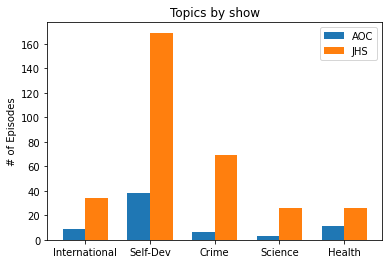

In [292]:
labels = ['International', 'Self-Dev', 'Crime', 'Science', 'Health']
aoc_num = [9, 38, 6, 3, 11]
jhs_num = [34, 169, 69, 26, 26]

x = np.arange(5)
width = 0.35
fig, ax = plt.subplots()
aoc_bar = ax.bar(x - width/2, aoc_num, width, label='AOC')
jhs_bar = ax.bar(x + width/2, jhs_num, width, label='JHS')
ax.set_ylabel('# of Episodes')
ax.set_title('Topics by show')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.savefig('TotalTopics.svg')

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


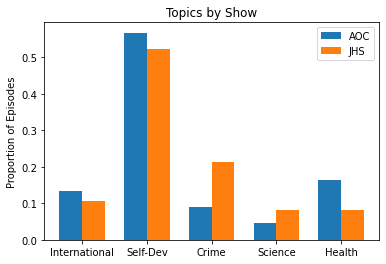

In [293]:
labels = ['International', 'Self-Dev', 'Crime', 'Science', 'Health']
aoc_num = [9/67, 38/67, 6/67, 3/67, 11/67]
jhs_num = [34/324, 169/324, 69/324, 26/324, 26/324]

x = np.arange(5)
width = 0.35
fig, ax = plt.subplots()
aoc_bar = ax.bar(x - width/2, aoc_num, width, label='AOC')
jhs_bar = ax.bar(x + width/2, jhs_num, width, label='JHS')
ax.set_ylabel('Proportion of Episodes')
ax.set_title('Topics by Show')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.savefig('TopicProportions.svg')

In [294]:
lda_corpus[0]

/Users/chuckcao/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.350986), (2, 0.12985444), (3, 0.5188392)]